In [1]:
'''Loading libraries'''
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import os 
import math

#path = "C:/Users/raoki/Documents/Project 1/"
path = 'C:/Users/raque/Google Drive/SFU/CMPT884 - Course Project and presentation'
os.chdir(path)
%matplotlib inline  

In [2]:
'''Loading Logistic Regresson Features by gene'''
#Pre-prossing on R
gsd = pd.read_table('data_gscore_features_bygene.csv', sep=';',index_col=False)
gsd.head()
print(gsd[gsd.gene=='TBL1XR1'])
print(gsd[gsd.gene=='MECOM'])


          gene  ensembl_gene_id    gene_biotype  chromosome_name      start  \
16364  TBL1XR1  ENSG00000177565  protein_coding                3  177019340   

             end   g_score    mutsig   avg_expr     sirna  
16364  177228000  0.091841 -2.581867  11.923896 -2.136782  
       gene  ensembl_gene_id    gene_biotype  chromosome_name      start  \
9516  MECOM  ENSG00000085276  protein_coding                3  169083499   

            end   g_score    mutsig  avg_expr     sirna  
9516  169663618  0.101413 -0.050593   7.68007  0.239006  


In [3]:
'''Normalization Features'''
#The bigger the value, higher the chance of being a driver gene
#print(features.head())
gsd['mutsig'] = gsd['mutsig']*(-1) 
gsd['sirna'] = gsd['sirna']*(-1)

gsd['mutsig'] = (gsd['mutsig']-gsd['mutsig'].mean())/(gsd['mutsig'].std())
gsd['avg_expr'] = (gsd['avg_expr']-gsd['avg_expr'].mean())/(gsd['avg_expr'].std())
gsd['sirna'] = (gsd['sirna']-gsd['sirna'].mean())/(gsd['sirna'].std())

In [4]:
'''Droping SiRNA and NA'''
print(gsd.shape)
gsd = gsd.dropna(axis=0,how='any')
print(gsd.shape)

(19279, 10)
(12957, 10)


In [5]:
'''Selecting top100 genes in each feature'''
#The top100 genes will be added into the final dataset, 
#even if their g-score is not very large

#mutsig
gsd = gsd.sort_values('mutsig', ascending=0)
top_genes_f = gsd['gene'].head(100)
#avg_expr
gsd = gsd.sort_values('avg_expr', ascending=0)
top_genes_f = top_genes_f.append(gsd['gene'].head(100))
#sirna
gsd = gsd.sort_values('sirna', ascending=0)
top_genes_f = top_genes_f.append(gsd['gene'].head(100))

#removing duplicated genes on the vector 
top_genes_f = top_genes_f.unique()
top_genes_f = set(top_genes_f)

'''Evaluation'''
intogen = ['ADCY1','AHNAK','AKAP9','APC','AQR','ARFGAP3','ARID1B','ATIC','ATM','ATRX','BCLAF1',
           'BCOR','BNC2','BPTF','BRAF','CASP1','CAT','CDC27','CDH1','CDKN1B','CEP290','CHD1L',
           'CHD3','CHD4','CHEK2','CNOT1','CNOT3','CNTNAP1','CTNNB1','CUL2','CUL3','EEF1B2','EGFR',
           'EIF2AK3','EIF4G1','EP300','ERCC2','FAT1','FGFR2','FIP1L1','FN1','FRG1','G3BP2','GNAS',
           'HGF','HNF1A','HRAS','HSP90AB1','HSPA8','IDH1','IRS2','KDM6A','KEAP1','MECOM','MED12',
           'MLL2','MYH10','NAP1L1','NKX3-1','NOTCH1','NOTCH2','NUP98','PCDH18','PIK3CB','PLXNA1',
           'PRPF8','PTEN','RPSAP58','SCAI','SETDB1','SMAD4','SMARCA1','SMARCB1','SPOP','SVEP1','TAOK2',
           'TBL1XR1','TBX3','THRAP3','TJP1','TJP2','TP53','TP53BP1','TRIO','WHSC1L1','WNT5A','ZFHX3','ZNF814']


census = ['ACSL3','AR','AXIN1','BRAF','CANT1','DDX5','ELK4','ERG','ETV1','ETV4','ETV5',
          'FOXA1','HERPUD1','HNRNPA2B1','KLF6','KLK2','NCOR2','NDRG1','PTEN','RAF1',
          'SALL4','SLC45A3','SPOP','TMPRSS2','ZFHX3']

evaluation = list(set(intogen) | set(census))

#forcing those genes to appear on the dataset
#top_genes_f = set.union(top_genes_f, evaluation)

'''This genes have high values from features, they should be at the data after
the filter, even if their g-score are not large'''
#Bool variable: 1 if gene is on top100 from features, 0 otherwise 
gsd['top_features'] = 0
gsd = gsd.reset_index(drop=True)

for i in np.arange(0,gsd.shape[0]):  
    if gsd.gene[i] in top_genes_f:
        gsd.loc[i,'top_features'] = 1

In [6]:
'''Defining driver genes model's seed'''
#top100 genes from g-score are used as driver genes seed
#top101-1500 genes from g-score or present in the top100 features are the passengers genes seed 
#The threhold 1500 was defined based on the paper (they mentioned 84 regions with about 14 genes each)
gsd = gsd.sort_values(by=['g_score'],axis=0,ascending=False)
gsd['top_gscore'] = 0
gsd['top_gscore'][101:1200] = 1

'''Creating data'''
#y: 1 if gene is driver, 0 otherwise 
gd = gsd[0:100]
gd['y']=1
gp = gsd.loc[((gsd.top_gscore==1) | (gsd.top_features==1))]
gp['y']=0

#new dataset deleting unimportant columns 
#some warnings, but everything is fine  
f = 4
data = pd.concat([gd,gp])
data['intercept']=1
data = data[['gene','g_score','intercept','mutsig','avg_expr','sirna','y']]
data.columns = ['gene','gscore','intercept','mutsig','avg_expr','sirna','y']

C:\Users\raque\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\raque\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\raque\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
 

In [7]:
'''Checking g-score distribution of driver and passengers genes'''
print('driver genes size - seed',gd['g_score'].shape[0])
print('passenger genes size - seed',gp['g_score'].shape[0])

driver genes size - seed 100
passenger genes size - seed 1369


In [8]:
'''Metropolis-Hastings algorithm'''
#Definitions 
#theta: set of unknown paramets
#using normal distribution instead of exponential distribution

#Unknown parameters - start values
#N(mu0,var0): driver genes
#N(mu1,var1): passenger genes
theta_start = [0,0,0,0,0.06,0.06] #w0,w1,w2,w3,mu0, mu1
T = np.array(data['y'])

'''Likelihood 1: P(T|w,x)~logit()'''
def likelihood1_old(param,data,T,f):
    xw = data[['intercept','mutsig','avg_expr','sirna']].dot(param[0:f])
    l1 = 1/(1+np.exp(-xw))
    l0 = 1 - l1  
    l1[T==0] = l0[T==0]
    l1 = l1+0.000001
    return np.log(l1).sum()

'''Likelihood 2: P(Gscore|T,mean,sd)~Normal(mean,sd)'''
def likelihood2_old(param,T,data,f):
    media = T
    media=[param[f] if x==0 else param[f+1] for x in media]
    l2 = scipy.stats.norm(media,0.1).pdf(data.gscore)
    return np.log(l2).sum()

#print(likelihood1(theta_start, data, T),likelihood2(theta_start, T, data,f))

In [9]:
'''Priori: w0,w1,w2,w3, mu0,mu1'''
def priori(param,f):
    w = scipy.stats.norm(0,0.25).pdf(param[0:f])
    mu0 = scipy.stats.norm(0.05,0.03).pdf(param[f])
    mu1 = scipy.stats.norm(0.09,0.03).pdf(param[f+1])
    r = np.log(w).sum()+np.log(mu1)+np.log(mu0)
    return r


In [10]:
'''Posterior'''
def posterior(param,T,data,f):
    print(likelihood2_old(param,T,data,f),likelihood1_old(param,data,T,f),priori(param,f),np.around(param,2))
    return likelihood2_old(param,T,data,f)+likelihood1_old(param,data,T,f)+priori(param,f)

#Vector with proposed values 
# Values are proposed from a Normal distribution
# mean is equal to current values and variance are hyperparameters 
#theta_proposed = np.random.normal(theta_current,[0.5,0.5,0.5,0.5,0.02,0.02,0.0004,0.0004])
'''ProposalValue'''
def proposalvalues(param):
    return(np.random.normal(param,[0.05,0.05,0.05,0.05,0.005,0.005]))

In [11]:
def T_update_old(param,f):
    xw = data[['intercept','mutsig','avg_expr','sirna']].dot(param[0:f])
    t11 = 1/(1+np.exp(-xw)) #array    
    t21 = scipy.stats.norm(param[f+1], 0.01).pdf(data.gscore)

    t10 = 1-(1/(1+np.exp(-xw))) #array    
    t20 = scipy.stats.norm(param[f], 0.01).pdf(data.gscore)
    
    t1 = t11*t21
    t0 = t10*t20
    
    prob_t1 = t1/(t1+t0)
    
    t_new = np.random.binomial(1,prob_t1,len(prob_t1))
    print(t_new.sum(),'\n')
    return t_new


In [12]:
'''MCMC'''
def runMCMC_old(startvalue,iterations,T,data,f):
    chain = np.zeros((iterations+1,len(startvalue)))
    Tmatrix = np.zeros((iterations+1,len(T)))
    chain[0]=startvalue
    Tmatrix[0]=T
    for i in np.arange(iterations):
        proposal = proposalvalues(chain[i,])
        prob = np.exp(posterior(proposal,T,data,f)-posterior(chain[i,],T,data,f))
        print('\n',i)
        if np.all(np.random.uniform(0,1,1) < prob):
            chain[i+1] = proposal
            T = T_update_old(proposal,f) 
            Tmatrix[i+1] = T
        else:
            chain[i+1] = chain[i]
            Tmatrix[i+1] = Tmatrix[i]
    return chain, T ,Tmatrix       
            

#https://theoreticalecology.wordpress.com/2010/09/17/metropolis-hastings-mcmc-in-r/

In [13]:
f=4 #3 features + intercept
chain, Tnew,Tmatrix  = runMCMC_old(theta_start,8000,T,data,f)


1975.51585599 -1026.627245809757 5.83729340956 [ 0.   -0.01 -0.03  0.06  0.06  0.05]
1986.38437812 -1018.2302702454926 6.48910648434 [ 0.    0.    0.    0.    0.06  0.06]

 0
1981.24807235 -1003.503838136436 6.59554054149 [-0.02  0.   -0.04  0.01  0.06  0.07]
1986.38437812 -1018.2302702454926 6.48910648434 [ 0.    0.    0.    0.    0.06  0.06]

 1
627 

1981.26060471 -1029.6603885907841 6.36243429307 [-0.01  0.04 -0.12  0.12  0.06  0.07]
1979.97303536 -1014.1796681311135 6.59554054149 [-0.02  0.   -0.04  0.01  0.06  0.07]

 2
1986.20765942 -1013.6324967367071 6.31953159109 [-0.01  0.05 -0.13 -0.06  0.06  0.06]
1979.97303536 -1014.1796681311135 6.59554054149 [-0.02  0.   -0.04  0.01  0.06  0.07]

 3
690 

1987.33539106 -1019.0482009173822 6.39955825243 [-0.07  0.09 -0.12  0.04  0.05  0.06]
1986.12015609 -1009.3488734348134 6.31953159109 [-0.01  0.05 -0.13 -0.06  0.06  0.06]

 4
1989.67589224 -1017.6079460005776 5.98988291681 [ 0.    0.12 -0.14 -0.15  0.05  0.06]
1986.12015609 -1009.3488

2013.19534503 -951.9891414123346 3.48381559658 [ 0.06  0.43  0.09  0.14  0.07  0.04]

 48
707 

2006.21010893 -954.4518159076699 3.44220409282 [ 0.01  0.44 -0.    0.17  0.08  0.04]
2012.53956019 -950.8413311273081 3.45976865547 [ 0.04  0.36  0.14  0.27  0.07  0.04]

 49
2012.66320817 -951.8740815825265 3.20218973027 [ 0.06  0.4   0.12  0.27  0.07  0.04]
2012.53956019 -950.8413311273081 3.45976865547 [ 0.04  0.36  0.14  0.27  0.07  0.04]

 50
2011.02106651 -948.8292153899597 3.17603789552 [ 0.04  0.4   0.12  0.17  0.07  0.03]
2012.53956019 -950.8413311273081 3.45976865547 [ 0.04  0.36  0.14  0.27  0.07  0.04]

 51
562 

2012.22759924 -960.4208893375087 2.76470742672 [ 0.06  0.51  0.05  0.12  0.07  0.03]
2012.29671009 -950.696489483851 3.17603789552 [ 0.04  0.4   0.12  0.17  0.07  0.03]

 52
2011.480071 -970.4275215397076 2.58746450678 [ 0.12  0.44  0.12  0.15  0.07  0.03]
2012.29671009 -950.696489483851 3.17603789552 [ 0.04  0.4   0.12  0.17  0.07  0.03]

 53
2008.40261905 -962.24502003

2008.0484396 -924.3196872688362 1.57846329645 [-0.35  0.3   0.37  0.27  0.08  0.04]
2013.1245501 -922.9170160430789 1.65239697103 [-0.3   0.33  0.39  0.31  0.07  0.04]

 95
2013.04991864 -933.3918495696938 1.47454449744 [-0.19  0.32  0.39  0.42  0.07  0.04]
2013.1245501 -922.9170160430789 1.65239697103 [-0.3   0.33  0.39  0.31  0.07  0.04]

 96
2012.96273913 -922.5929842178208 2.12263162439 [-0.26  0.34  0.31  0.3   0.07  0.03]
2013.1245501 -922.9170160430789 1.65239697103 [-0.3   0.33  0.39  0.31  0.07  0.04]

 97
745 

2010.97959728 -955.1726766712205 2.22044832161 [-0.37  0.4   0.16  0.29  0.08  0.04]
2013.75131028 -947.0253536861916 2.12263162439 [-0.26  0.34  0.31  0.3   0.07  0.03]

 98
2007.75847403 -947.3711331056857 1.03466868755 [-0.25  0.37  0.33  0.32  0.07  0.02]
2013.75131028 -947.0253536861916 2.12263162439 [-0.26  0.34  0.31  0.3   0.07  0.03]

 99
2013.46970092 -948.0661714442883 1.59447506173 [-0.23  0.4   0.36  0.32  0.07  0.04]
2013.75131028 -947.0253536861916 2.122

2007.51502648 -928.9026936212841 2.51912738281 [-0.03  0.51  0.29  0.26  0.07  0.05]

 143
762 

2004.77521055 -936.5181101866133 1.20047571493 [-0.05  0.53  0.36  0.37  0.06  0.04]
2013.05516514 -931.7890862820515 1.31844119886 [-0.05  0.53  0.37  0.28  0.07  0.04]

 144
2012.17873558 -934.6226906542923 0.396217813633 [-0.03  0.58  0.36  0.29  0.07  0.03]
2013.05516514 -931.7890862820515 1.31844119886 [-0.05  0.53  0.37  0.28  0.07  0.04]

 145
2012.46928366 -931.2450375257586 1.60433066912 [-0.06  0.48  0.41  0.25  0.07  0.04]
2013.05516514 -931.7890862820515 1.31844119886 [-0.05  0.53  0.37  0.28  0.07  0.04]

 146
713 

2006.90862868 -937.1261138646892 1.1633367815 [-0.03  0.54  0.48  0.2   0.06  0.04]
2012.26811374 -929.7608200067807 1.60433066912 [-0.06  0.48  0.41  0.25  0.07  0.04]

 147
2012.16010095 -927.1381407923408 1.91875150271 [-0.09  0.46  0.4   0.23  0.07  0.04]
2012.26811374 -929.7608200067807 1.60433066912 [-0.06  0.48  0.41  0.25  0.07  0.04]

 148
693 

2007.950392


 192
2010.50806221 -907.0943408450419 2.03938292449 [-0.26  0.45  0.29  0.26  0.07  0.04]
2008.50509261 -906.6745022360005 2.0717546652 [-0.29  0.48  0.27  0.23  0.06  0.04]

 193
643 

2011.61044673 -895.3813034101532 1.41118004784 [-0.28  0.45  0.3   0.32  0.07  0.04]
2010.96678323 -896.1589204853541 2.03938292449 [-0.26  0.45  0.29  0.26  0.07  0.04]

 194
729 

2012.97331282 -948.1085296110379 2.04553439197 [-0.19  0.35  0.22  0.45  0.07  0.04]
2013.13791075 -929.844785462025 1.41118004784 [-0.28  0.45  0.3   0.32  0.07  0.04]

 195
2013.1491277 -929.3816673985912 1.30478166693 [-0.36  0.41  0.31  0.28  0.07  0.03]
2013.13791075 -929.844785462025 1.41118004784 [-0.28  0.45  0.3   0.32  0.07  0.04]

 196
687 

2011.97995867 -915.7380181326886 0.847003244527 [-0.32  0.46  0.32  0.25  0.07  0.03]
2013.09754617 -915.9405508403231 1.30478166693 [-0.36  0.41  0.31  0.28  0.07  0.03]

 197
2010.19334484 -923.4419235234391 0.617481543472 [-0.42  0.35  0.35  0.39  0.06  0.03]
2013.09754617

2006.01307697 -850.4872629135025 -3.87860622807 [-0.78  0.49  0.4   0.44  0.07  0.05]
2006.79340354 -850.7796302192817 -4.22803027157 [-0.81  0.52  0.37  0.43  0.06  0.04]

 244
751 

2004.06040589 -976.243587502428 -4.10948993147 [-0.81  0.43  0.35  0.5   0.08  0.05]
2009.2528927 -962.3377539396894 -3.87860622807 [-0.78  0.49  0.4   0.44  0.07  0.05]

 245
2004.37298456 -964.7746052332712 -2.72510283189 [-0.73  0.4   0.36  0.5   0.06  0.05]
2009.2528927 -962.3377539396894 -3.87860622807 [-0.78  0.49  0.4   0.44  0.07  0.05]

 246
1992.26706586 -966.6270152638019 -4.0589378618 [-0.8   0.55  0.39  0.46  0.06  0.06]
2009.2528927 -962.3377539396894 -3.87860622807 [-0.78  0.49  0.4   0.44  0.07  0.05]

 247
2011.0813464 -962.4301734025477 -5.04450870442 [-0.8   0.52  0.46  0.44  0.07  0.04]
2009.2528927 -962.3377539396894 -3.87860622807 [-0.78  0.49  0.4   0.44  0.07  0.05]

 248
792 

2008.89626166 -1024.8891321851231 -6.38462832042 [-0.87  0.54  0.45  0.42  0.08  0.04]
2012.22152875 -101

1019 

1989.93693415 -957.0733155727984 2.36363596063 [-0.06  0.34  0.34  0.46  0.09  0.06]
2005.31301775 -983.152102672884 1.66841772466 [-0.15  0.29  0.41  0.48  0.08  0.05]

 290
1154 

1989.96929925 -999.2083659557138 2.05913980762 [-0.1   0.39  0.34  0.45  0.09  0.06]
1991.54126609 -985.2055501333169 2.36363596063 [-0.06  0.34  0.34  0.46  0.09  0.06]

 291
2003.35666837 -991.2902686962747 2.63522330904 [-0.1   0.39  0.3   0.36  0.08  0.05]
1991.54126609 -985.2055501333169 2.36363596063 [-0.06  0.34  0.34  0.46  0.09  0.06]

 292
1074 

2000.49838047 -972.0235785298464 2.89482245163 [-0.04  0.34  0.29  0.42  0.08  0.06]
2004.10357664 -983.7495872448953 2.63522330904 [-0.1   0.39  0.3   0.36  0.08  0.05]

 293
1074 

2007.52774499 -982.2869656334684 2.17488470268 [-0.02  0.28  0.23  0.56  0.08  0.05]
2000.04505943 -969.4223543280556 2.89482245163 [-0.04  0.34  0.29  0.42  0.08  0.06]

 294
2008.51978897 -931.8442469557519 2.46969496803 [ 0.1   0.37  0.31  0.39  0.08  0.05]
2000.045

2013.0326915 -926.4746790326705 2.22407150524 [ 0.35  0.41  0.29  0.14  0.08  0.04]

 338
2010.85548036 -927.3388839260284 2.29720461326 [ 0.35  0.39  0.3   0.1   0.08  0.04]
2013.0326915 -926.4746790326705 2.22407150524 [ 0.35  0.41  0.29  0.14  0.08  0.04]

 339
2012.61010369 -926.0264274437866 2.25561880916 [ 0.34  0.42  0.26  0.16  0.08  0.04]
2013.0326915 -926.4746790326705 2.22407150524 [ 0.35  0.41  0.29  0.14  0.08  0.04]

 340
948 

2010.50470327 -923.0112156143191 2.72470086438 [ 0.39  0.35  0.27  0.02  0.08  0.05]
2012.55817093 -919.4714637922732 2.25561880916 [ 0.34  0.42  0.26  0.16  0.08  0.04]

 341
2009.0233302 -924.052481717469 2.71593282359 [ 0.29  0.44  0.31  0.13  0.07  0.05]
2012.55817093 -919.4714637922732 2.25561880916 [ 0.34  0.42  0.26  0.16  0.08  0.04]

 342
2007.65515179 -917.4086646886298 1.9887876497 [ 0.44  0.4   0.19  0.21  0.09  0.05]
2012.55817093 -919.4714637922732 2.25561880916 [ 0.34  0.42  0.26  0.16  0.08  0.04]

 343
2010.24163512 -921.4602195108

2009.7057358 -946.4064400630266 3.60648330788 [ 0.16  0.43  0.18  0.12  0.07  0.05]
2013.32910841 -948.1517694642952 2.54929357588 [ 0.18  0.49  0.23  0.12  0.07  0.04]

 387
927 

2010.82675242 -931.7597788476353 3.24688251076 [ 0.19  0.42  0.17  0.15  0.08  0.04]
2009.41701515 -934.9565592777369 3.60648330788 [ 0.16  0.43  0.18  0.12  0.07  0.05]

 388
971 

2006.74106879 -933.6441165452421 3.22910483362 [ 0.21  0.44  0.18  0.09  0.09  0.05]
2012.07502185 -932.5425968024208 3.24688251076 [ 0.19  0.42  0.17  0.15  0.08  0.04]

 389
2006.96088374 -935.6542319600005 3.46974924548 [ 0.16  0.4   0.16  0.18  0.09  0.05]
2012.07502185 -932.5425968024208 3.24688251076 [ 0.19  0.42  0.17  0.15  0.08  0.04]

 390
2010.69865022 -928.0874694886951 3.34216536432 [ 0.28  0.39  0.23  0.04  0.08  0.05]
2012.07502185 -932.5425968024208 3.24688251076 [ 0.19  0.42  0.17  0.15  0.08  0.04]

 391
950 

2012.36112858 -932.3919409617362 2.56219794386 [ 0.34  0.41  0.28  0.02  0.08  0.04]
2010.3601987 -931.

2007.20393847 -953.6327533598914 1.76181784283 [ 0.3   0.41  0.26  0.16  0.09  0.04]
2012.76022074 -950.4600852491604 2.93209688281 [ 0.25  0.33  0.23  0.15  0.08  0.03]

 434
2012.80754147 -956.5481698110442 3.15157580534 [ 0.28  0.24  0.27  0.13  0.08  0.04]
2012.76022074 -950.4600852491604 2.93209688281 [ 0.25  0.33  0.23  0.15  0.08  0.03]

 435
2012.85949842 -953.3243405376121 3.17595751389 [ 0.27  0.31  0.28  0.12  0.08  0.04]
2012.76022074 -950.4600852491604 2.93209688281 [ 0.25  0.33  0.23  0.15  0.08  0.03]

 436
2013.08499326 -952.7601870627938 1.78846399422 [ 0.25  0.47  0.23  0.23  0.07  0.03]
2012.76022074 -950.4600852491604 2.93209688281 [ 0.25  0.33  0.23  0.15  0.08  0.03]

 437
2012.66103576 -952.0320997318704 2.37617059894 [ 0.28  0.38  0.23  0.2   0.07  0.03]
2012.76022074 -950.4600852491604 2.93209688281 [ 0.25  0.33  0.23  0.15  0.08  0.03]

 438
2010.26300284 -950.4289899626683 2.68116594054 [ 0.23  0.38  0.17  0.1   0.08  0.03]
2012.76022074 -950.4600852491604 2.

2013.37682541 -951.6672336156281 3.8565818766 [ 0.12  0.34  0.12  0.19  0.07  0.04]

 483
2012.78602257 -952.7651926860912 2.94881694339 [ 0.09  0.45  0.12  0.18  0.08  0.04]
2013.37682541 -951.6672336156281 3.8565818766 [ 0.12  0.34  0.12  0.19  0.07  0.04]

 484
2012.93771481 -952.5703922469842 3.79259008393 [ 0.09  0.37  0.09  0.2   0.07  0.04]
2013.37682541 -951.6672336156281 3.8565818766 [ 0.12  0.34  0.12  0.19  0.07  0.04]

 485
2003.74644448 -952.5906179739765 4.73163774783 [ 0.12  0.3   0.12  0.2   0.07  0.05]
2013.37682541 -951.6672336156281 3.8565818766 [ 0.12  0.34  0.12  0.19  0.07  0.04]

 486
2012.85841913 -956.2060899165413 3.47559291408 [ 0.17  0.37  0.09  0.27  0.07  0.04]
2013.37682541 -951.6672336156281 3.8565818766 [ 0.12  0.34  0.12  0.19  0.07  0.04]

 487
2012.89017375 -952.8563556748348 3.25787962537 [ 0.18  0.38  0.14  0.18  0.07  0.03]
2013.37682541 -951.6672336156281 3.8565818766 [ 0.12  0.34  0.12  0.19  0.07  0.04]

 488
2012.84264252 -952.6895406450008 3.

2013.18996418 -945.6524285635198 3.6600267968 [ 0.18  0.3   0.18  0.15  0.08  0.04]
2013.52354307 -945.0363929382653 3.6900647904 [ 0.16  0.28  0.23  0.19  0.07  0.04]

 533
2011.92534192 -944.0296823302536 4.06075436979 [ 0.14  0.32  0.19  0.18  0.07  0.04]
2013.52354307 -945.0363929382653 3.6900647904 [ 0.16  0.28  0.23  0.19  0.07  0.04]

 534
878 

2007.17774772 -944.8228671788486 3.89956599797 [ 0.17  0.32  0.27  0.14  0.08  0.05]
2011.97516066 -945.0443764503221 4.06075436979 [ 0.14  0.32  0.19  0.18  0.07  0.04]

 535
2009.05077581 -945.4063064227693 4.02101322475 [ 0.13  0.37  0.18  0.18  0.07  0.05]
2011.97516066 -945.0443764503221 4.06075436979 [ 0.14  0.32  0.19  0.18  0.07  0.04]

 536
2001.34188116 -944.5823980820578 4.55389369712 [ 0.19  0.34  0.19  0.11  0.06  0.05]
2011.97516066 -945.0443764503221 4.06075436979 [ 0.14  0.32  0.19  0.18  0.07  0.04]

 537
2010.49329197 -944.1077202106641 3.5782942347 [ 0.19  0.41  0.2   0.16  0.07  0.05]
2011.97516066 -945.0443764503221 

2013.08460448 -868.0889413228317 3.1354314803 [-0.25  0.25  0.09  0.03  0.06  0.02]

 582
2012.47508198 -873.6539141431787 3.73792364271 [-0.23  0.24  0.09  0.06  0.06  0.03]
2013.08460448 -868.0889413228317 3.1354314803 [-0.25  0.25  0.09  0.03  0.06  0.02]

 583
2012.72803986 -870.8805626966051 3.54427472572 [-0.24  0.2   0.09  0.06  0.07  0.02]
2013.08460448 -868.0889413228317 3.1354314803 [-0.25  0.25  0.09  0.03  0.06  0.02]

 584
2010.79232755 -888.7113830092197 4.28150901258 [-0.19  0.19  0.11  0.09  0.06  0.03]
2013.08460448 -868.0889413228317 3.1354314803 [-0.25  0.25  0.09  0.03  0.06  0.02]

 585
2013.15566525 -868.3630947206155 2.26767307929 [-0.25  0.26  0.09  0.01  0.07  0.01]
2013.08460448 -868.0889413228317 3.1354314803 [-0.25  0.25  0.09  0.03  0.06  0.02]

 586
273 

2014.11733236 -854.4356487785411 2.29557820032 [-0.28  0.19  0.17  0.03  0.06  0.01]
2013.48987159 -867.3785095326951 2.26767307929 [-0.25  0.26  0.09  0.01  0.07  0.01]

 587
252 

2014.57961033 -869.446

2004.82834988 -650.3130333138797 -4.12516558454 [-0.96  0.17  0.38  0.12  0.05  0.03]

 630
280 

1997.6512331 -633.707831739786 -5.93712286015 [-1.12  0.14  0.29  0.14  0.05  0.03]
2001.18914445 -626.4441299650256 -5.53571829654 [-1.05  0.24  0.35  0.12  0.05  0.03]

 631
1999.61207226 -628.5580093751507 -7.7346621286 [-1.13  0.21  0.45  0.04  0.05  0.02]
2001.18914445 -626.4441299650256 -5.53571829654 [-1.05  0.24  0.35  0.12  0.05  0.03]

 632
1995.88599275 -633.9223909990909 -5.64631741227 [-1.05  0.21  0.37  0.1   0.05  0.03]
2001.18914445 -626.4441299650256 -5.53571829654 [-1.05  0.24  0.35  0.12  0.05  0.03]

 633
1995.63699566 -642.5912666829341 -4.58465564021 [-0.99  0.24  0.46  0.1   0.05  0.04]
2001.18914445 -626.4441299650256 -5.53571829654 [-1.05  0.24  0.35  0.12  0.05  0.03]

 634
2004.53681729 -633.3914945599962 -5.54017344081 [-1.1   0.19  0.27  0.09  0.05  0.03]
2001.18914445 -626.4441299650256 -5.53571829654 [-1.05  0.24  0.35  0.12  0.05  0.03]

 635
1998.47176541 -

 678
2005.61914006 -591.1425271439191 -12.6271989071 [-1.19  0.59  0.55  0.36  0.05  0.03]
2010.64862914 -614.8761341754297 -10.246057839 [-1.05  0.58  0.59  0.33  0.06  0.03]

 679
294 

2002.36881173 -562.3572295163195 -12.0475588533 [-1.13  0.61  0.52  0.36  0.05  0.02]
2006.15061875 -551.327927896882 -12.6271989071 [-1.19  0.59  0.55  0.36  0.05  0.03]

 680
2012.20332458 -558.604869329811 -12.58266581 [-1.17  0.57  0.54  0.43  0.06  0.03]
2006.15061875 -551.327927896882 -12.6271989071 [-1.19  0.59  0.55  0.36  0.05  0.03]

 681
2000.53852397 -549.2933677780492 -11.3814395698 [-1.21  0.5   0.46  0.33  0.05  0.03]
2006.15061875 -551.327927896882 -12.6271989071 [-1.19  0.59  0.55  0.36  0.05  0.03]

 682
2001.15419081 -553.3124374582417 -12.9801485114 [-1.19  0.58  0.55  0.41  0.05  0.03]
2006.15061875 -551.327927896882 -12.6271989071 [-1.19  0.59  0.55  0.36  0.05  0.03]

 683
1995.35137397 -561.8305870090004 -11.4739652956 [-1.15  0.6   0.46  0.43  0.05  0.03]
2006.15061875 -551.32

2012.40708774 -491.1942496864817 -24.1524234075 [-1.52  0.82  0.59  0.44  0.07  0.02]

 724
2012.43221942 -491.52753141166687 -25.5572735893 [-1.53  0.87  0.68  0.38  0.07  0.02]
2012.40708774 -491.1942496864817 -24.1524234075 [-1.52  0.82  0.59  0.44  0.07  0.02]

 725
2012.48154006 -503.0182177929376 -23.1033399371 [-1.47  0.89  0.57  0.35  0.06  0.02]
2012.40708774 -491.1942496864817 -24.1524234075 [-1.52  0.82  0.59  0.44  0.07  0.02]

 726
2012.94584079 -484.2841600065365 -25.2759773325 [-1.58  0.86  0.59  0.39  0.06  0.02]
2012.40708774 -491.1942496864817 -24.1524234075 [-1.52  0.82  0.59  0.44  0.07  0.02]

 727
306 

2010.88130045 -488.70530996036933 -24.3792491696 [-1.58  0.81  0.58  0.41  0.07  0.03]
2012.77090406 -490.4523090576249 -25.2759773325 [-1.58  0.86  0.59  0.39  0.06  0.02]

 728
396 

2012.12225852 -616.0025576861823 -25.8458005678 [-1.56  0.89  0.65  0.37  0.07  0.02]
2011.81346912 -614.6790608063653 -24.3792491696 [-1.58  0.81  0.58  0.41  0.07  0.03]

 729
2001

 772
329 

2011.24776756 -531.5489604148768 -21.3699695113 [-1.49  0.63  0.73  0.38  0.06  0.03]
2012.49341714 -531.8548602250894 -21.6511563095 [-1.48  0.65  0.73  0.38  0.06  0.03]

 773
380 

2009.30923337 -592.4502041149346 -19.5902368319 [-1.51  0.58  0.67  0.23  0.07  0.04]
2011.27640837 -580.636624152175 -21.3699695113 [-1.49  0.63  0.73  0.38  0.06  0.03]

 774
2003.61304779 -578.0963097910135 -22.4185288403 [-1.57  0.66  0.64  0.38  0.05  0.03]
2011.27640837 -580.636624152175 -21.3699695113 [-1.49  0.63  0.73  0.38  0.06  0.03]

 775
2012.22631736 -585.1377184065174 -21.3732045266 [-1.43  0.63  0.77  0.44  0.06  0.02]
2011.27640837 -580.636624152175 -21.3699695113 [-1.49  0.63  0.73  0.38  0.06  0.03]

 776
2007.50370897 -577.4674466640037 -22.5775590062 [-1.53  0.66  0.78  0.35  0.06  0.04]
2011.27640837 -580.636624152175 -21.3699695113 [-1.49  0.63  0.73  0.38  0.06  0.03]

 777
2009.94366654 -582.3773485599819 -20.9473044922 [-1.46  0.68  0.73  0.35  0.07  0.03]
2011.276408

 821
2009.232325 -575.4962705785676 -32.3350720182 [-1.84  0.78  0.63  0.54  0.06  0.03]
2011.38005963 -575.019117126376 -32.6657577073 [-1.87  0.74  0.63  0.51  0.06  0.03]

 822
340 

2011.23513352 -523.4104605468397 -34.525244753 [-1.89  0.77  0.56  0.66  0.06  0.03]
2008.94666849 -514.3692041850242 -32.3350720182 [-1.84  0.78  0.63  0.54  0.06  0.03]

 823
2010.14240959 -505.24084347531533 -36.6882444358 [-1.91  0.78  0.8   0.56  0.06  0.03]
2008.94666849 -514.3692041850242 -32.3350720182 [-1.84  0.78  0.63  0.54  0.06  0.03]

 824
332 

2004.43963544 -492.9543056107224 -34.3895223626 [-1.87  0.75  0.8   0.56  0.06  0.04]
2010.29845466 -489.91307875919784 -36.6882444358 [-1.91  0.78  0.8   0.56  0.06  0.03]

 825
2010.01104683 -489.2583734162972 -36.2886616513 [-1.9   0.79  0.83  0.5   0.06  0.03]
2010.29845466 -489.91307875919784 -36.6882444358 [-1.91  0.78  0.8   0.56  0.06  0.03]

 826
313 

2009.13652073 -472.9101176769277 -37.1892111054 [-1.96  0.76  0.77  0.56  0.06  0.03]
20

2014.31718285 -402.2752732817208 -42.8674290544 [-2.1   0.73  0.81  0.45  0.06  0.01]

 870
2014.05656837 -409.6235447556055 -40.8529575261 [-2.02  0.75  0.8   0.47  0.06  0.01]
2014.31718285 -402.2752732817208 -42.8674290544 [-2.1   0.73  0.81  0.45  0.06  0.01]

 871
2014.23461598 -406.94536113216606 -42.2211402546 [-2.06  0.81  0.82  0.46  0.06  0.02]
2014.31718285 -402.2752732817208 -42.8674290544 [-2.1   0.73  0.81  0.45  0.06  0.01]

 872
2012.10646513 -399.61164925376755 -43.2976287738 [-2.15  0.74  0.72  0.49  0.07  0.02]
2014.31718285 -402.2752732817208 -42.8674290544 [-2.1   0.73  0.81  0.45  0.06  0.01]

 873
305 

2008.23534832 -454.97387903446935 -44.2008273628 [-2.18  0.7   0.77  0.51  0.07  0.03]
2012.32233046 -456.26192650269536 -43.2976287738 [-2.15  0.74  0.72  0.49  0.07  0.02]

 874
2013.25265359 -455.7145319434692 -44.7584178788 [-2.18  0.8   0.71  0.47  0.06  0.02]
2012.32233046 -456.26192650269536 -43.2976287738 [-2.15  0.74  0.72  0.49  0.07  0.02]

 875
289 

2

2011.63478333 -392.36233622444405 -54.6686070473 [-2.31  0.92  0.93  0.56  0.06  0.02]

 916
2011.66150536 -396.97574968483303 -51.6168649157 [-2.24  0.85  0.98  0.56  0.06  0.03]
2011.63478333 -392.36233622444405 -54.6686070473 [-2.31  0.92  0.93  0.56  0.06  0.02]

 917
294 

2012.19511203 -413.4694245539383 -55.3798222178 [-2.33  0.85  1.02  0.56  0.06  0.03]
2011.47033779 -418.3677926722235 -51.6168649157 [-2.24  0.85  0.98  0.56  0.06  0.03]

 918
301 

2010.46405549 -411.59128536620796 -52.5962877995 [-2.31  0.79  0.94  0.57  0.06  0.03]
2012.17803907 -407.0036355436847 -55.3798222178 [-2.33  0.85  1.02  0.56  0.06  0.03]

 919
2013.15104467 -404.7983510100087 -57.713167019 [-2.37  0.92  1.02  0.49  0.06  0.02]
2012.17803907 -407.0036355436847 -55.3798222178 [-2.33  0.85  1.02  0.56  0.06  0.03]

 920
274 

2012.56183478 -387.3090743845288 -56.2752351057 [-2.32  0.93  1.08  0.45  0.06  0.02]
2013.67738108 -382.5540909931643 -57.713167019 [-2.37  0.92  1.02  0.49  0.06  0.02]

 92

2013.84624562 -373.0753544087423 -61.8008699285 [-2.52  0.8   0.9   0.61  0.06  0.01]

 964
279 

2012.31890424 -403.43896584415336 -58.1710419622 [-2.44  0.85  0.86  0.6   0.06  0.02]
2012.4101628 -402.8990999010937 -58.7322486048 [-2.49  0.81  0.86  0.56  0.06  0.02]

 965
2009.62459956 -406.5709165167298 -61.3446062373 [-2.54  0.75  0.84  0.65  0.07  0.01]
2012.4101628 -402.8990999010937 -58.7322486048 [-2.49  0.81  0.86  0.56  0.06  0.02]

 966
2006.88035878 -404.693947583397 -59.026483956 [-2.51  0.78  0.85  0.51  0.05  0.02]
2012.4101628 -402.8990999010937 -58.7322486048 [-2.49  0.81  0.86  0.56  0.06  0.02]

 967
249 

1999.32352948 -380.62855083041956 -56.8203828598 [-2.47  0.75  0.81  0.5   0.05  0.01]
2007.63856995 -377.6683375107164 -59.026483956 [-2.51  0.78  0.85  0.51  0.05  0.02]

 968
1986.91442407 -381.9232357343047 -56.484730692 [-2.48  0.7   0.8   0.52  0.04  0.02]
2007.63856995 -377.6683375107164 -59.026483956 [-2.51  0.78  0.85  0.51  0.05  0.02]

 969
2013.1568137

312 

2007.21560746 -450.88799977148886 -61.9070273468 [-2.49  0.85  1.03  0.66  0.06  0.03]
2012.24254241 -453.35948509507006 -58.0092262122 [-2.44  0.78  0.96  0.59  0.06  0.03]

 1015
2008.32278196 -456.0923745859027 -53.2042490338 [-2.36  0.76  0.91  0.57  0.07  0.04]
2012.24254241 -453.35948509507006 -58.0092262122 [-2.44  0.78  0.96  0.59  0.06  0.03]

 1016
420 

2009.05945546 -636.4517423451229 -55.6900267996 [-2.39  0.83  0.96  0.55  0.06  0.04]
2010.09418072 -639.1782619963519 -53.2042490338 [-2.36  0.76  0.91  0.57  0.07  0.04]

 1017
2004.15324363 -630.3848406146665 -52.5087787595 [-2.31  0.83  0.93  0.62  0.07  0.04]
2010.09418072 -639.1782619963519 -53.2042490338 [-2.36  0.76  0.91  0.57  0.07  0.04]

 1018
529 

2000.56922669 -827.7193016772861 -54.6724614079 [-2.38  0.77  0.92  0.67  0.07  0.05]
2005.66050817 -811.1385810248719 -52.5087787595 [-2.31  0.83  0.93  0.62  0.07  0.04]

 1019
2002.38822097 -806.1668514932385 -50.4649801082 [-2.28  0.8   0.94  0.58  0.06  0.05

2011.34446541 -1261.6428678897119 -35.4620314646 [-1.82  0.72  1.    0.49  0.08  0.04]

 1062
687 

2010.72076563 -1058.0953406972876 -34.0951820253 [-1.76  0.67  1.06  0.49  0.07  0.04]
2011.61504053 -1071.9039791567156 -36.5486903084 [-1.82  0.74  1.06  0.47  0.07  0.04]

 1063
715 

2009.96693473 -1069.1218209481265 -34.6307336008 [-1.69  0.74  1.1   0.6   0.06  0.03]
2011.12230124 -1086.191174272107 -34.0951820253 [-1.76  0.67  1.06  0.49  0.07  0.04]

 1064
395 

2008.36445428 -566.8548811184291 -37.0110365852 [-1.75  0.71  1.13  0.68  0.06  0.04]
2009.8455686 -562.080944770594 -34.6307336008 [-1.69  0.74  1.1   0.6   0.06  0.03]

 1065
2004.27876368 -567.0553253897551 -33.1317038923 [-1.68  0.69  1.09  0.62  0.06  0.04]
2009.8455686 -562.080944770594 -34.6307336008 [-1.69  0.74  1.1   0.6   0.06  0.03]

 1066
2011.77305478 -558.9608837296977 -38.6099496472 [-1.77  0.85  1.06  0.67  0.06  0.03]
2009.8455686 -562.080944770594 -34.6307336008 [-1.69  0.74  1.1   0.6   0.06  0.03]

 1

947 

2001.11531936 -1450.0492598770697 -30.568719157 [-1.41  0.83  1.18  0.47  0.1   0.03]
2006.99023653 -1433.9274261121586 -28.366729589 [-1.39  0.81  1.15  0.44  0.09  0.04]

 1108
2009.61420385 -1443.2456763188848 -29.240025481 [-1.4   0.82  1.2   0.43  0.09  0.04]
2006.99023653 -1433.9274261121586 -28.366729589 [-1.39  0.81  1.15  0.44  0.09  0.04]

 1109
2007.62603243 -1436.1505607120605 -27.6803541287 [-1.4   0.73  1.13  0.49  0.09  0.04]
2006.99023653 -1433.9274261121586 -28.366729589 [-1.39  0.81  1.15  0.44  0.09  0.04]

 1110
2009.27729447 -1427.495866686627 -27.393858188 [-1.38  0.76  1.17  0.37  0.09  0.03]
2006.99023653 -1433.9274261121586 -28.366729589 [-1.39  0.81  1.15  0.44  0.09  0.04]

 1111
828 

2011.60817724 -1204.7286202153773 -25.871985529 [-1.34  0.77  1.14  0.4   0.08  0.03]
2008.47920652 -1218.9647071803356 -27.393858188 [-1.38  0.76  1.17  0.37  0.09  0.03]

 1112
733 

2010.35072791 -1037.8537502936097 -24.6948721345 [-1.35  0.69  1.07  0.44  0.08  0.03]


 1155
2010.71547621 -595.2957955407962 -25.2688293662 [-1.42  0.74  1.03  0.39  0.07  0.03]
2007.98275679 -593.9310590686888 -23.1588397566 [-1.41  0.73  0.96  0.34  0.06  0.03]

 1156
453 

2003.48761397 -649.4491923634546 -23.8541484402 [-1.4   0.75  1.02  0.42  0.06  0.05]
2011.72060601 -648.1158659964602 -25.2688293662 [-1.42  0.74  1.03  0.39  0.07  0.03]

 1157
2011.67103181 -654.4675135968768 -24.0667036308 [-1.38  0.66  1.02  0.44  0.06  0.03]
2011.72060601 -648.1158659964602 -25.2688293662 [-1.42  0.74  1.03  0.39  0.07  0.03]

 1158
2009.17265981 -651.290836007921 -24.903879046 [-1.43  0.69  1.06  0.32  0.07  0.03]
2011.72060601 -648.1158659964602 -25.2688293662 [-1.42  0.74  1.03  0.39  0.07  0.03]

 1159
2012.03334041 -648.4301976114732 -24.4983984894 [-1.45  0.69  0.92  0.47  0.06  0.03]
2011.72060601 -648.1158659964602 -25.2688293662 [-1.42  0.74  1.03  0.39  0.07  0.03]

 1160
374 

2011.92500141 -583.0296922601732 -26.5864861593 [-1.5   0.64  1.01  0.45  0.06  0.02]
201

266 

1990.96389772 -486.49816748355926 -24.6817980833 [-1.56  0.67  0.7   0.57  0.04  0.03]
2001.51630673 -495.3085630262168 -23.3609192872 [-1.5   0.66  0.71  0.54  0.05  0.02]

 1205
277 

1991.41585237 -488.1633759149747 -27.6862614501 [-1.61  0.69  0.81  0.61  0.04  0.03]
1990.37022077 -486.5186625018736 -24.6817980833 [-1.56  0.67  0.7   0.57  0.04  0.03]

 1206
1997.72163719 -490.0025560216138 -24.7826960054 [-1.56  0.62  0.76  0.55  0.05  0.03]
1990.37022077 -486.5186625018736 -24.6817980833 [-1.56  0.67  0.7   0.57  0.04  0.03]

 1207
283 

1997.99725066 -482.06941630044366 -23.4244983915 [-1.58  0.6   0.7   0.55  0.05  0.04]
1998.06313864 -485.5373954274705 -24.7826960054 [-1.56  0.62  0.76  0.55  0.05  0.03]

 1208
385 

1991.0109777 -592.6758320480577 -24.101459345 [-1.59  0.63  0.71  0.53  0.05  0.04]
1997.54031874 -596.314254129785 -23.4244983915 [-1.58  0.6   0.7   0.55  0.05  0.04]

 1209
1996.23271361 -602.9176158236629 -23.8308874494 [-1.56  0.55  0.75  0.59  0.05  0.

2011.42360844 -423.6831749877196 -35.4562197838 [-1.95  0.66  0.65  0.47  0.05  0.01]

 1254
243 

2005.02956077 -414.01946575069616 -37.030876383 [-2.03  0.65  0.65  0.43  0.05  0.02]
2010.62750854 -417.322621929314 -36.3577286231 [-2.    0.66  0.61  0.44  0.05  0.01]

 1255
1983.8082896 -415.16736062467265 -37.9880094673 [-2.03  0.66  0.65  0.48  0.04  0.01]
2010.62750854 -417.322621929314 -36.3577286231 [-2.    0.66  0.61  0.44  0.05  0.01]

 1256
2012.82946461 -418.85374155277214 -35.2744215023 [-1.97  0.66  0.68  0.41  0.06  0.02]
2010.62750854 -417.322621929314 -36.3577286231 [-2.    0.66  0.61  0.44  0.05  0.01]

 1257
267 

2011.40538744 -432.18653751429633 -34.0742721017 [-1.96  0.68  0.64  0.41  0.06  0.03]
2012.88367772 -430.75333537052904 -35.2744215023 [-1.97  0.66  0.68  0.41  0.06  0.02]

 1258
2013.08828291 -435.7971123760611 -34.554355818 [-1.93  0.6   0.73  0.47  0.06  0.02]
2012.88367772 -430.75333537052904 -35.2744215023 [-1.97  0.66  0.68  0.41  0.06  0.02]

 1259


2014.41438941 -412.0484477959348 -35.6197482002 [-1.97  0.65  0.63  0.46  0.06  0.01]
2014.37525203 -405.1717219647068 -38.2457750695 [-2.03  0.68  0.68  0.44  0.06  0.02]

 1305
2014.35715915 -407.61835476028335 -37.9079245545 [-2.    0.72  0.68  0.49  0.06  0.02]
2014.37525203 -405.1717219647068 -38.2457750695 [-2.03  0.68  0.68  0.44  0.06  0.02]

 1306
2014.06488652 -403.11877209809546 -39.9936673157 [-2.13  0.69  0.59  0.42  0.06  0.02]
2014.37525203 -405.1717219647068 -38.2457750695 [-2.03  0.68  0.68  0.44  0.06  0.02]

 1307
261 

2014.35196756 -413.88867897915554 -40.7829256313 [-2.13  0.7   0.54  0.48  0.06  0.01]
2014.09516145 -412.9720056539686 -39.9936673157 [-2.13  0.69  0.59  0.42  0.06  0.02]

 1308
2014.22133687 -413.3589080181609 -40.0926312558 [-2.11  0.7   0.57  0.45  0.06  0.01]
2014.09516145 -412.9720056539686 -39.9936673157 [-2.13  0.69  0.59  0.42  0.06  0.02]

 1309
265 

2005.53263681 -406.46448718285814 -42.7400868545 [-2.15  0.7   0.62  0.55  0.07  0.01]
201

2013.66805406 -409.7115854991459 -49.9293602308 [-2.33  0.67  0.82  0.46  0.06  0.02]
2013.67151553 -407.7302393238024 -50.8243773385 [-2.32  0.78  0.8   0.45  0.07  0.02]

 1354
2013.13776624 -409.3771595520398 -51.9325759307 [-2.34  0.86  0.78  0.43  0.07  0.02]
2013.67151553 -407.7302393238024 -50.8243773385 [-2.32  0.78  0.8   0.45  0.07  0.02]

 1355
2013.60375463 -423.6573210783493 -53.2971510736 [-2.46  0.72  0.62  0.39  0.07  0.01]
2013.67151553 -407.7302393238024 -50.8243773385 [-2.32  0.78  0.8   0.45  0.07  0.02]

 1356
2013.94991632 -405.4628327931046 -54.2706570985 [-2.39  0.81  0.87  0.39  0.06  0.02]
2013.67151553 -407.7302393238024 -50.8243773385 [-2.32  0.78  0.8   0.45  0.07  0.02]

 1357
2012.92536366 -408.2077147520474 -52.1865759715 [-2.38  0.77  0.75  0.46  0.07  0.02]
2013.67151553 -407.7302393238024 -50.8243773385 [-2.32  0.78  0.8   0.45  0.07  0.02]

 1358
2008.66672614 -407.11785542618975 -50.7756754623 [-2.28  0.79  0.83  0.51  0.07  0.01]
2013.67151553 -407

2014.21539338 -391.4236127850983 -52.9933456629 [-2.32  0.79  0.98  0.36  0.06  0.01]

 1404
2010.42340797 -387.02576213039345 -55.0573271379 [-2.36  0.79  1.    0.41  0.05  0.01]
2014.21539338 -391.4236127850983 -52.9933456629 [-2.32  0.79  0.98  0.36  0.06  0.01]

 1405
248 

2013.21663943 -403.8622434155431 -52.3617873622 [-2.29  0.73  1.07  0.25  0.07  0.01]
2010.48090626 -390.3798417213101 -55.0573271379 [-2.36  0.79  1.    0.41  0.05  0.01]

 1406
2011.55657933 -389.74391890098934 -55.8715268807 [-2.37  0.81  1.02  0.4   0.05  0.02]
2010.48090626 -390.3798417213101 -55.0573271379 [-2.36  0.79  1.    0.41  0.05  0.01]

 1407
257 

2014.41513742 -391.6340738235645 -54.288158538 [-2.34  0.76  1.04  0.36  0.06  0.02]
2011.61272147 -387.6762748200219 -55.8715268807 [-2.37  0.81  1.02  0.4   0.05  0.02]

 1408
259 

2013.83406176 -397.7395148326959 -51.2941440166 [-2.27  0.75  1.01  0.41  0.06  0.02]
2014.39514329 -396.0056364486274 -54.288158538 [-2.34  0.76  1.04  0.36  0.06  0.02]



 1451
2013.05852894 -383.3162678375077 -59.3601000794 [-2.43  0.8   1.    0.56  0.06  0.01]
2013.14523777 -377.9364154560612 -64.2720207787 [-2.52  0.82  1.04  0.56  0.07  0.01]

 1452
255 

2008.2841473 -381.53278132597745 -58.6676424406 [-2.44  0.72  1.02  0.53  0.05  0.01]
2013.00964865 -380.79610592284337 -59.3601000794 [-2.43  0.8   1.    0.56  0.06  0.01]

 1453
2014.01235512 -379.34283910770927 -58.8540212208 [-2.47  0.73  0.95  0.52  0.06  0.01]
2013.00964865 -380.79610592284337 -59.3601000794 [-2.43  0.8   1.    0.56  0.06  0.01]

 1454
258 

2013.9997625 -392.87400380857315 -55.878519016 [-2.4   0.62  0.96  0.56  0.06  0.01]
2014.021143 -383.2887815633913 -58.8540212208 [-2.47  0.73  0.95  0.52  0.06  0.01]

 1455
2012.95694015 -383.8740838693549 -57.7871927029 [-2.49  0.7   0.91  0.52  0.06  0.02]
2014.021143 -383.2887815633913 -58.8540212208 [-2.47  0.73  0.95  0.52  0.06  0.01]

 1456
285 

2010.35436843 -410.92397102869893 -62.6276667529 [-2.59  0.7   0.95  0.61  0.07  0.

2012.12559112 -394.8338645696 -63.266287557 [-2.52  0.94  0.97  0.58  0.06  0.03]

 1497
274 

2013.97480389 -375.55620352996397 -66.9878085167 [-2.57  0.98  0.99  0.58  0.06  0.02]
2012.66754698 -378.464307142972 -64.9898387211 [-2.56  0.98  0.91  0.6   0.06  0.02]

 1498
270 

2013.9104879 -368.58621155596563 -69.0961449984 [-2.58  1.01  1.02  0.6   0.06  0.01]
2014.05743699 -369.1160250550444 -66.9878085167 [-2.57  0.98  0.99  0.58  0.06  0.02]

 1499
2007.19392028 -366.4135591043962 -67.6163155856 [-2.62  0.95  1.01  0.57  0.06  0.03]
2014.05743699 -369.1160250550444 -66.9878085167 [-2.57  0.98  0.99  0.58  0.06  0.02]

 1500
2012.87143335 -370.34749327706896 -68.0218115199 [-2.54  1.    1.11  0.6   0.07  0.02]
2014.05743699 -369.1160250550444 -66.9878085167 [-2.57  0.98  0.99  0.58  0.06  0.02]

 1501
2012.63919128 -370.3223096588734 -66.2420184373 [-2.57  0.95  1.01  0.47  0.07  0.01]
2014.05743699 -369.1160250550444 -66.9878085167 [-2.57  0.98  0.99  0.58  0.06  0.02]

 1502
201

2013.43027352 -407.68336936151076 -62.8369343923 [-2.59  0.75  0.88  0.56  0.06  0.02]
2013.07835558 -404.1950936315555 -62.8047296418 [-2.57  0.78  0.95  0.57  0.06  0.02]

 1544
2012.7947322 -402.8577810449377 -64.463366867 [-2.58  0.84  0.92  0.58  0.06  0.02]
2013.07835558 -404.1950936315555 -62.8047296418 [-2.57  0.78  0.95  0.57  0.06  0.02]

 1545
253 

2005.31985699 -375.94055002126765 -63.1240560465 [-2.57  0.81  0.92  0.62  0.05  0.03]
2013.14715371 -374.06194878251284 -64.463366867 [-2.58  0.84  0.92  0.58  0.06  0.02]

 1546
2002.02566862 -376.5032839415576 -62.4599405196 [-2.52  0.88  0.99  0.51  0.05  0.02]
2013.14715371 -374.06194878251284 -64.463366867 [-2.58  0.84  0.92  0.58  0.06  0.02]

 1547
2006.49702459 -380.1233908347201 -61.4042750357 [-2.51  0.87  0.86  0.63  0.05  0.02]
2013.14715371 -374.06194878251284 -64.463366867 [-2.58  0.84  0.92  0.58  0.06  0.02]

 1548
2010.66558982 -375.75321933545615 -63.4021649742 [-2.53  0.83  0.98  0.56  0.05  0.01]
2013.1471537

2011.0236186 -393.6684602195976 -54.1079179671 [-2.3   0.86  0.97  0.56  0.05  0.02]
2012.30964539 -387.3224063835881 -56.0399838962 [-2.36  0.83  1.01  0.5   0.06  0.02]

 1591
1992.14029533 -388.6927224070192 -55.7288315605 [-2.36  0.88  0.98  0.44  0.04  0.02]
2012.30964539 -387.3224063835881 -56.0399838962 [-2.36  0.83  1.01  0.5   0.06  0.02]

 1592
2014.02628768 -389.4914313144438 -57.2738860805 [-2.35  0.8   1.09  0.46  0.06  0.01]
2012.30964539 -387.3224063835881 -56.0399838962 [-2.36  0.83  1.01  0.5   0.06  0.02]

 1593
251 

2013.36436686 -383.3542277231798 -56.3365024511 [-2.38  0.74  1.03  0.5   0.07  0.01]
2014.05379665 -385.5758225099106 -57.2738860805 [-2.35  0.8   1.09  0.46  0.06  0.01]

 1594
273 

2012.98907907 -401.0560089107105 -57.5479931221 [-2.41  0.69  1.08  0.48  0.07  0.02]
2013.37487219 -399.3435138676037 -56.3365024511 [-2.38  0.74  1.03  0.5   0.07  0.01]

 1595
2014.17335915 -401.7761179259137 -55.8218954713 [-2.35  0.74  1.05  0.54  0.06  0.01]
2013.374

2006.96109512 -375.4077074438536 -59.3225456091 [-2.53  0.74  0.86  0.54  0.05  0.03]
2013.77743128 -373.74584523354736 -62.8448631358 [-2.57  0.77  0.88  0.57  0.06  0.01]

 1641
2013.22855401 -374.5357450607782 -61.9147913825 [-2.57  0.75  0.85  0.55  0.06  0.01]
2013.77743128 -373.74584523354736 -62.8448631358 [-2.57  0.77  0.88  0.57  0.06  0.01]

 1642
2014.40166317 -377.25717369013705 -64.6137731286 [-2.56  0.84  0.92  0.66  0.06  0.01]
2013.77743128 -373.74584523354736 -62.8448631358 [-2.57  0.77  0.88  0.57  0.06  0.01]

 1643
2012.07822617 -373.5064293932821 -63.6485468507 [-2.58  0.8   0.85  0.56  0.06  0.  ]
2013.77743128 -373.74584523354736 -62.8448631358 [-2.57  0.77  0.88  0.57  0.06  0.01]

 1644
2012.00726399 -377.80628484499374 -63.4469787385 [-2.63  0.71  0.8   0.62  0.06  0.01]
2013.77743128 -373.74584523354736 -62.8448631358 [-2.57  0.77  0.88  0.57  0.06  0.01]

 1645
2013.49288375 -374.0910330574354 -61.6245584934 [-2.56  0.8   0.84  0.52  0.06  0.01]
2013.7774312

2014.42218491 -377.25817428095013 -65.3713367949 [-2.63  0.86  0.87  0.5   0.06  0.02]

 1688
2013.77411721 -379.68909731640997 -60.8787464098 [-2.54  0.8   0.9   0.46  0.06  0.02]
2014.42218491 -377.25817428095013 -65.3713367949 [-2.63  0.86  0.87  0.5   0.06  0.02]

 1689
268 

2008.69260367 -396.77413204510555 -60.3348771708 [-2.54  0.82  0.86  0.45  0.07  0.02]
2013.62712076 -394.4625921449928 -60.8787464098 [-2.54  0.8   0.9   0.46  0.06  0.02]

 1690
2013.18918435 -393.4564182210917 -63.1476480826 [-2.61  0.79  0.88  0.49  0.06  0.02]
2013.62712076 -394.4625921449928 -60.8787464098 [-2.54  0.8   0.9   0.46  0.06  0.02]

 1691
2012.29934164 -394.19088293127635 -60.9213420887 [-2.54  0.82  0.89  0.47  0.06  0.02]
2013.62712076 -394.4625921449928 -60.8787464098 [-2.54  0.8   0.9   0.46  0.06  0.02]

 1692
264 

2012.79297663 -378.12591188921516 -63.5033762486 [-2.64  0.72  0.85  0.54  0.06  0.02]
2012.21474557 -373.7892507671774 -60.9213420887 [-2.54  0.82  0.89  0.47  0.06  0.02]



2010.21889052 -379.18756417797806 -60.5267701575 [-2.54  0.8   0.89  0.5   0.05  0.02]

 1735
262 

2013.42674492 -366.1538416993126 -68.1683822093 [-2.64  0.94  1.    0.5   0.06  0.02]
2012.71703628 -373.38365967642494 -60.6457135586 [-2.51  0.87  0.9   0.47  0.06  0.02]

 1736
288 

2011.78113541 -404.49718758791636 -69.5011600816 [-2.65  0.98  1.01  0.49  0.06  0.02]
2013.32602285 -404.1837471434146 -68.1683822093 [-2.64  0.94  1.    0.5   0.06  0.02]

 1737
2012.87119333 -414.64058815898187 -61.9477621521 [-2.53  0.8   1.02  0.37  0.07  0.01]
2013.32602285 -404.1837471434146 -68.1683822093 [-2.64  0.94  1.    0.5   0.06  0.02]

 1738
2011.63292179 -406.8687952454428 -65.2282222663 [-2.56  0.96  1.01  0.45  0.07  0.02]
2013.32602285 -404.1837471434146 -68.1683822093 [-2.64  0.94  1.    0.5   0.06  0.02]

 1739
325 

2000.58562538 -467.5482621888282 -68.6099475119 [-2.64  0.95  1.    0.49  0.08  0.02]
2011.70905117 -467.2076482465374 -65.2282222663 [-2.56  0.96  1.01  0.45  0.07  0.0


 1783
2010.19089393 -452.70026469575765 -51.3288798759 [-2.25  0.82  1.01  0.55  0.06  0.03]
2011.60432101 -452.3737480933093 -52.38324022 [-2.27  0.94  0.95  0.46  0.06  0.03]

 1784
2010.45663575 -450.50868685593355 -54.5262824683 [-2.27  1.01  1.05  0.44  0.06  0.03]
2011.60432101 -452.3737480933093 -52.38324022 [-2.27  0.94  0.95  0.46  0.06  0.03]

 1785
2009.13800865 -454.82963245887726 -50.6904849309 [-2.21  0.99  0.96  0.43  0.06  0.03]
2011.60432101 -452.3737480933093 -52.38324022 [-2.27  0.94  0.95  0.46  0.06  0.03]

 1786
2011.43471047 -459.3994069379335 -51.2223287527 [-2.28  0.91  0.92  0.37  0.06  0.03]
2011.60432101 -452.3737480933093 -52.38324022 [-2.27  0.94  0.95  0.46  0.06  0.03]

 1787
2012.27985193 -460.9812243113646 -50.3027631998 [-2.27  0.88  0.9   0.37  0.06  0.02]
2011.60432101 -452.3737480933093 -52.38324022 [-2.27  0.94  0.95  0.46  0.06  0.03]

 1788
2010.77305721 -450.89291417352746 -52.8477303023 [-2.24  0.98  1.03  0.46  0.06  0.03]
2011.60432101 -452


 1830
255 

2008.61624297 -380.4523122145867 -62.1707304159 [-2.46  0.89  1.01  0.56  0.05  0.01]
2012.47327421 -379.6373678381116 -58.2650384474 [-2.45  0.83  0.92  0.5   0.06  0.02]

 1831
2013.97145926 -386.2267965875468 -58.0009090321 [-2.39  0.92  0.95  0.55  0.06  0.02]
2012.47327421 -379.6373678381116 -58.2650384474 [-2.45  0.83  0.92  0.5   0.06  0.02]

 1832
2013.80459237 -377.899777835421 -61.0383855391 [-2.48  0.87  0.97  0.54  0.06  0.02]
2012.47327421 -379.6373678381116 -58.2650384474 [-2.45  0.83  0.92  0.5   0.06  0.02]

 1833
266 

2013.63703467 -387.55523086658536 -64.2790505605 [-2.53  0.84  1.04  0.54  0.06  0.01]
2014.02088115 -390.65136689475025 -61.0383855391 [-2.48  0.87  0.97  0.54  0.06  0.02]

 1834
2009.78932369 -393.23879250193175 -62.7207600594 [-2.45  0.94  1.05  0.54  0.05  0.01]
2014.02088115 -390.65136689475025 -61.0383855391 [-2.48  0.87  0.97  0.54  0.06  0.02]

 1835
2014.1682866 -395.0090431034052 -62.8328710824 [-2.46  0.95  1.02  0.59  0.06  0.01

 1878
2013.39393257 -404.46794873413927 -51.0083400481 [-2.32  0.79  0.8   0.34  0.06  0.  ]
2014.24576977 -400.1965003792188 -51.7178348444 [-2.32  0.76  0.89  0.36  0.06  0.01]

 1879
2008.99093376 -405.57549170017944 -49.3004214494 [-2.21  0.83  0.9   0.42  0.07  0.01]
2014.24576977 -400.1965003792188 -51.7178348444 [-2.32  0.76  0.89  0.36  0.06  0.01]

 1880
2014.26080996 -406.16998327334454 -52.8423678343 [-2.37  0.77  0.84  0.29  0.06  0.01]
2014.24576977 -400.1965003792188 -51.7178348444 [-2.32  0.76  0.89  0.36  0.06  0.01]

 1881
2014.02064941 -397.4519094330682 -53.7672460478 [-2.39  0.71  0.88  0.38  0.06  0.01]
2014.24576977 -400.1965003792188 -51.7178348444 [-2.32  0.76  0.89  0.36  0.06  0.01]

 1882
250 

2005.02921116 -386.67030767224566 -56.203591196 [-2.45  0.73  0.89  0.35  0.05  0.01]
2013.99746624 -387.9280570356457 -53.7672460478 [-2.39  0.71  0.88  0.38  0.06  0.01]

 1883
2013.92864941 -397.8978920077503 -53.9769456839 [-2.42  0.63  0.92  0.29  0.06  0.01]
2013

 1925
284 

2000.50622189 -403.41036195121455 -60.0665068626 [-2.41  0.8   1.09  0.59  0.08  0.02]
2011.89360915 -397.33113315433906 -60.552925979 [-2.46  0.88  1.    0.5   0.07  0.02]

 1926
2013.78253502 -402.61863561579736 -58.5298572498 [-2.43  0.92  0.96  0.4   0.06  0.02]
2011.89360915 -397.33113315433906 -60.552925979 [-2.46  0.88  1.    0.5   0.07  0.02]

 1927
276 

2012.93108325 -390.00603039846004 -56.6029999164 [-2.38  0.88  0.97  0.37  0.07  0.01]
2013.90055566 -385.75896075941415 -58.5298572498 [-2.43  0.92  0.96  0.4   0.06  0.02]

 1928
2012.94418958 -390.7920376939968 -56.5396557394 [-2.37  0.93  0.97  0.36  0.07  0.02]
2013.90055566 -385.75896075941415 -58.5298572498 [-2.43  0.92  0.96  0.4   0.06  0.02]

 1929
2012.26152621 -387.50607871378963 -55.70148314 [-2.36  0.91  1.    0.41  0.06  0.03]
2013.90055566 -385.75896075941415 -58.5298572498 [-2.43  0.92  0.96  0.4   0.06  0.02]

 1930
305 

2011.15986257 -438.7978831042407 -54.4051964917 [-2.38  0.83  0.95  0.43  0.

2012.24361838 -499.9639274501446 -45.1369671226 [-2.06  0.78  1.04  0.53  0.06  0.03]

 1973
300 

2012.78511081 -444.61572676157647 -43.8575330625 [-2.02  0.86  0.96  0.54  0.07  0.02]
2012.41058461 -442.5941112766406 -43.6695269033 [-2.04  0.88  0.92  0.53  0.06  0.03]

 1974
317 

2011.71956286 -465.2607526391951 -44.5857519775 [-2.06  0.84  0.94  0.53  0.07  0.02]
2012.90056394 -468.1438893501978 -43.8575330625 [-2.02  0.86  0.96  0.54  0.07  0.02]

 1975
350 

2006.39644081 -517.1469687667285 -45.0140224187 [-2.05  0.93  0.89  0.58  0.07  0.03]
2011.66051809 -513.5958336228119 -44.5857519775 [-2.06  0.84  0.94  0.53  0.07  0.02]

 1976
2002.87191882 -514.8583928805116 -46.5762006134 [-2.13  0.77  0.9   0.61  0.08  0.02]
2011.66051809 -513.5958336228119 -44.5857519775 [-2.06  0.84  0.94  0.53  0.07  0.02]

 1977
2009.91246651 -518.8317463620604 -41.1782538562 [-1.98  0.9   0.86  0.53  0.07  0.03]
2011.66051809 -513.5958336228119 -44.5857519775 [-2.06  0.84  0.94  0.53  0.07  0.02]


2012.18544073 -499.528945463402 -40.049414246 [-1.9   0.81  1.07  0.44  0.06  0.03]

 2022
2011.10999127 -506.3187990498013 -38.437215675 [-1.83  0.82  1.07  0.49  0.07  0.03]
2012.18544073 -499.528945463402 -40.049414246 [-1.9   0.81  1.07  0.44  0.06  0.03]

 2023
2009.23847451 -498.5795582635731 -40.7078593273 [-1.92  0.85  1.05  0.49  0.06  0.03]
2012.18544073 -499.528945463402 -40.049414246 [-1.9   0.81  1.07  0.44  0.06  0.03]

 2024
2011.19520986 -498.80709029874424 -42.3968535546 [-1.93  0.9   1.09  0.45  0.06  0.03]
2012.18544073 -499.528945463402 -40.049414246 [-1.9   0.81  1.07  0.44  0.06  0.03]

 2025
2008.58854699 -496.3807265655513 -41.0254564522 [-1.96  0.76  1.05  0.45  0.07  0.03]
2012.18544073 -499.528945463402 -40.049414246 [-1.9   0.81  1.07  0.44  0.06  0.03]

 2026
469 

2010.3475525 -691.5584427684761 -40.3223063255 [-1.94  0.78  1.02  0.45  0.07  0.03]
2010.56047818 -691.9549521331813 -41.0254564522 [-1.96  0.76  1.05  0.45  0.07  0.03]

 2027
481 

2011.654432

2012.72199171 -454.09731821042135 -35.6522547667 [-1.93  0.73  0.75  0.49  0.06  0.02]

 2068
2011.04700996 -458.2106327647303 -34.5722690293 [-1.94  0.59  0.76  0.46  0.07  0.03]
2012.72199171 -454.09731821042135 -35.6522547667 [-1.93  0.73  0.75  0.49  0.06  0.02]

 2069
2008.48767299 -458.07895750656235 -32.5305479443 [-1.89  0.7   0.67  0.43  0.06  0.03]
2012.72199171 -454.09731821042135 -35.6522547667 [-1.93  0.73  0.75  0.49  0.06  0.02]

 2070
2010.00606432 -450.0537505366746 -38.7205364542 [-2.    0.78  0.74  0.53  0.07  0.03]
2012.72199171 -454.09731821042135 -35.6522547667 [-1.93  0.73  0.75  0.49  0.06  0.02]

 2071
2011.55514755 -459.92804235717574 -33.6368953503 [-1.89  0.66  0.75  0.51  0.06  0.03]
2012.72199171 -454.09731821042135 -35.6522547667 [-1.93  0.73  0.75  0.49  0.06  0.02]

 2072
322 

2005.68820397 -490.0699344238415 -33.124464472 [-1.89  0.68  0.75  0.5   0.06  0.04]
2011.62230331 -491.3693771348676 -33.6368953503 [-1.89  0.66  0.75  0.51  0.06  0.03]

 2073


2013.06398893 -422.72615599604865 -33.0850557601 [-1.85  0.79  0.69  0.36  0.06  0.02]

 2117
2012.19949124 -417.72116298526333 -35.0613206529 [-1.91  0.75  0.78  0.33  0.06  0.02]
2013.06398893 -422.72615599604865 -33.0850557601 [-1.85  0.79  0.69  0.36  0.06  0.02]

 2118
265 

2013.05254933 -426.00778690525976 -36.3531039399 [-1.94  0.76  0.85  0.26  0.06  0.02]
2012.30752615 -423.2899030189426 -35.0613206529 [-1.91  0.75  0.78  0.33  0.06  0.02]

 2119
2011.04389122 -420.9867238389979 -35.7080078488 [-1.93  0.76  0.76  0.35  0.05  0.02]
2012.30752615 -423.2899030189426 -35.0613206529 [-1.91  0.75  0.78  0.33  0.06  0.02]

 2120
256 

2008.81729386 -431.0479482112058 -33.6962054276 [-1.86  0.77  0.74  0.37  0.05  0.02]
2010.91984142 -424.7765449183389 -35.7080078488 [-1.93  0.76  0.76  0.35  0.05  0.02]

 2121
1998.92550285 -438.1040627870943 -33.837955833 [-1.88  0.75  0.76  0.23  0.05  0.02]
2010.91984142 -424.7765449183389 -35.7080078488 [-1.93  0.76  0.76  0.35  0.05  0.02]

 21

2009.20385651 -431.8435612885177 -38.9794238555 [-1.98  0.77  0.8   0.45  0.07  0.02]
2013.72614749 -432.1588231603141 -38.2047055413 [-2.02  0.66  0.78  0.44  0.06  0.02]

 2164
2009.99075991 -431.57290229412547 -37.3658542674 [-2.    0.71  0.74  0.48  0.06  0.03]
2013.72614749 -432.1588231603141 -38.2047055413 [-2.02  0.66  0.78  0.44  0.06  0.02]

 2165
2013.74864637 -427.7040718013305 -40.3925816166 [-2.08  0.68  0.77  0.46  0.06  0.02]
2013.72614749 -432.1588231603141 -38.2047055413 [-2.02  0.66  0.78  0.44  0.06  0.02]

 2166
276 

2013.42395572 -418.5529119271732 -41.0131999086 [-2.1   0.65  0.78  0.45  0.06  0.02]
2013.72722272 -418.9048938910735 -40.3925816166 [-2.08  0.68  0.77  0.46  0.06  0.02]

 2167
2013.996342 -420.1573480478808 -41.1139594256 [-2.12  0.66  0.77  0.38  0.06  0.02]
2013.72722272 -418.9048938910735 -40.3925816166 [-2.08  0.68  0.77  0.46  0.06  0.02]

 2168
2005.7958028 -422.91654712171595 -40.9496976401 [-2.07  0.63  0.88  0.47  0.05  0.02]
2013.72722272 

2007.38364433 -567.1097277502029 -43.2091892753 [-2.13  0.71  0.85  0.4   0.07  0.02]

 2213
319 

2008.42002778 -480.92998145191234 -46.0219943388 [-2.2   0.78  0.82  0.41  0.07  0.02]
2010.89807285 -481.81400085141684 -42.6565003702 [-2.09  0.77  0.86  0.41  0.07  0.02]

 2214
2012.19308357 -479.39854515661443 -46.0264879187 [-2.14  0.83  0.92  0.38  0.06  0.02]
2010.89807285 -481.81400085141684 -42.6565003702 [-2.09  0.77  0.86  0.41  0.07  0.02]

 2215
261 

2011.30352148 -405.4384937188971 -46.0948937409 [-2.13  0.85  0.88  0.41  0.07  0.01]
2013.75968435 -405.8220497832954 -46.0264879187 [-2.14  0.83  0.92  0.38  0.06  0.02]

 2216
275 

2002.10927216 -420.5515340590809 -48.4229201045 [-2.18  0.88  0.86  0.43  0.08  0.01]
2011.29925481 -423.1018050944637 -46.0948937409 [-2.13  0.85  0.88  0.41  0.07  0.01]

 2217
2002.90905981 -431.6308621481522 -43.681057107 [-2.08  0.8   0.93  0.31  0.08  0.02]
2011.29925481 -423.1018050944637 -46.0948937409 [-2.13  0.85  0.88  0.41  0.07  0.01

2012.35969731 -390.2471912949959 -50.4290666466 [-2.32  0.66  0.91  0.43  0.06  0.02]

 2259
2013.73588384 -394.47056861704414 -50.47596347 [-2.35  0.6   0.88  0.4   0.06  0.02]
2012.35969731 -390.2471912949959 -50.4290666466 [-2.32  0.66  0.91  0.43  0.06  0.02]

 2260
2013.07383776 -394.633076642893 -49.924317868 [-2.31  0.63  0.97  0.36  0.06  0.02]
2012.35969731 -390.2471912949959 -50.4290666466 [-2.32  0.66  0.91  0.43  0.06  0.02]

 2261
2014.22715663 -390.33616919746214 -50.0120703745 [-2.29  0.68  0.91  0.43  0.06  0.02]
2012.35969731 -390.2471912949959 -50.4290666466 [-2.32  0.66  0.91  0.43  0.06  0.02]

 2262
268 

2012.05698474 -410.6322027044501 -51.8256054728 [-2.3   0.62  1.    0.38  0.07  0.01]
2014.26341066 -406.1310050283947 -50.0120703745 [-2.29  0.68  0.91  0.43  0.06  0.02]

 2263
2013.30113907 -411.29213774452774 -47.9316237762 [-2.26  0.66  0.94  0.37  0.06  0.02]
2014.26341066 -406.1310050283947 -50.0120703745 [-2.29  0.68  0.91  0.43  0.06  0.02]

 2264
2010.09

2013.62676448 -414.84051615652965 -40.8549336315 [-2.08  0.71  0.78  0.39  0.06  0.02]

 2306
297 

2013.38740663 -442.49140308105876 -44.8176331205 [-2.18  0.77  0.76  0.5   0.06  0.02]
2013.03070268 -445.1790869219566 -43.4423784631 [-2.16  0.75  0.73  0.44  0.06  0.02]

 2307
281 

2012.80938499 -419.03304375144955 -42.5663982157 [-2.14  0.72  0.77  0.41  0.06  0.02]
2013.64989214 -413.9063050353063 -44.8176331205 [-2.18  0.77  0.76  0.5   0.06  0.02]

 2308
2013.82771272 -410.18719471861647 -48.3904881955 [-2.23  0.78  0.81  0.55  0.06  0.01]
2013.64989214 -413.9063050353063 -44.8176331205 [-2.18  0.77  0.76  0.5   0.06  0.02]

 2309
267 

2013.58642707 -398.4488365175492 -49.2586672078 [-2.23  0.77  0.83  0.57  0.06  0.01]
2014.12703121 -398.3405954121086 -48.3904881955 [-2.23  0.78  0.81  0.55  0.06  0.01]

 2310
2011.68832975 -398.33453145204277 -50.9979140948 [-2.26  0.77  0.84  0.61  0.07  0.01]
2014.12703121 -398.3405954121086 -48.3904881955 [-2.23  0.78  0.81  0.55  0.06  0.

2013.08840063 -385.78203073260255 -61.2152799453 [-2.53  0.86  0.85  0.51  0.07  0.01]
2014.33206171 -387.44614880405385 -57.8797669059 [-2.46  0.83  0.87  0.5   0.06  0.02]

 2353
2013.32569979 -394.816046514578 -55.2128924807 [-2.44  0.74  0.75  0.48  0.06  0.01]
2014.33206171 -387.44614880405385 -57.8797669059 [-2.46  0.83  0.87  0.5   0.06  0.02]

 2354
2013.96978631 -390.20699539920975 -57.7363281103 [-2.46  0.84  0.87  0.41  0.06  0.01]
2014.33206171 -387.44614880405385 -57.8797669059 [-2.46  0.83  0.87  0.5   0.06  0.02]

 2355
2013.00221336 -387.504661022676 -58.1488990586 [-2.45  0.81  0.9   0.56  0.07  0.02]
2014.33206171 -387.44614880405385 -57.8797669059 [-2.46  0.83  0.87  0.5   0.06  0.02]

 2356
2013.2409494 -390.9813961435754 -54.534449598 [-2.38  0.85  0.86  0.49  0.06  0.02]
2014.33206171 -387.44614880405385 -57.8797669059 [-2.46  0.83  0.87  0.5   0.06  0.02]

 2357
281 

2013.41256972 -403.7763768638725 -51.8506038996 [-2.36  0.73  0.81  0.46  0.06  0.02]
2012.99792

425 

2006.77581635 -606.5640050579372 -37.8651371577 [-1.81  0.75  1.15  0.38  0.07  0.03]
2010.42633933 -603.2712079052781 -40.4479398099 [-1.88  0.78  1.18  0.43  0.06  0.03]

 2404
2009.66190724 -605.5231022940952 -40.2475441093 [-1.85  0.76  1.23  0.44  0.06  0.04]
2010.42633933 -603.2712079052781 -40.4479398099 [-1.88  0.78  1.18  0.43  0.06  0.03]

 2405
2007.35631203 -606.547638564229 -41.1906577869 [-1.89  0.72  1.24  0.47  0.06  0.04]
2010.42633933 -603.2712079052781 -40.4479398099 [-1.88  0.78  1.18  0.43  0.06  0.03]

 2406
2006.11175677 -601.9692162740695 -39.2755291779 [-1.8   0.85  1.16  0.51  0.05  0.03]
2010.42633933 -603.2712079052781 -40.4479398099 [-1.88  0.78  1.18  0.43  0.06  0.03]

 2407
2010.38444279 -606.8981342745889 -40.1163756962 [-1.94  0.77  1.07  0.38  0.07  0.03]
2010.42633933 -603.2712079052781 -40.4479398099 [-1.88  0.78  1.18  0.43  0.06  0.03]

 2408
2008.25758294 -603.8115448596725 -39.1618660068 [-1.85  0.74  1.16  0.45  0.06  0.03]
2010.42633933 

2010.96540136 -705.2974305611585 -36.5457888969 [-1.73  0.94  1.06  0.48  0.07  0.03]

 2454
2009.73591852 -703.2495551973084 -35.2084930939 [-1.65  0.96  1.05  0.47  0.07  0.03]
2010.96540136 -705.2974305611585 -36.5457888969 [-1.73  0.94  1.06  0.48  0.07  0.03]

 2455
453 

2011.68843064 -653.8617186588447 -37.6545977977 [-1.72  1.01  1.05  0.45  0.07  0.03]
2009.88861818 -653.1125088648627 -35.2084930939 [-1.65  0.96  1.05  0.47  0.07  0.03]

 2456
2002.93435574 -652.0800491298185 -35.786966262 [-1.69  0.95  1.03  0.46  0.08  0.03]
2009.88861818 -653.1125088648627 -35.2084930939 [-1.65  0.96  1.05  0.47  0.07  0.03]

 2457
2004.19012711 -655.9624245582307 -35.1452762675 [-1.61  1.03  1.02  0.45  0.08  0.02]
2009.88861818 -653.1125088648627 -35.2084930939 [-1.65  0.96  1.05  0.47  0.07  0.03]

 2458
2010.82351472 -653.7054376656976 -37.2488744091 [-1.69  0.98  1.07  0.5   0.07  0.03]
2009.88861818 -653.1125088648627 -35.2084930939 [-1.65  0.96  1.05  0.47  0.07  0.03]

 2459
2008.98

 2502
2005.7859106 -968.4505886571152 -27.0620276897 [-1.54  0.77  0.81  0.54  0.08  0.02]
2008.83735556 -973.1142475729343 -26.9360588598 [-1.55  0.83  0.75  0.53  0.08  0.03]

 2503
584 

2009.76776203 -873.6969314496846 -28.083156808 [-1.56  0.81  0.82  0.55  0.07  0.02]
2004.96360601 -870.2778384070691 -27.0620276897 [-1.54  0.77  0.81  0.54  0.08  0.02]

 2504
459 

2001.32994649 -685.2401352994654 -28.1790372514 [-1.48  0.88  0.88  0.59  0.08  0.03]
2009.02941048 -679.8092419727984 -28.083156808 [-1.56  0.81  0.82  0.55  0.07  0.02]

 2505
2005.03668039 -681.133819918004 -25.3899859558 [-1.47  0.78  0.78  0.55  0.08  0.02]
2009.02941048 -679.8092419727984 -28.083156808 [-1.56  0.81  0.82  0.55  0.07  0.02]

 2506
2009.5852419 -680.462296450943 -30.0057820317 [-1.56  0.86  0.9   0.55  0.07  0.02]
2009.02941048 -679.8092419727984 -28.083156808 [-1.56  0.81  0.82  0.55  0.07  0.02]

 2507
2002.87180402 -677.8152146158704 -29.2782718773 [-1.6   0.82  0.83  0.49  0.08  0.02]
2009.0294

2013.83709181 -421.80397355203405 -39.8910170902 [-1.97  0.82  0.79  0.48  0.06  0.01]

 2551
2013.11615139 -423.11115828462573 -43.6080672618 [-2.01  0.9   0.83  0.54  0.07  0.01]
2013.83709181 -421.80397355203405 -39.8910170902 [-1.97  0.82  0.79  0.48  0.06  0.01]

 2552
2013.18477566 -426.0505155351887 -40.411549663 [-1.97  0.89  0.81  0.51  0.06  0.02]
2013.83709181 -421.80397355203405 -39.8910170902 [-1.97  0.82  0.79  0.48  0.06  0.01]

 2553
2014.08865935 -417.6576485823379 -38.0718060383 [-1.99  0.69  0.78  0.41  0.06  0.01]
2013.83709181 -421.80397355203405 -39.8910170902 [-1.97  0.82  0.79  0.48  0.06  0.01]

 2554
257 

2013.94420843 -423.5771888606047 -40.0610055575 [-2.    0.76  0.83  0.34  0.06  0.01]
2014.27702319 -421.5200770459143 -38.0718060383 [-1.99  0.69  0.78  0.41  0.06  0.01]

 2555
2012.3384374 -420.1458266315349 -39.4936846557 [-2.    0.73  0.81  0.42  0.07  0.01]
2014.27702319 -421.5200770459143 -38.0718060383 [-1.99  0.69  0.78  0.41  0.06  0.01]

 2556
201

2013.48211538 -412.0956132105094 -46.4469839044 [-2.16  0.75  0.95  0.48  0.06  0.02]
2013.87151861 -408.0980746150396 -48.7608673615 [-2.21  0.79  0.94  0.47  0.06  0.02]

 2601
2011.31302066 -415.19139920366337 -43.8357268733 [-2.13  0.79  0.84  0.44  0.06  0.02]
2013.87151861 -408.0980746150396 -48.7608673615 [-2.21  0.79  0.94  0.47  0.06  0.02]

 2602
2011.10844722 -406.2966226924794 -52.2111980535 [-2.24  0.82  1.07  0.49  0.06  0.02]
2013.87151861 -408.0980746150396 -48.7608673615 [-2.21  0.79  0.94  0.47  0.06  0.02]

 2603
2011.53745795 -402.7813557483954 -53.9403163336 [-2.29  0.83  1.03  0.52  0.07  0.02]
2013.87151861 -408.0980746150396 -48.7608673615 [-2.21  0.79  0.94  0.47  0.06  0.02]

 2604
2013.72474191 -414.1202781584208 -45.4994796409 [-2.15  0.7   0.92  0.46  0.06  0.02]
2013.87151861 -408.0980746150396 -48.7608673615 [-2.21  0.79  0.94  0.47  0.06  0.02]

 2605
2013.87537188 -413.3410591171709 -45.9990320071 [-2.15  0.83  0.85  0.47  0.06  0.02]
2013.87151861 -408

2010.65688439 -533.415779379328 -47.7881615536 [-2.14  0.8   1.06  0.53  0.06  0.03]

 2647
2011.79684244 -534.8773019114938 -50.4358302156 [-2.14  0.78  1.15  0.59  0.07  0.02]
2010.65688439 -533.415779379328 -47.7881615536 [-2.14  0.8   1.06  0.53  0.06  0.03]

 2648
2009.39973434 -532.6824267802542 -46.9517548539 [-2.1   0.88  1.05  0.49  0.06  0.03]
2010.65688439 -533.415779379328 -47.7881615536 [-2.14  0.8   1.06  0.53  0.06  0.03]

 2649
359 

2003.85375099 -511.7277036997405 -46.9065994333 [-2.14  0.82  1.04  0.5   0.06  0.04]
2009.3843763 -510.82840983049016 -46.9517548539 [-2.1   0.88  1.05  0.49  0.06  0.03]

 2650
2009.33964603 -512.388612822323 -45.5709657022 [-2.07  0.88  1.01  0.55  0.06  0.04]
2009.3843763 -510.82840983049016 -46.9517548539 [-2.1   0.88  1.05  0.49  0.06  0.03]

 2651
2009.67736761 -512.6064914400623 -46.4359574589 [-2.06  0.88  1.1   0.45  0.06  0.03]
2009.3843763 -510.82840983049016 -46.9517548539 [-2.1   0.88  1.05  0.49  0.06  0.03]

 2652
396 

2006

2014.27669385 -396.9680878539754 -52.9665897564 [-2.34  0.77  0.84  0.56  0.06  0.02]

 2695
2013.44026228 -400.4400774772941 -54.3414546073 [-2.35  0.73  0.87  0.63  0.07  0.01]
2014.27669385 -396.9680878539754 -52.9665897564 [-2.34  0.77  0.84  0.56  0.06  0.02]

 2696
2012.3919156 -397.4750139620912 -52.9983852459 [-2.35  0.74  0.84  0.55  0.06  0.01]
2014.27669385 -396.9680878539754 -52.9665897564 [-2.34  0.77  0.84  0.56  0.06  0.02]

 2697
2013.18668972 -394.9609916903694 -53.5735519589 [-2.38  0.76  0.83  0.5   0.06  0.02]
2014.27669385 -396.9680878539754 -52.9665897564 [-2.34  0.77  0.84  0.56  0.06  0.02]

 2698
258 

2012.17795881 -385.55639199179393 -56.9434978718 [-2.46  0.76  0.84  0.6   0.06  0.02]
2013.19507412 -386.7124950614706 -53.5735519589 [-2.38  0.76  0.83  0.5   0.06  0.02]

 2699
2011.69723923 -387.9165525693198 -54.8281255837 [-2.42  0.79  0.77  0.44  0.06  0.01]
2013.19507412 -386.7124950614706 -53.5735519589 [-2.38  0.76  0.83  0.5   0.06  0.02]

 2700
2001.8

2012.88846466 -397.49429950270974 -54.1256913622 [-2.41  0.78  0.82  0.49  0.06  0.02]

 2745
2011.32782086 -399.7032775580182 -52.8798417569 [-2.4   0.74  0.82  0.5   0.06  0.03]
2012.88846466 -397.49429950270974 -54.1256913622 [-2.41  0.78  0.82  0.49  0.06  0.02]

 2746
2011.49266944 -396.00931779606594 -53.7717748036 [-2.36  0.85  0.89  0.5   0.06  0.03]
2012.88846466 -397.49429950270974 -54.1256913622 [-2.41  0.78  0.82  0.49  0.06  0.02]

 2747
324 

2012.73060748 -483.165584503661 -53.3991688754 [-2.35  0.86  0.86  0.49  0.07  0.02]
2011.84933189 -481.8273480566188 -53.7717748036 [-2.36  0.85  0.89  0.5   0.06  0.03]

 2748
291 

2013.3306581 -418.0863115435468 -57.6482641806 [-2.42  0.93  0.87  0.52  0.06  0.02]
2012.89302158 -420.89764433716545 -53.3991688754 [-2.35  0.86  0.86  0.49  0.07  0.02]

 2749
2009.5919753 -421.7069317373671 -51.3853474141 [-2.31  0.85  0.87  0.49  0.07  0.03]
2012.89302158 -420.89764433716545 -53.3991688754 [-2.35  0.86  0.86  0.49  0.07  0.02]

 27

2012.38156588 -434.37760052551994 -54.6680856964 [-2.36  0.8   0.95  0.52  0.06  0.02]
2012.80357772 -436.4017890517049 -55.0110232828 [-2.4   0.75  0.95  0.47  0.06  0.03]

 2795
271 

2009.7609158 -402.9172098711706 -53.4629321999 [-2.34  0.82  0.95  0.46  0.05  0.02]
2012.63816375 -402.1524399431588 -54.6680856964 [-2.36  0.8   0.95  0.52  0.06  0.02]

 2796
2012.8474086 -401.7943750751543 -55.1204742883 [-2.36  0.84  0.97  0.51  0.06  0.02]
2012.63816375 -402.1524399431588 -54.6680856964 [-2.36  0.8   0.95  0.52  0.06  0.02]

 2797
294 

2011.8665772 -424.3023672826129 -58.7426060906 [-2.4   0.88  0.96  0.61  0.06  0.02]
2012.96535494 -424.36262243115146 -55.1204742883 [-2.36  0.84  0.97  0.51  0.06  0.02]

 2798
2013.34148089 -424.27983588696475 -57.2216047307 [-2.41  0.79  0.98  0.55  0.06  0.02]
2012.96535494 -424.36262243115146 -55.1204742883 [-2.36  0.84  0.97  0.51  0.06  0.02]

 2799
2009.67656746 -426.4027396167679 -53.3452222925 [-2.33  0.79  1.    0.5   0.07  0.03]
2012.9

2013.36736232 -381.04074574590766 -56.1723001924 [-2.4   0.84  0.93  0.45  0.06  0.02]

 2844
2013.9808647 -381.90494064859035 -55.1148764263 [-2.39  0.82  0.88  0.45  0.06  0.02]
2013.36736232 -381.04074574590766 -56.1723001924 [-2.4   0.84  0.93  0.45  0.06  0.02]

 2845
255 

2012.45831336 -384.6046932353095 -54.0595043664 [-2.38  0.74  0.89  0.46  0.07  0.01]
2014.01728889 -383.32115117194996 -55.1148764263 [-2.39  0.82  0.88  0.45  0.06  0.02]

 2846
2012.42654416 -382.62496688871755 -59.5883338146 [-2.46  0.93  0.92  0.42  0.06  0.01]
2014.01728889 -383.32115117194996 -55.1148764263 [-2.39  0.82  0.88  0.45  0.06  0.02]

 2847
2013.95124922 -380.28929242548867 -58.0905471025 [-2.44  0.83  0.92  0.47  0.06  0.01]
2014.01728889 -383.32115117194996 -55.1148764263 [-2.39  0.82  0.88  0.45  0.06  0.02]

 2848
259 

2014.44661161 -380.76042137604094 -58.8424418595 [-2.49  0.74  0.97  0.37  0.06  0.01]
2014.01489065 -376.04222691259895 -58.0905471025 [-2.44  0.83  0.92  0.47  0.06  0.01

2013.17479823 -390.41196238891945 -67.2409325262 [-2.59  0.88  1.11  0.44  0.07  0.02]

 2894
2012.63609908 -391.11260530228395 -66.3545056308 [-2.54  0.95  1.12  0.43  0.07  0.02]
2013.17479823 -390.41196238891945 -67.2409325262 [-2.59  0.88  1.11  0.44  0.07  0.02]

 2895
286 

2010.36225147 -398.7496334537492 -66.9813843583 [-2.49  0.98  1.18  0.48  0.07  0.01]
2012.64256379 -399.06595559101066 -66.3545056308 [-2.54  0.95  1.12  0.43  0.07  0.02]

 2896
2013.66527603 -398.96649081017836 -65.0528470102 [-2.51  0.95  1.12  0.46  0.06  0.02]
2012.64256379 -399.06595559101066 -66.3545056308 [-2.54  0.95  1.12  0.43  0.07  0.02]

 2897
275 

2011.2493958 -393.09731567211605 -62.2026894709 [-2.42  1.01  1.09  0.48  0.06  0.02]
2013.80891533 -386.96127536580815 -65.0528470102 [-2.51  0.95  1.12  0.46  0.06  0.02]

 2898
2010.79588447 -390.79949744413955 -62.9712079784 [-2.42  0.93  1.15  0.48  0.07  0.01]
2013.80891533 -386.96127536580815 -65.0528470102 [-2.51  0.95  1.12  0.46  0.06  0.02

2013.91880418 -397.5033920784195 -56.8968856938 [-2.36  0.83  1.05  0.51  0.06  0.02]

 2941
2013.39136399 -393.7193390632371 -59.3221739785 [-2.45  0.79  0.99  0.5   0.07  0.01]
2013.91880418 -397.5033920784195 -56.8968856938 [-2.36  0.83  1.05  0.51  0.06  0.02]

 2942
265 

2008.90666249 -389.02613276174424 -56.9736801006 [-2.35  0.88  1.04  0.48  0.07  0.02]
2013.60432847 -382.92764320837205 -59.3221739785 [-2.45  0.79  0.99  0.5   0.07  0.01]

 2943
2009.04145146 -379.07260146662975 -64.6132090069 [-2.52  0.87  1.02  0.58  0.07  0.01]
2013.60432847 -382.92764320837205 -59.3221739785 [-2.45  0.79  0.99  0.5   0.07  0.01]

 2944
2006.09240261 -387.2152013881155 -55.7530855421 [-2.38  0.78  0.96  0.47  0.07  0.01]
2013.60432847 -382.92764320837205 -59.3221739785 [-2.45  0.79  0.99  0.5   0.07  0.01]

 2945
2012.4668584 -383.1712297745271 -59.556340659 [-2.43  0.83  1.    0.5   0.07  0.01]
2013.60432847 -382.92764320837205 -59.3221739785 [-2.45  0.79  0.99  0.5   0.07  0.01]

 2946
20

2008.58286211 -590.9088359489813 -48.5451182292 [-2.16  0.85  1.07  0.46  0.06  0.04]

 2990
375 

1996.14934317 -537.7493638060154 -47.7110655877 [-2.19  0.84  1.04  0.38  0.06  0.05]
2007.36534898 -535.443993812984 -45.6637997109 [-2.11  0.86  1.02  0.4   0.06  0.04]

 2991
2003.89448899 -534.0659641958669 -46.9244487778 [-2.11  0.88  1.05  0.4   0.05  0.03]
2007.36534898 -535.443993812984 -45.6637997109 [-2.11  0.86  1.02  0.4   0.06  0.04]

 2992
2009.06375848 -535.686721455809 -47.0365293619 [-2.1   0.88  1.1   0.36  0.06  0.03]
2007.36534898 -535.443993812984 -45.6637997109 [-2.11  0.86  1.02  0.4   0.06  0.04]

 2993
334 

2011.20835935 -482.0621733475795 -45.5714043779 [-2.06  0.86  1.1   0.34  0.06  0.03]
2009.05651463 -479.38039771519135 -47.0365293619 [-2.1   0.88  1.1   0.36  0.06  0.03]

 2994
342 

2006.55053729 -500.4675629676103 -40.6342062999 [-2.01  0.82  1.    0.29  0.06  0.04]
2011.57855385 -493.58790202283683 -45.5714043779 [-2.06  0.86  1.1   0.34  0.06  0.03]

 2

2002.14474127 -655.4098474344808 -37.8655660976 [-1.56  0.96  1.28  0.7   0.06  0.05]

 3039
529 

2000.91278741 -684.7786270490473 -38.7548512241 [-1.56  1.08  1.25  0.66  0.06  0.05]
2002.1706316 -681.4149870875785 -38.0857806559 [-1.6   0.98  1.25  0.63  0.06  0.05]

 3040
2002.07546935 -680.2724269898731 -37.4325721994 [-1.62  0.94  1.24  0.6   0.07  0.05]
2002.1706316 -681.4149870875785 -38.0857806559 [-1.6   0.98  1.25  0.63  0.06  0.05]

 3041
664 

2007.86112994 -890.5234865778739 -38.7509350116 [-1.61  0.97  1.3   0.56  0.06  0.04]
2005.25615681 -894.1329605491694 -37.4325721994 [-1.62  0.94  1.24  0.6   0.07  0.05]

 3042
434 

2009.3686284 -614.7356120173299 -41.195402305 [-1.6   1.01  1.36  0.61  0.07  0.04]
2008.95389739 -606.9269165543661 -38.7509350116 [-1.61  0.97  1.3   0.56  0.06  0.04]

 3043
2009.36830565 -599.6770788102667 -40.742338539 [-1.68  0.98  1.28  0.54  0.06  0.03]
2008.95389739 -606.9269165543661 -38.7509350116 [-1.61  0.97  1.3   0.56  0.06  0.04]

 3044

2011.14612852 -455.96939521312356 -41.898136553 [-2.09  0.88  0.79  0.31  0.06  0.03]

 3085
2008.46510689 -457.6638041536224 -42.2228396954 [-2.12  0.88  0.76  0.29  0.06  0.03]
2011.14612852 -455.96939521312356 -41.898136553 [-2.09  0.88  0.79  0.31  0.06  0.03]

 3086
2009.80580878 -467.3706167063383 -40.1784226915 [-2.    0.96  0.76  0.27  0.05  0.02]
2011.14612852 -455.96939521312356 -41.898136553 [-2.09  0.88  0.79  0.31  0.06  0.03]

 3087
2008.8734133 -461.65442282311113 -41.1630261385 [-2.09  0.87  0.73  0.27  0.05  0.02]
2011.14612852 -455.96939521312356 -41.898136553 [-2.09  0.88  0.79  0.31  0.06  0.03]

 3088
2010.75914973 -452.56914344847644 -43.2003896793 [-2.17  0.82  0.71  0.36  0.06  0.03]
2011.14612852 -455.96939521312356 -41.898136553 [-2.09  0.88  0.79  0.31  0.06  0.03]

 3089
310 

2004.45522655 -457.8769653628549 -45.1539588848 [-2.25  0.8   0.74  0.33  0.06  0.04]
2010.74028648 -455.2268859397169 -43.2003896793 [-2.17  0.82  0.71  0.36  0.06  0.03]

 3090
2008.

2010.85517757 -527.2075793060693 -32.0869357786 [-1.85  0.7   0.61  0.5   0.07  0.02]

 3132
282 

2013.12012084 -426.01311452345175 -39.5323409136 [-2.01  0.89  0.67  0.49  0.06  0.02]
2013.89271755 -431.44535408747106 -37.0513528965 [-1.94  0.86  0.65  0.45  0.06  0.02]

 3133
291 

2012.87769734 -439.0444737282638 -41.309490136 [-1.95  1.    0.76  0.51  0.07  0.01]
2012.96681998 -432.71641818555696 -39.5323409136 [-2.01  0.89  0.67  0.49  0.06  0.02]

 3134
2005.24521492 -442.7888304143102 -34.7859490072 [-1.9   0.88  0.62  0.42  0.05  0.03]
2012.96681998 -432.71641818555696 -39.5323409136 [-2.01  0.89  0.67  0.49  0.06  0.02]

 3135
2013.31693172 -437.52760699343264 -36.4190897006 [-2.01  0.74  0.59  0.43  0.06  0.02]
2012.96681998 -432.71641818555696 -39.5323409136 [-2.01  0.89  0.67  0.49  0.06  0.02]

 3136
2009.94505416 -432.34867708451134 -39.358799379 [-2.01  0.88  0.68  0.53  0.06  0.03]
2012.96681998 -432.71641818555696 -39.5323409136 [-2.01  0.89  0.67  0.49  0.06  0.02]



 3178
2013.02038288 -406.97895486729163 -42.8244699494 [-2.14  0.77  0.66  0.4   0.06  0.01]
2013.69164321 -400.51135939243625 -45.3311387522 [-2.17  0.69  0.83  0.44  0.06  0.01]

 3179
2013.8474204 -409.58366884525805 -41.4586488893 [-2.1   0.6   0.82  0.39  0.06  0.01]
2013.69164321 -400.51135939243625 -45.3311387522 [-2.17  0.69  0.83  0.44  0.06  0.01]

 3180
2014.31895873 -395.87094392442424 -48.7663419963 [-2.23  0.78  0.81  0.5   0.06  0.01]
2013.69164321 -400.51135939243625 -45.3311387522 [-2.17  0.69  0.83  0.44  0.06  0.01]

 3181
252 

2013.0208604 -400.0103820054159 -49.4731523873 [-2.24  0.79  0.86  0.5   0.06  0.01]
2014.32349547 -400.8773390752415 -48.7663419963 [-2.23  0.78  0.81  0.5   0.06  0.01]

 3182
2011.78360442 -398.5829140028924 -49.5796373171 [-2.29  0.7   0.75  0.51  0.07  0.  ]
2014.32349547 -400.8773390752415 -48.7663419963 [-2.23  0.78  0.81  0.5   0.06  0.01]

 3183
2011.9646023 -405.4368310196029 -48.6199749841 [-2.2   0.74  0.88  0.55  0.06  0.01]
2014

2013.37440207 -413.0978178390913 -55.2802028506 [-2.45  0.78  0.77  0.48  0.06  0.02]
2013.30894003 -410.54120952293255 -55.3256057292 [-2.43  0.82  0.8   0.49  0.06  0.02]

 3227
2011.77210666 -411.8050976556432 -53.4338341246 [-2.37  0.87  0.79  0.47  0.07  0.02]
2013.30894003 -410.54120952293255 -55.3256057292 [-2.43  0.82  0.8   0.49  0.06  0.02]

 3228
318 

2011.62997385 -461.13410552103664 -51.8189700883 [-2.38  0.72  0.76  0.5   0.07  0.02]
2011.98759617 -454.27094014690584 -53.4338341246 [-2.37  0.87  0.79  0.47  0.07  0.02]

 3229
2006.41119084 -450.0068348330075 -56.90719175 [-2.43  0.92  0.84  0.5   0.05  0.03]
2011.98759617 -454.27094014690584 -53.4338341246 [-2.37  0.87  0.79  0.47  0.07  0.02]

 3230
2012.92510679 -457.12198907746193 -51.4183018342 [-2.33  0.82  0.77  0.46  0.06  0.02]
2011.98759617 -454.27094014690584 -53.4338341246 [-2.37  0.87  0.79  0.47  0.07  0.02]

 3231
265 

2013.83358615 -398.3880787595984 -52.2126370122 [-2.34  0.83  0.75  0.48  0.06  0.01]
20

2013.47215645 -416.0478091570653 -55.9638217118 [-2.44  0.72  0.9   0.48  0.07  0.02]

 3276
2006.76686858 -416.34721620847745 -56.2533200953 [-2.44  0.71  0.87  0.53  0.07  0.02]
2013.47215645 -416.0478091570653 -55.9638217118 [-2.44  0.72  0.9   0.48  0.07  0.02]

 3277
2011.03707771 -418.58593813075186 -57.3081778988 [-2.48  0.68  0.97  0.43  0.07  0.02]
2013.47215645 -416.0478091570653 -55.9638217118 [-2.44  0.72  0.9   0.48  0.07  0.02]

 3278
2013.49648192 -415.28529574027266 -55.0412927408 [-2.41  0.74  0.92  0.48  0.06  0.02]
2013.47215645 -416.0478091570653 -55.9638217118 [-2.44  0.72  0.9   0.48  0.07  0.02]

 3279
283 

2013.0049163 -396.90368294732104 -61.2554551655 [-2.53  0.74  0.98  0.49  0.07  0.02]
2013.34740368 -400.5492693956047 -55.0412927408 [-2.41  0.74  0.92  0.48  0.06  0.02]

 3280
2011.68069198 -403.98206928590486 -49.8740805061 [-2.3   0.77  0.85  0.46  0.06  0.03]
2013.34740368 -400.5492693956047 -55.0412927408 [-2.41  0.74  0.92  0.48  0.06  0.02]

 3281
34

2014.09139653 -384.881409413122 -56.3618471629 [-2.36  0.9   0.97  0.48  0.06  0.02]

 3323
2014.30294264 -382.42429751512725 -59.7420834366 [-2.41  0.86  1.05  0.51  0.06  0.01]
2014.09139653 -384.881409413122 -56.3618471629 [-2.36  0.9   0.97  0.48  0.06  0.02]

 3324
262 

2013.63281142 -377.1089215410064 -66.256793235 [-2.5   0.93  1.12  0.57  0.06  0.01]
2014.41611085 -380.95317873781505 -59.7420834366 [-2.41  0.86  1.05  0.51  0.06  0.01]

 3325
2012.12219781 -380.37788848658454 -60.7807252483 [-2.43  0.84  1.04  0.55  0.07  0.01]
2014.41611085 -380.95317873781505 -59.7420834366 [-2.41  0.86  1.05  0.51  0.06  0.01]

 3326
2006.56263161 -380.22354081745175 -58.7603477835 [-2.45  0.79  1.03  0.46  0.05  0.02]
2014.41611085 -380.95317873781505 -59.7420834366 [-2.41  0.86  1.05  0.51  0.06  0.01]

 3327
2013.40294698 -391.05062815000787 -55.5126123879 [-2.28  0.87  1.06  0.48  0.06  0.01]
2014.41611085 -380.95317873781505 -59.7420834366 [-2.41  0.86  1.05  0.51  0.06  0.01]

 3328
2

2013.11104256 -375.57702536708706 -64.9178486986 [-2.59  0.83  0.94  0.53  0.06  0.01]

 3372
2012.66483852 -378.88430413543483 -62.9114876341 [-2.54  0.87  0.91  0.51  0.06  0.01]
2013.11104256 -375.57702536708706 -64.9178486986 [-2.59  0.83  0.94  0.53  0.06  0.01]

 3373
245 

2012.38291608 -375.06180852915287 -60.4905772616 [-2.47  0.87  0.92  0.45  0.06  0.  ]
2012.62251851 -371.1276281811332 -62.9114876341 [-2.54  0.87  0.91  0.51  0.06  0.01]

 3374
2012.24848864 -371.7709001849696 -66.4078861977 [-2.55  0.94  1.06  0.51  0.06  0.01]
2012.62251851 -371.1276281811332 -62.9114876341 [-2.54  0.87  0.91  0.51  0.06  0.01]

 3375
2014.02682051 -375.9728331414529 -63.1698371469 [-2.49  0.95  0.99  0.51  0.06  0.01]
2012.62251851 -371.1276281811332 -62.9114876341 [-2.54  0.87  0.91  0.51  0.06  0.01]

 3376
2013.07793875 -370.9146709182167 -64.3453218365 [-2.57  0.89  0.87  0.49  0.06  0.  ]
2012.62251851 -371.1276281811332 -62.9114876341 [-2.54  0.87  0.91  0.51  0.06  0.01]

 3377
20

 3419
2012.11111454 -412.05329677455853 -58.2932671776 [-2.44  0.87  0.94  0.42  0.07  0.02]
2013.31956761 -413.4825292559419 -54.7749122123 [-2.37  0.8   0.97  0.44  0.06  0.02]

 3420
2010.83667051 -410.3273197197039 -57.7379968109 [-2.42  0.85  1.05  0.43  0.07  0.03]
2013.31956761 -413.4825292559419 -54.7749122123 [-2.37  0.8   0.97  0.44  0.06  0.02]

 3421
2012.01412378 -414.1345626624731 -53.7218472386 [-2.31  0.81  0.98  0.51  0.07  0.02]
2013.31956761 -413.4825292559419 -54.7749122123 [-2.37  0.8   0.97  0.44  0.06  0.02]

 3422
288 

2004.49189774 -424.9674181183551 -50.6464940268 [-2.29  0.76  0.87  0.48  0.07  0.02]
2012.17899916 -420.66385677627864 -53.7218472386 [-2.31  0.81  0.98  0.51  0.07  0.02]

 3423
2010.36944901 -424.3175902408983 -55.2234562517 [-2.31  0.76  0.99  0.6   0.07  0.01]
2012.17899916 -420.66385677627864 -53.7218472386 [-2.31  0.81  0.98  0.51  0.07  0.02]

 3424
2012.32496776 -421.43352527154383 -53.6636242755 [-2.32  0.76  1.01  0.53  0.07  0.02]
201

2013.97802107 -383.7176185787863 -58.8624083065 [-2.37  0.97  1.01  0.51  0.06  0.01]

 3467
2013.21811491 -384.9505264032958 -60.0928281134 [-2.41  1.01  0.91  0.59  0.07  0.02]
2013.97802107 -383.7176185787863 -58.8624083065 [-2.37  0.97  1.01  0.51  0.06  0.01]

 3468
2011.42773162 -394.9644495476369 -58.973892905 [-2.31  1.05  1.01  0.6   0.07  0.01]
2013.97802107 -383.7176185787863 -58.8624083065 [-2.37  0.97  1.01  0.51  0.06  0.01]

 3469
2013.24222084 -383.58261068195526 -61.1242803769 [-2.42  1.04  1.02  0.44  0.06  0.02]
2013.97802107 -383.7176185787863 -58.8624083065 [-2.37  0.97  1.01  0.51  0.06  0.01]

 3470
2013.66526453 -383.13049325216593 -62.3783898703 [-2.43  1.03  0.98  0.57  0.07  0.01]
2013.97802107 -383.7176185787863 -58.8624083065 [-2.37  0.97  1.01  0.51  0.06  0.01]

 3471
2013.79887212 -385.5709105406459 -56.3944638461 [-2.33  0.91  1.04  0.49  0.06  0.02]
2013.97802107 -383.7176185787863 -58.8624083065 [-2.37  0.97  1.01  0.51  0.06  0.01]

 3472
279 

2013.

2013.56756294 -377.708226472576 -67.9273864858 [-2.58  0.87  1.12  0.48  0.06  0.01]

 3514
2014.36266907 -382.7720171665077 -65.7597805736 [-2.58  0.89  1.05  0.38  0.06  0.01]
2013.56756294 -377.708226472576 -67.9273864858 [-2.58  0.87  1.12  0.48  0.06  0.01]

 3515
2012.41237294 -374.13013455935675 -72.3476073531 [-2.67  0.83  1.15  0.46  0.06  0.  ]
2013.56756294 -377.708226472576 -67.9273864858 [-2.58  0.87  1.12  0.48  0.06  0.01]

 3516
247 

2010.84245613 -370.2953702856225 -74.3039883507 [-2.68  0.8   1.21  0.51  0.06 -0.  ]
2012.62011169 -369.86869192451195 -72.3476073531 [-2.67  0.83  1.15  0.46  0.06  0.  ]

 3517
2012.90753388 -368.1610381019497 -73.4713063569 [-2.73  0.84  1.12  0.44  0.07  0.01]
2012.62011169 -369.86869192451195 -72.3476073531 [-2.67  0.83  1.15  0.46  0.06  0.  ]

 3518
264 

2011.64664412 -372.649562061944 -78.0124478955 [-2.83  0.83  1.09  0.52  0.07  0.01]
2012.95172725 -375.7507081981391 -73.4713063569 [-2.73  0.84  1.12  0.44  0.07  0.01]

 3519
2

 3561
2011.77024894 -419.52438106104114 -62.4186912425 [-2.47  0.84  1.09  0.61  0.07  0.03]
2012.43170798 -421.0077509622125 -59.6542956295 [-2.46  0.83  1.    0.57  0.06  0.03]

 3562
2010.636164 -422.4545180590194 -59.2848919895 [-2.48  0.85  0.93  0.53  0.06  0.03]
2012.43170798 -421.0077509622125 -59.6542956295 [-2.46  0.83  1.    0.57  0.06  0.03]

 3563
2008.12635018 -421.6665209759076 -62.3420622023 [-2.53  0.82  0.97  0.58  0.05  0.02]
2012.43170798 -421.0077509622125 -59.6542956295 [-2.46  0.83  1.    0.57  0.06  0.03]

 3564
2012.31789093 -428.83303851186577 -58.7435467102 [-2.46  0.77  0.93  0.67  0.06  0.03]
2012.43170798 -421.0077509622125 -59.6542956295 [-2.46  0.83  1.    0.57  0.06  0.03]

 3565
2011.33928673 -419.110203949115 -61.9363984527 [-2.49  0.86  1.    0.57  0.06  0.02]
2012.43170798 -421.0077509622125 -59.6542956295 [-2.46  0.83  1.    0.57  0.06  0.03]

 3566
2008.79978681 -422.7779513368881 -59.4211495916 [-2.46  0.79  1.    0.58  0.07  0.03]
2012.43170798 

2014.4914008 -388.21140611011424 -58.9605986147 [-2.43  0.81  0.97  0.55  0.06  0.01]

 3607
254 

2014.54771018 -369.7426049519644 -68.0858639848 [-2.59  0.95  1.01  0.57  0.06  0.01]
2013.825836 -367.7476768481523 -68.0192019725 [-2.6   0.86  1.04  0.57  0.06  0.01]

 3608
2010.62328848 -366.5988804207608 -69.8822391579 [-2.63  0.83  1.1   0.56  0.05  0.01]
2013.825836 -367.7476768481523 -68.0192019725 [-2.6   0.86  1.04  0.57  0.06  0.01]

 3609
2010.90807627 -370.1742972365127 -65.9809120602 [-2.59  0.9   0.96  0.48  0.05  0.01]
2013.825836 -367.7476768481523 -68.0192019725 [-2.6   0.86  1.04  0.57  0.06  0.01]

 3610
2012.59893338 -366.5758447748348 -68.4730014143 [-2.66  0.85  0.97  0.5   0.07  0.01]
2013.825836 -367.7476768481523 -68.0192019725 [-2.6   0.86  1.04  0.57  0.06  0.01]

 3611
2006.14415326 -369.4667149504679 -67.221237424 [-2.56  0.86  1.05  0.56  0.07  0.01]
2013.825836 -367.7476768481523 -68.0192019725 [-2.6   0.86  1.04  0.57  0.06  0.01]

 3612
2010.89706573 -36

2013.85997242 -375.02308342052703 -69.8388961364 [-2.59  0.95  1.1   0.66  0.06  0.02]
2014.04715892 -373.7588103794094 -66.9834569536 [-2.57  0.91  1.06  0.57  0.06  0.02]

 3654
2011.1966312 -374.2018728594847 -68.4022154856 [-2.56  0.96  1.1   0.61  0.07  0.02]
2014.04715892 -373.7588103794094 -66.9834569536 [-2.57  0.91  1.06  0.57  0.06  0.02]

 3655
2014.04740627 -376.1912499937846 -68.2184662578 [-2.6   0.82  1.09  0.63  0.06  0.02]
2014.04715892 -373.7588103794094 -66.9834569536 [-2.57  0.91  1.06  0.57  0.06  0.02]

 3656
2011.74773685 -378.05894656642073 -62.8078477139 [-2.5   0.91  1.02  0.48  0.07  0.02]
2014.04715892 -373.7588103794094 -66.9834569536 [-2.57  0.91  1.06  0.57  0.06  0.02]

 3657
2006.50929634 -373.4098751531222 -68.7544916683 [-2.58  0.93  1.09  0.62  0.07  0.02]
2014.04715892 -373.7588103794094 -66.9834569536 [-2.57  0.91  1.06  0.57  0.06  0.02]

 3658
2007.86594951 -379.1796770685919 -65.8318996249 [-2.52  0.93  1.02  0.66  0.07  0.02]
2014.04715892 -373

2011.84082316 -376.0786239848885 -66.5130596474 [-2.62  0.8   0.99  0.4   0.07  0.  ]

 3699
2002.06532733 -382.5522196557895 -64.3971180754 [-2.62  0.72  0.95  0.36  0.08  0.01]
2011.84082316 -376.0786239848885 -66.5130596474 [-2.62  0.8   0.99  0.4   0.07  0.  ]

 3700
2007.82716601 -378.7503161914153 -67.1818460069 [-2.64  0.74  1.01  0.37  0.07 -0.  ]
2011.84082316 -376.0786239848885 -66.5130596474 [-2.62  0.8   0.99  0.4   0.07  0.  ]

 3701
2011.57763989 -375.7730045654743 -68.1549742154 [-2.64  0.79  1.03  0.39  0.06 -0.  ]
2011.84082316 -376.0786239848885 -66.5130596474 [-2.62  0.8   0.99  0.4   0.07  0.  ]

 3702
2012.95228883 -377.801222833941 -69.4591619238 [-2.7   0.8   1.    0.36  0.06  0.  ]
2011.84082316 -376.0786239848885 -66.5130596474 [-2.62  0.8   0.99  0.4   0.07  0.  ]

 3703
2008.60422328 -380.00364979600425 -66.9261620972 [-2.68  0.76  0.87  0.41  0.07 -0.  ]
2011.84082316 -376.0786239848885 -66.5130596474 [-2.62  0.8   0.99  0.4   0.07  0.  ]

 3704
2007.2972845

2012.02043293 -376.1062970591435 -67.8865966779 [-2.61  0.87  1.09  0.53  0.06  0.02]
2013.48580244 -378.51735227848127 -67.1945793171 [-2.58  0.8   1.13  0.5   0.07  0.01]

 3749
262 

2012.61248246 -370.99528020582125 -68.2794922708 [-2.61  0.95  1.07  0.48  0.06  0.02]
2011.81289284 -371.06878011896276 -67.8865966779 [-2.61  0.87  1.09  0.53  0.06  0.02]

 3750
291 

2008.58561637 -410.2781343720096 -67.9795899167 [-2.6   0.95  1.03  0.49  0.05  0.01]
2012.63044367 -409.4331226838923 -68.2794922708 [-2.61  0.95  1.07  0.48  0.06  0.02]

 3751
2013.10411974 -412.12002377915144 -70.9148887002 [-2.66  1.04  1.01  0.5   0.06  0.02]
2012.63044367 -409.4331226838923 -68.2794922708 [-2.61  0.95  1.07  0.48  0.06  0.02]

 3752
2008.50628647 -414.1584309056961 -64.8683653992 [-2.58  0.92  1.06  0.41  0.06  0.03]
2012.63044367 -409.4331226838923 -68.2794922708 [-2.61  0.95  1.07  0.48  0.06  0.02]

 3753
2013.49387299 -407.1544948111749 -69.1392063566 [-2.59  0.94  1.12  0.57  0.06  0.02]
201

2013.16932687 -373.2423491876067 -72.2710007561 [-2.64  1.07  1.03  0.57  0.07  0.02]
2014.07671207 -371.517445048987 -68.6307433225 [-2.6   0.97  1.01  0.57  0.06  0.01]

 3796
2014.00518163 -377.47250595159335 -67.9470009161 [-2.55  1.06  1.01  0.53  0.06  0.01]
2014.07671207 -371.517445048987 -68.6307433225 [-2.6   0.97  1.01  0.57  0.06  0.01]

 3797
2012.75774829 -378.968018999645 -66.4883064336 [-2.54  1.01  0.95  0.63  0.07  0.01]
2014.07671207 -371.517445048987 -68.6307433225 [-2.6   0.97  1.01  0.57  0.06  0.01]

 3798
2009.44672623 -372.55799620337336 -65.8352936793 [-2.54  0.9   1.02  0.52  0.07  0.01]
2014.07671207 -371.517445048987 -68.6307433225 [-2.6   0.97  1.01  0.57  0.06  0.01]

 3799
2014.41538823 -366.20038937549947 -72.762418515 [-2.68  0.95  1.08  0.55  0.06  0.02]
2014.07671207 -371.517445048987 -68.6307433225 [-2.6   0.97  1.01  0.57  0.06  0.01]

 3800
259 

2013.47623502 -364.14093827389394 -76.2609155108 [-2.75  0.98  1.1   0.52  0.07  0.01]
2014.44993919 -3

2014.04767491 -383.99727617851727 -73.3691262306 [-2.74  0.78  1.15  0.49  0.06  0.02]

 3845
2013.40858513 -384.2833186020076 -73.9213237862 [-2.72  0.77  1.21  0.56  0.06  0.02]
2014.04767491 -383.99727617851727 -73.3691262306 [-2.74  0.78  1.15  0.49  0.06  0.02]

 3846
289 

2012.11827852 -401.9437170055943 -75.6358538309 [-2.72  0.78  1.27  0.57  0.07  0.02]
2013.32610374 -402.8054822924063 -73.9213237862 [-2.72  0.77  1.21  0.56  0.06  0.02]

 3847
2012.53602163 -400.2238566529839 -75.8784306015 [-2.75  0.8   1.24  0.59  0.06  0.03]
2013.32610374 -402.8054822924063 -73.9213237862 [-2.72  0.77  1.21  0.56  0.06  0.02]

 3848
308 

2010.01458213 -428.62124095985405 -81.4590097602 [-2.82  0.81  1.3   0.67  0.06  0.02]
2012.39773297 -428.63039842984256 -75.8784306015 [-2.75  0.8   1.24  0.59  0.06  0.03]

 3849
2012.36717565 -424.00518555786795 -77.6103076738 [-2.75  0.89  1.28  0.58  0.06  0.03]
2012.39773297 -428.63039842984256 -75.8784306015 [-2.75  0.8   1.24  0.59  0.06  0.03]



2012.24045545 -386.9440920081198 -79.7492627511 [-2.88  0.91  1.12  0.42  0.06  0.03]
2013.46085817 -377.44919058794267 -79.9428214722 [-2.81  0.97  1.2   0.5   0.06  0.02]

 3893
2013.42731676 -384.2566553790019 -87.374328685 [-2.97  0.99  1.2   0.41  0.07  0.02]
2013.46085817 -377.44919058794267 -79.9428214722 [-2.81  0.97  1.2   0.5   0.06  0.02]

 3894
2013.02224086 -378.9100754980507 -80.6874118318 [-2.81  1.01  1.2   0.46  0.06  0.02]
2013.46085817 -377.44919058794267 -79.9428214722 [-2.81  0.97  1.2   0.5   0.06  0.02]

 3895
2013.80073287 -380.161643583685 -78.3721219841 [-2.81  0.93  1.17  0.47  0.06  0.02]
2013.46085817 -377.44919058794267 -79.9428214722 [-2.81  0.97  1.2   0.5   0.06  0.02]

 3896
2013.32313201 -377.0321045890917 -78.5153291115 [-2.76  0.95  1.21  0.56  0.06  0.01]
2013.46085817 -377.44919058794267 -79.9428214722 [-2.81  0.97  1.2   0.5   0.06  0.02]

 3897
259 

1997.051037 -366.6356489058916 -80.9042843594 [-2.78  1.03  1.16  0.62  0.04  0.01]
2013.8451320

2009.76536755 -368.81578195989607 -75.215338327 [-2.8   0.8   1.05  0.59  0.07  0.02]
2014.30739592 -371.038278991354 -72.3518282111 [-2.7   0.82  1.09  0.59  0.06  0.01]

 3943
2013.94918926 -383.2300643619887 -70.7332952209 [-2.65  0.78  1.07  0.75  0.06  0.02]
2014.30739592 -371.038278991354 -72.3518282111 [-2.7   0.82  1.09  0.59  0.06  0.01]

 3944
2012.12269754 -368.8737700243156 -75.4574713834 [-2.79  0.79  1.09  0.6   0.06  0.02]
2014.30739592 -371.038278991354 -72.3518282111 [-2.7   0.82  1.09  0.59  0.06  0.01]

 3945
2013.79379161 -369.4955175832829 -75.8572881188 [-2.79  0.81  1.05  0.62  0.06  0.01]
2014.30739592 -371.038278991354 -72.3518282111 [-2.7   0.82  1.09  0.59  0.06  0.01]

 3946
2003.05559012 -375.18012095267267 -70.8404488843 [-2.73  0.75  0.97  0.65  0.05  0.02]
2014.30739592 -371.038278991354 -72.3518282111 [-2.7   0.82  1.09  0.59  0.06  0.01]

 3947
2014.43159609 -373.05970225815315 -74.5468858848 [-2.7   0.84  1.19  0.63  0.06  0.02]
2014.30739592 -371.038

 3990
2014.13679772 -363.3245595846617 -71.6076506118 [-2.7   0.89  1.    0.53  0.06  0.01]
2013.54007974 -362.888831577522 -72.3316924245 [-2.69  0.91  1.05  0.55  0.07  0.01]

 3991
253 

2011.04950831 -369.45606226564524 -72.7942461818 [-2.74  0.85  0.99  0.56  0.07  0.01]
2014.14282594 -370.5990587135619 -71.6076506118 [-2.7   0.89  1.    0.53  0.06  0.01]

 3992
2010.26011786 -371.8878833365995 -73.5182849845 [-2.71  0.97  1.02  0.58  0.07  0.01]
2014.14282594 -370.5990587135619 -71.6076506118 [-2.7   0.89  1.    0.53  0.06  0.01]

 3993
2012.69720778 -369.4532327229272 -73.7939823927 [-2.74  0.91  1.01  0.54  0.06  0.01]
2014.14282594 -370.5990587135619 -71.6076506118 [-2.7   0.89  1.    0.53  0.06  0.01]

 3994
2014.36420151 -369.7269984633539 -76.1536806163 [-2.78  0.95  1.01  0.52  0.06  0.01]
2014.14282594 -370.5990587135619 -71.6076506118 [-2.7   0.89  1.    0.53  0.06  0.01]

 3995
2014.465077 -370.9181697110023 -72.9404598756 [-2.69  0.93  1.07  0.59  0.06  0.01]
2014.1428

 4039
2010.27890134 -389.7881413551486 -59.8638904904 [-2.46  0.82  0.9   0.59  0.07  0.01]
2014.14455188 -389.16316667745974 -59.0730489948 [-2.47  0.82  0.9   0.57  0.06  0.02]

 4040
2010.80310663 -385.1194537923829 -62.6696382962 [-2.54  0.8   0.95  0.56  0.07  0.02]
2014.14455188 -389.16316667745974 -59.0730489948 [-2.47  0.82  0.9   0.57  0.06  0.02]

 4041
2014.20653217 -391.47597153620984 -56.9250715523 [-2.43  0.78  0.87  0.52  0.06  0.01]
2014.14455188 -389.16316667745974 -59.0730489948 [-2.47  0.82  0.9   0.57  0.06  0.02]

 4042
257 

2014.49442589 -385.2822361663398 -60.1854719446 [-2.54  0.78  0.81  0.52  0.06  0.01]
2014.42524777 -387.105670846819 -56.9250715523 [-2.43  0.78  0.87  0.52  0.06  0.01]

 4043
2007.22210056 -386.10059717267535 -58.6586758026 [-2.45  0.78  0.9   0.53  0.07  0.01]
2014.42524777 -387.105670846819 -56.9250715523 [-2.43  0.78  0.87  0.52  0.06  0.01]

 4044
2013.23036061 -389.06522569404245 -55.9575230735 [-2.4   0.79  0.85  0.53  0.06  0.01]
201

2006.66535668 -387.78073813406274 -69.1699307801 [-2.59  1.1   0.95  0.53  0.07  0.01]
2013.71188393 -382.2757644291041 -66.1438756036 [-2.57  0.97  0.97  0.52  0.07  0.02]

 4086
2013.46476827 -382.1822759056738 -63.6607117394 [-2.54  0.9   0.96  0.52  0.06  0.02]
2013.71188393 -382.2757644291041 -66.1438756036 [-2.57  0.97  0.97  0.52  0.07  0.02]

 4087
259 

2013.99193649 -376.222244778595 -63.4711464531 [-2.51  0.94  0.94  0.61  0.06  0.02]
2013.54883492 -372.06958141410956 -63.6607117394 [-2.54  0.9   0.96  0.52  0.06  0.02]

 4088
2007.12820313 -371.5135307431154 -66.3453581589 [-2.57  0.84  0.96  0.59  0.05 -0.  ]
2013.54883492 -372.06958141410956 -63.6607117394 [-2.54  0.9   0.96  0.52  0.06  0.02]

 4089
2012.65659006 -371.24503180113356 -63.4698985029 [-2.55  0.86  1.01  0.5   0.06  0.02]
2013.54883492 -372.06958141410956 -63.6607117394 [-2.54  0.9   0.96  0.52  0.06  0.02]

 4090
292 

2011.65125875 -408.8160226583141 -64.0411246006 [-2.57  0.82  1.01  0.54  0.06  0.03]
201

2014.45597724 -380.9487513630139 -61.3964905939 [-2.51  0.82  1.    0.43  0.06  0.01]
2013.10470246 -377.53054955652135 -62.9172127483 [-2.55  0.8   1.    0.49  0.06  0.02]

 4134
2014.15093692 -381.5061877199137 -59.1004833082 [-2.48  0.75  0.98  0.49  0.06  0.02]
2013.10470246 -377.53054955652135 -62.9172127483 [-2.55  0.8   1.    0.49  0.06  0.02]

 4135
268 

2014.08630928 -395.1484768628276 -57.6683519641 [-2.45  0.69  0.98  0.55  0.06  0.02]
2014.11461113 -390.01448812429345 -59.1004833082 [-2.48  0.75  0.98  0.49  0.06  0.02]

 4136
2012.74565941 -392.28867446763513 -60.1323583915 [-2.49  0.71  0.99  0.46  0.07  0.01]
2014.11461113 -390.01448812429345 -59.1004833082 [-2.48  0.75  0.98  0.49  0.06  0.02]

 4137
2013.4264809 -392.80322207476377 -56.8207164625 [-2.45  0.73  0.95  0.47  0.06  0.02]
2014.11461113 -390.01448812429345 -59.1004833082 [-2.48  0.75  0.98  0.49  0.06  0.02]

 4138
2005.77010445 -397.459260986933 -58.3578221654 [-2.45  0.66  1.05  0.55  0.05  0.02]
2014.114

2012.72317492 -380.5057497682761 -59.5541047425 [-2.44  0.84  0.97  0.45  0.06  0.  ]

 4180
250 

2011.27305711 -384.2212394458503 -58.3407636126 [-2.41  0.81  1.01  0.44  0.07  0.01]
2013.97057173 -382.8766197301345 -59.6556755459 [-2.43  0.82  1.    0.52  0.06  0.01]

 4181
2014.03495328 -386.9866508395499 -62.292597403 [-2.47  0.85  0.96  0.67  0.06  0.01]
2013.97057173 -382.8766197301345 -59.6556755459 [-2.43  0.82  1.    0.52  0.06  0.01]

 4182
2012.25754997 -386.87641965982067 -57.9585988963 [-2.37  0.82  1.01  0.5   0.06  0.  ]
2013.97057173 -382.8766197301345 -59.6556755459 [-2.43  0.82  1.    0.52  0.06  0.01]

 4183
2012.59427549 -387.4202344740112 -62.4195044207 [-2.44  0.85  1.08  0.61  0.06  0.01]
2013.97057173 -382.8766197301345 -59.6556755459 [-2.43  0.82  1.    0.52  0.06  0.01]

 4184
2009.88424183 -386.35859498693867 -61.0534537618 [-2.42  0.82  1.02  0.6   0.06 -0.  ]
2013.97057173 -382.8766197301345 -59.6556755459 [-2.43  0.82  1.    0.52  0.06  0.01]

 4185
2013.

2014.2495259 -387.53623580170006 -54.6076032266 [-2.39  0.76  0.9   0.48  0.06  0.02]

 4228
2014.08083033 -384.95324484877926 -57.6448647174 [-2.45  0.76  0.92  0.55  0.06  0.02]
2014.2495259 -387.53623580170006 -54.6076032266 [-2.39  0.76  0.9   0.48  0.06  0.02]

 4229
2013.51758676 -393.49154662841863 -50.3636286648 [-2.31  0.79  0.78  0.49  0.06  0.02]
2014.2495259 -387.53623580170006 -54.6076032266 [-2.39  0.76  0.9   0.48  0.06  0.02]

 4230
2013.91035311 -388.812573702852 -54.2740546756 [-2.38  0.83  0.82  0.55  0.06  0.02]
2014.2495259 -387.53623580170006 -54.6076032266 [-2.39  0.76  0.9   0.48  0.06  0.02]

 4231
2013.91359787 -387.1477132306513 -55.3993915873 [-2.4   0.76  0.89  0.54  0.06  0.02]
2014.2495259 -387.53623580170006 -54.6076032266 [-2.39  0.76  0.9   0.48  0.06  0.02]

 4232
2012.41476274 -391.88915971251237 -54.689700329 [-2.37  0.7   0.89  0.56  0.07  0.01]
2014.2495259 -387.53623580170006 -54.6076032266 [-2.39  0.76  0.9   0.48  0.06  0.02]

 4233
2011.395174

 4274
2011.92839758 -376.6379077527282 -63.2358561192 [-2.56  0.78  1.04  0.43  0.06  0.02]
2013.32898718 -378.7527678678765 -64.4053062555 [-2.61  0.8   0.95  0.38  0.06  0.01]

 4275
264 

2012.16706526 -385.2842565739224 -62.9931778015 [-2.6   0.68  1.    0.45  0.06  0.02]
2011.92493454 -379.91816818698663 -63.2358561192 [-2.56  0.78  1.04  0.43  0.06  0.02]

 4276
2012.20595519 -380.3292866011737 -64.2156107064 [-2.54  0.75  1.08  0.54  0.06  0.01]
2011.92493454 -379.91816818698663 -63.2358561192 [-2.56  0.78  1.04  0.43  0.06  0.02]

 4277
251 

2010.69253984 -371.79942779734 -63.5403687177 [-2.59  0.72  1.    0.46  0.05  0.02]
2012.43294966 -372.64648573336217 -64.2156107064 [-2.54  0.75  1.08  0.54  0.06  0.01]

 4278
2009.67244179 -375.45339142828897 -62.4288729373 [-2.52  0.75  1.1   0.57  0.06  0.03]
2012.43294966 -372.64648573336217 -64.2156107064 [-2.54  0.75  1.08  0.54  0.06  0.01]

 4279
2013.26350249 -376.9321353434662 -66.5327299901 [-2.55  0.8   1.08  0.66  0.06  0.01

2013.5911705 -401.4300602973656 -67.8528466018 [-2.64  0.82  1.04  0.54  0.06  0.02]

 4324
2012.93570486 -398.95271007179525 -70.4839179515 [-2.67  0.89  1.06  0.53  0.06  0.02]
2013.5911705 -401.4300602973656 -67.8528466018 [-2.64  0.82  1.04  0.54  0.06  0.02]

 4325
2011.8147594 -402.3300895301232 -67.1318425122 [-2.58  0.89  1.01  0.58  0.06  0.01]
2013.5911705 -401.4300602973656 -67.8528466018 [-2.64  0.82  1.04  0.54  0.06  0.02]

 4326
2011.46213101 -402.5046987869218 -66.0483700371 [-2.61  0.8   1.05  0.53  0.06  0.03]
2013.5911705 -401.4300602973656 -67.8528466018 [-2.64  0.82  1.04  0.54  0.06  0.02]

 4327
2010.95808275 -405.78313449647646 -66.000760934 [-2.64  0.84  0.98  0.45  0.06  0.02]
2013.5911705 -401.4300602973656 -67.8528466018 [-2.64  0.82  1.04  0.54  0.06  0.02]

 4328
2011.39758985 -396.24649389126415 -74.9140020237 [-2.75  0.87  1.17  0.52  0.06  0.02]
2013.5911705 -401.4300602973656 -67.8528466018 [-2.64  0.82  1.04  0.54  0.06  0.02]

 4329
2009.94284098 -39

2013.70170041 -375.7563472915969 -54.693894186 [-2.42  0.78  0.79  0.51  0.06  0.02]

 4371
2011.42920248 -375.11947037751645 -56.5083314023 [-2.48  0.74  0.82  0.48  0.05  0.02]
2013.70170041 -375.7563472915969 -54.693894186 [-2.42  0.78  0.79  0.51  0.06  0.02]

 4372
2014.01157143 -373.9453160088306 -58.4199765089 [-2.5   0.76  0.79  0.49  0.06  0.01]
2013.70170041 -375.7563472915969 -54.693894186 [-2.42  0.78  0.79  0.51  0.06  0.02]

 4373
2009.94972483 -381.27496616906944 -51.1602199612 [-2.37  0.71  0.81  0.44  0.05  0.02]
2013.70170041 -375.7563472915969 -54.693894186 [-2.42  0.78  0.79  0.51  0.06  0.02]

 4374
2008.89742088 -376.14123362511395 -54.3547303061 [-2.43  0.78  0.77  0.55  0.07  0.03]
2013.70170041 -375.7563472915969 -54.693894186 [-2.42  0.78  0.79  0.51  0.06  0.02]

 4375
2014.30432774 -374.40001164163283 -55.7848136524 [-2.4   0.83  0.83  0.52  0.06  0.01]
2013.70170041 -375.7563472915969 -54.693894186 [-2.42  0.78  0.79  0.51  0.06  0.02]

 4376
255 

2008.387

2013.3227065 -394.3616824959554 -59.7399608157 [-2.44  0.95  0.98  0.47  0.06  0.02]
2013.34824057 -398.3453485042858 -54.6804795737 [-2.33  0.86  0.98  0.48  0.06  0.02]

 4417
296 

2012.5280168 -406.8438672294983 -60.3099478215 [-2.44  0.92  1.02  0.51  0.06  0.02]
2013.26214543 -409.5120779783949 -59.7399608157 [-2.44  0.95  0.98  0.47  0.06  0.02]

 4418
289 

2011.1613015 -407.4044162918121 -61.0872277558 [-2.41  0.98  1.06  0.58  0.07  0.03]
2012.60810298 -404.9101578614175 -60.3099478215 [-2.44  0.92  1.02  0.51  0.06  0.02]

 4419
2013.49677651 -405.79693907220474 -59.6518848943 [-2.42  0.9   1.05  0.51  0.06  0.02]
2012.60810298 -404.9101578614175 -60.3099478215 [-2.44  0.92  1.02  0.51  0.06  0.02]

 4420
282 

2013.77523861 -395.87068555165916 -58.7516914653 [-2.37  0.88  1.1   0.51  0.06  0.02]
2013.55010644 -392.96797672851466 -59.6518848943 [-2.42  0.9   1.05  0.51  0.06  0.02]

 4421
2012.64378031 -390.9818238000217 -61.4680740677 [-2.5   0.84  1.04  0.5   0.06  0.03]
2

2008.78207381 -656.0201304890087 -43.3294384385 [-2.04  0.67  1.02  0.65  0.06  0.04]

 4465
2008.46680178 -653.3717884544593 -41.3781288977 [-2.01  0.69  0.99  0.6   0.06  0.04]
2008.78207381 -656.0201304890087 -43.3294384385 [-2.04  0.67  1.02  0.65  0.06  0.04]

 4466
442 

2010.29228687 -639.2211667120953 -37.8407095968 [-1.92  0.65  0.98  0.56  0.06  0.03]
2008.35509108 -641.3090397669299 -41.3781288977 [-2.01  0.69  0.99  0.6   0.06  0.04]

 4467
405 

2008.2297779 -598.0894842915567 -34.8596752758 [-1.9   0.59  0.87  0.55  0.07  0.04]
2010.17704737 -592.2186330820439 -37.8407095968 [-1.92  0.65  0.98  0.56  0.06  0.03]

 4468
2007.12785624 -592.5434442222528 -36.6096972779 [-1.94  0.66  0.91  0.5   0.06  0.04]
2010.17704737 -592.2186330820439 -37.8407095968 [-1.92  0.65  0.98  0.56  0.06  0.03]

 4469
2004.97768559 -592.2372791255165 -33.521851595 [-1.83  0.63  0.96  0.48  0.06  0.04]
2010.17704737 -592.2186330820439 -37.8407095968 [-1.92  0.65  0.98  0.56  0.06  0.03]

 4470
20

2008.52040168 -427.566180440356 -43.1528698061 [-2.11  0.73  0.8   0.57  0.05  0.02]
2007.4924689 -429.7961786425632 -40.1188757779 [-2.04  0.79  0.76  0.51  0.05  0.03]

 4511
270 

2012.33892632 -419.500378711072 -41.5923758633 [-2.08  0.65  0.78  0.58  0.06  0.02]
2009.02917391 -413.5970861379899 -43.1528698061 [-2.11  0.73  0.8   0.57  0.05  0.02]

 4512
2009.74982874 -405.3488522253405 -46.1613686652 [-2.21  0.74  0.79  0.52  0.05  0.02]
2009.02917391 -413.5970861379899 -43.1528698061 [-2.11  0.73  0.8   0.57  0.05  0.02]

 4513
260 

2002.63484633 -397.6003946825184 -44.9170904007 [-2.2   0.68  0.82  0.42  0.05  0.02]
2009.81333316 -394.8619039789045 -46.1613686652 [-2.21  0.74  0.79  0.52  0.05  0.02]

 4514
2011.27074251 -396.0312764691364 -47.128734738 [-2.18  0.82  0.89  0.49  0.06  0.02]
2009.81333316 -394.8619039789045 -46.1613686652 [-2.21  0.74  0.79  0.52  0.05  0.02]

 4515
281 

2005.13190347 -412.9294135800301 -47.987451438 [-2.25  0.78  0.83  0.48  0.05  0.02]
2011.1

2013.27885477 -417.3578807412265 -54.099325127 [-2.39  0.75  0.83  0.59  0.06  0.02]

 4558
267 

2011.32208589 -396.9760789090777 -56.9298485152 [-2.4   0.87  0.85  0.66  0.06  0.02]
2012.29813366 -395.62326631429926 -56.9844181969 [-2.38  0.89  0.89  0.63  0.06  0.02]

 4559
2009.73118827 -392.0106770633843 -58.141356228 [-2.42  0.87  0.94  0.61  0.05  0.03]
2012.29813366 -395.62326631429926 -56.9844181969 [-2.38  0.89  0.89  0.63  0.06  0.02]

 4560
275 

2002.03639125 -384.3199179892303 -62.6953597173 [-2.49  0.94  0.99  0.59  0.05  0.02]
2009.39089067 -389.240830532182 -58.141356228 [-2.42  0.87  0.94  0.61  0.05  0.03]

 4561
2003.62027142 -394.79026373130296 -56.1229264732 [-2.38  0.81  0.94  0.64  0.05  0.02]
2009.39089067 -389.240830532182 -58.141356228 [-2.42  0.87  0.94  0.61  0.05  0.03]

 4562
2005.60407236 -397.08130937584184 -56.590929236 [-2.39  0.85  0.84  0.69  0.05  0.02]
2009.39089067 -389.240830532182 -58.141356228 [-2.42  0.87  0.94  0.61  0.05  0.03]

 4563
2012.

2011.64142014 -546.7147823014556 -55.6262322172 [-2.26  0.95  1.11  0.57  0.06  0.03]
2010.72405875 -546.3063130349005 -53.8176376219 [-2.22  0.96  1.11  0.53  0.06  0.03]

 4606
356 

2009.74533618 -504.505360317818 -56.2989457993 [-2.24  0.94  1.2   0.58  0.07  0.03]
2011.75176985 -504.22184186492643 -55.6262322172 [-2.26  0.95  1.11  0.57  0.06  0.03]

 4607
2010.95592819 -508.00948489424155 -58.2007256909 [-2.23  0.97  1.21  0.64  0.07  0.02]
2011.75176985 -504.22184186492643 -55.6262322172 [-2.26  0.95  1.11  0.57  0.06  0.03]

 4608
2011.50827443 -504.103731912518 -58.3346404189 [-2.35  0.93  1.08  0.54  0.07  0.03]
2011.75176985 -504.22184186492643 -55.6262322172 [-2.26  0.95  1.11  0.57  0.06  0.03]

 4609
344 

2005.4918151 -489.1955849423952 -58.6539359267 [-2.36  0.98  1.05  0.53  0.07  0.03]
2011.52957977 -488.22104519346124 -58.3346404189 [-2.35  0.93  1.08  0.54  0.07  0.03]

 4610
2011.33787971 -490.2732491908725 -59.93259749 [-2.43  0.87  1.07  0.5   0.07  0.03]
2011.52

 4655
651 

2011.32808584 -1042.410354881349 -55.5449899063 [-2.08  1.12  1.29  0.52  0.07  0.03]
2011.03031781 -1042.6527282824825 -53.4994680521 [-2.08  1.1   1.25  0.48  0.07  0.04]

 4656
2008.32361591 -1045.0196610405758 -53.1170886486 [-2.09  1.1   1.23  0.46  0.08  0.04]
2011.03031781 -1042.6527282824825 -53.4994680521 [-2.08  1.1   1.25  0.48  0.07  0.04]

 4657
2008.63343214 -1064.0512263120786 -56.876399087 [-2.16  1.13  1.21  0.54  0.08  0.03]
2011.03031781 -1042.6527282824825 -53.4994680521 [-2.08  1.1   1.25  0.48  0.07  0.04]

 4658
2010.96779475 -1040.9487227622205 -53.8829419126 [-2.07  1.12  1.26  0.52  0.07  0.04]
2011.03031781 -1042.6527282824825 -53.4994680521 [-2.08  1.1   1.25  0.48  0.07  0.04]

 4659
643 

2010.72743392 -1012.5254918494076 -57.6670063263 [-2.12  1.13  1.34  0.55  0.07  0.04]
2010.48816576 -1005.1347416284638 -53.8829419126 [-2.07  1.12  1.26  0.52  0.07  0.04]

 4660
2006.16327476 -1003.9695351542484 -54.5028802559 [-2.09  1.03  1.3   0.56  0.08

2007.56411769 -1417.0106045591472 -33.4824407508 [-1.5   0.82  1.2   0.6   0.08  0.03]
2003.71892606 -1412.0067056717444 -33.7427095935 [-1.47  0.86  1.18  0.65  0.09  0.03]

 4706
769 

2008.19379767 -1180.0577956669213 -32.7303308039 [-1.53  0.84  1.17  0.48  0.08  0.03]
2006.5711986 -1179.4665659092661 -33.4824407508 [-1.5   0.82  1.2   0.6   0.08  0.03]

 4707
783 

1997.19000725 -1159.2272248608142 -30.3211387708 [-1.46  0.78  1.14  0.53  0.09  0.03]
2008.05927739 -1180.3021579664924 -32.7303308039 [-1.53  0.84  1.17  0.48  0.08  0.03]

 4708
926 

2005.31249175 -1436.757108778529 -30.2857911799 [-1.48  0.74  1.13  0.55  0.09  0.03]
2003.69044229 -1429.351488086776 -30.3211387708 [-1.46  0.78  1.14  0.53  0.09  0.03]

 4709
2002.50341465 -1434.402565213315 -29.3808869855 [-1.48  0.74  1.07  0.55  0.1   0.03]
2003.69044229 -1429.351488086776 -30.3211387708 [-1.46  0.78  1.14  0.53  0.09  0.03]

 4710
2004.28914469 -1436.7336286271548 -32.0571726573 [-1.45  0.82  1.22  0.56  0.1   0

 4751
1994.49078452 -1253.933258122991 -15.0405020738 [-0.4   0.9   1.19  0.41  0.1   0.06]
1992.0131653 -1282.6020852232593 -15.5269932177 [-0.45  0.91  1.14  0.48  0.1   0.06]

 4752
1220 

1968.944753 -1231.5405473438398 -16.9608814922 [-0.41  0.99  1.25  0.35  0.09  0.07]
1994.13132302 -1208.0964082068456 -15.0405020738 [-0.4   0.9   1.19  0.41  0.1   0.06]

 4753
1990.06724499 -1204.999248120873 -14.4240789249 [-0.39  0.84  1.21  0.43  0.09  0.06]
1994.13132302 -1208.0964082068456 -15.0405020738 [-0.4   0.9   1.19  0.41  0.1   0.06]

 4754
1223 

1994.47360881 -1204.9719408180147 -14.6614597943 [-0.38  0.77  1.25  0.41  0.1   0.06]
1990.11465615 -1207.62150214266 -14.4240789249 [-0.39  0.84  1.21  0.43  0.09  0.06]

 4755
1250 

2001.49281231 -1226.8127692132753 -15.3425188149 [-0.41  0.74  1.27  0.47  0.1   0.05]
1994.55425912 -1209.2573549674491 -14.6614597943 [-0.38  0.77  1.25  0.41  0.1   0.06]

 4756
1995.71918057 -1197.0120893129385 -14.5723149734 [-0.35  0.79  1.24  0.44  

2008.91647437 -956.4148987941558 -3.99820552351 [ 0.27  0.74  0.74  0.2   0.08  0.05]
2011.41499222 -955.46933101461 -3.76109298617 [ 0.25  0.68  0.75  0.2   0.08  0.05]

 4798
2011.28391164 -952.4127758238839 -2.41748337294 [ 0.2   0.63  0.72  0.15  0.08  0.05]
2011.41499222 -955.46933101461 -3.76109298617 [ 0.25  0.68  0.75  0.2   0.08  0.05]

 4799
983 

2003.62313342 -945.7553788257102 -1.4210842078 [ 0.21  0.57  0.7   0.19  0.08  0.05]
2011.63249671 -952.8903738193225 -2.41748337294 [ 0.2   0.63  0.72  0.15  0.08  0.05]

 4800
1093 

1992.08075684 -930.928945774096 -1.27494339913 [ 0.15  0.51  0.75  0.13  0.09  0.06]
2003.486203 -915.3791558393832 -1.4210842078 [ 0.21  0.57  0.7   0.19  0.08  0.05]

 4801
1996.90677178 -910.6404444314098 -1.43853301811 [ 0.24  0.59  0.71  0.14  0.08  0.06]
2003.486203 -915.3791558393832 -1.4210842078 [ 0.21  0.57  0.7   0.19  0.08  0.05]

 4802
2006.86156152 -922.6557112887801 -1.64831160243 [ 0.18  0.61  0.7   0.19  0.08  0.05]
2003.486203 -915.3

2012.52355285 -921.0826756053707 -0.893510097314 [-0.25  0.53  0.61  0.24  0.07  0.04]

 4845
2007.46877815 -928.9560697866332 -1.81520377643 [-0.27  0.56  0.7   0.27  0.07  0.05]
2012.52355285 -921.0826756053707 -0.893510097314 [-0.25  0.53  0.61  0.24  0.07  0.04]

 4846
2011.55755925 -914.8761941626481 0.272463115215 [-0.28  0.47  0.5   0.16  0.08  0.03]
2012.52355285 -921.0826756053707 -0.893510097314 [-0.25  0.53  0.61  0.24  0.07  0.04]

 4847
787 

2013.62185363 -950.9036835594922 0.60803301392 [-0.29  0.5   0.48  0.16  0.07  0.04]
2013.26488723 -950.6635523715212 0.272463115215 [-0.28  0.47  0.5   0.16  0.08  0.03]

 4848
754 

2011.14152778 -946.9483244319057 0.349059367198 [-0.36  0.46  0.45  0.13  0.07  0.03]
2013.03766391 -942.7212491380669 0.60803301392 [-0.29  0.5   0.48  0.16  0.07  0.04]

 4849
2011.37746806 -959.3784824323293 -1.61694175538 [-0.31  0.61  0.62  0.1   0.08  0.04]
2013.03766391 -942.7212491380669 0.60803301392 [-0.29  0.5   0.48  0.16  0.07  0.04]

 4850


271 

2010.50722678 -551.8608631256128 -12.1045132149 [-1.16  0.59  0.48  0.39  0.06  0.02]
2006.57126264 -552.3634320437084 -11.2143901691 [-1.15  0.53  0.5   0.36  0.05  0.02]

 4893
288 

2007.90344729 -550.8164471341238 -12.0098582617 [-1.17  0.58  0.49  0.33  0.05  0.02]
2010.33207586 -554.1273928853551 -12.1045132149 [-1.16  0.59  0.48  0.39  0.06  0.02]

 4894
270 

2006.15675656 -546.4552476193849 -12.5873620591 [-1.15  0.67  0.47  0.33  0.05  0.02]
2008.28827552 -541.1663219051317 -12.0098582617 [-1.17  0.58  0.49  0.33  0.05  0.02]

 4895
2008.98473264 -536.7075786553797 -12.2826673417 [-1.19  0.55  0.52  0.29  0.05  0.02]
2008.28827552 -541.1663219051317 -12.0098582617 [-1.17  0.58  0.49  0.33  0.05  0.02]

 4896
269 

2011.58304362 -540.6797182946108 -12.2845353409 [-1.19  0.56  0.48  0.27  0.07  0.02]
2009.00582454 -540.5112467021689 -12.2826673417 [-1.19  0.55  0.52  0.29  0.05  0.02]

 4897
325 

2012.3896774 -584.1539186423487 -13.3911361828 [-1.25  0.6   0.4   0.26  0.

 4942
245 

2013.34040909 -427.96576923460157 -32.8356683814 [-1.97  0.5   0.49  0.37  0.06  0.01]
2012.69798156 -426.05759905352966 -32.5264805464 [-1.94  0.55  0.53  0.33  0.06  0.01]

 4943
2012.86855126 -431.68651181248777 -30.6856632331 [-1.9   0.56  0.46  0.34  0.06  0.01]
2012.69798156 -426.05759905352966 -32.5264805464 [-1.94  0.55  0.53  0.33  0.06  0.01]

 4944
2011.2853748 -430.2696813533381 -30.4766897415 [-1.9   0.56  0.46  0.4   0.05  0.02]
2012.69798156 -426.05759905352966 -32.5264805464 [-1.94  0.55  0.53  0.33  0.06  0.01]

 4945
2008.20393457 -426.52179546885844 -34.2122250007 [-1.99  0.57  0.44  0.35  0.05  0.  ]
2012.69798156 -426.05759905352966 -32.5264805464 [-1.94  0.55  0.53  0.33  0.06  0.01]

 4946
2011.92273538 -419.1145959529511 -34.8990252667 [-2.02  0.55  0.61  0.32  0.06  0.02]
2012.69798156 -426.05759905352966 -32.5264805464 [-1.94  0.55  0.53  0.33  0.06  0.01]

 4947
251 

2011.88483391 -434.6885380565787 -32.1015208938 [-1.94  0.44  0.66  0.39  0.06  

2006.27137482 -398.5303398089004 -46.4282883238 [-2.19  0.71  0.78  0.41  0.07 -0.  ]
2014.53432535 -402.32313806125137 -43.0413920578 [-2.14  0.67  0.79  0.4   0.06  0.01]

 4992
2013.48272101 -398.0433532283052 -46.1848528175 [-2.24  0.67  0.75  0.39  0.06  0.01]
2014.53432535 -402.32313806125137 -43.0413920578 [-2.14  0.67  0.79  0.4   0.06  0.01]

 4993
246 

2013.34888205 -402.05733727254045 -44.5145776769 [-2.2   0.63  0.71  0.45  0.06  0.01]
2013.56028645 -398.6008467652575 -46.1848528175 [-2.24  0.67  0.75  0.39  0.06  0.01]

 4994
2012.26179353 -409.4691513422942 -40.3782132443 [-2.08  0.7   0.73  0.39  0.06  0.01]
2013.56028645 -398.6008467652575 -46.1848528175 [-2.24  0.67  0.75  0.39  0.06  0.01]

 4995
2013.52812794 -397.77440147321784 -47.5620381141 [-2.26  0.63  0.79  0.41  0.06  0.  ]
2013.56028645 -398.6008467652575 -46.1848528175 [-2.24  0.67  0.75  0.39  0.06  0.01]

 4996
243 

2013.81777919 -416.86555132427225 -45.2973099961 [-2.2   0.65  0.81  0.38  0.06  0.01]
20

1999.41848182 -414.17223602013956 -42.5402502461 [-2.09  0.72  0.82  0.48  0.08  0.02]
2013.88446883 -412.13696801443353 -45.7665073103 [-2.24  0.64  0.81  0.43  0.06  0.02]

 5041
2013.61737758 -412.4323219759558 -45.1997391741 [-2.24  0.66  0.74  0.43  0.06  0.02]
2013.88446883 -412.13696801443353 -45.7665073103 [-2.24  0.64  0.81  0.43  0.06  0.02]

 5042
285 

2013.48459676 -440.11272006227716 -43.1704092704 [-2.19  0.71  0.69  0.44  0.06  0.02]
2013.51770551 -438.703687680826 -45.1997391741 [-2.24  0.66  0.74  0.43  0.06  0.02]

 5043
284 

2011.03308296 -423.27313716189116 -41.8428586327 [-2.16  0.66  0.68  0.45  0.07  0.02]
2013.55688904 -419.8113614295246 -43.1704092704 [-2.19  0.71  0.69  0.44  0.06  0.02]

 5044
2013.25833295 -413.76257068411456 -44.7975084378 [-2.17  0.78  0.76  0.5   0.06  0.02]
2013.55688904 -419.8113614295246 -43.1704092704 [-2.19  0.71  0.69  0.44  0.06  0.02]

 5045
298 

2010.32625863 -447.72183133966246 -45.496848425 [-2.23  0.78  0.71  0.48  0.06  0.

2014.22601279 -397.8966322445241 -47.9422917728 [-2.25  0.66  0.84  0.44  0.06  0.01]

 5086
2014.00467184 -402.19868699564387 -45.9553054356 [-2.2   0.64  0.85  0.42  0.06  0.01]
2014.22601279 -397.8966322445241 -47.9422917728 [-2.25  0.66  0.84  0.44  0.06  0.01]

 5087
2014.17875374 -395.6127885695745 -48.9981502686 [-2.29  0.67  0.81  0.44  0.06  0.01]
2014.22601279 -397.8966322445241 -47.9422917728 [-2.25  0.66  0.84  0.44  0.06  0.01]

 5088
255 

2014.37459341 -402.7016786589942 -45.2998640913 [-2.23  0.66  0.81  0.32  0.06  0.02]
2014.35972877 -392.2038139939938 -48.9981502686 [-2.29  0.67  0.81  0.44  0.06  0.01]

 5089
2012.8008121 -392.21743549567555 -49.0414394553 [-2.25  0.74  0.83  0.48  0.07  0.01]
2014.35972877 -392.2038139939938 -48.9981502686 [-2.29  0.67  0.81  0.44  0.06  0.01]

 5090
257 

2014.08780572 -404.52358035671307 -43.6066041707 [-2.11  0.81  0.78  0.49  0.06  0.02]
2012.67048242 -392.75692795570876 -49.0414394553 [-2.25  0.74  0.83  0.48  0.07  0.01]

 50

2012.38679402 -386.3485635864835 -56.5840240392 [-2.47  0.66  0.82  0.54  0.07  0.01]
2014.40314796 -385.59737606784313 -55.8517431014 [-2.4   0.74  0.87  0.57  0.06  0.01]

 5132
2008.33859897 -391.3408823420491 -55.6813256123 [-2.35  0.72  0.95  0.61  0.07  0.01]
2014.40314796 -385.59737606784313 -55.8517431014 [-2.4   0.74  0.87  0.57  0.06  0.01]

 5133
2013.65254228 -384.6115166247163 -55.8601018007 [-2.42  0.74  0.85  0.52  0.06  0.01]
2014.40314796 -385.59737606784313 -55.8517431014 [-2.4   0.74  0.87  0.57  0.06  0.01]

 5134
251 

2012.63144786 -388.14835839701857 -53.6217907629 [-2.37  0.73  0.81  0.5   0.06  0.01]
2013.68907903 -385.39572484272793 -55.8601018007 [-2.42  0.74  0.85  0.52  0.06  0.01]

 5135
2011.85757119 -383.49261139683927 -58.791760519 [-2.46  0.8   0.85  0.47  0.06 -0.  ]
2013.68907903 -385.39572484272793 -55.8601018007 [-2.42  0.74  0.85  0.52  0.06  0.01]

 5136
2010.67646027 -390.24105599976883 -54.6632215093 [-2.36  0.65  0.96  0.51  0.07  0.  ]
2013.6

2014.00860325 -381.1413639038477 -64.09967064 [-2.55  0.74  1.07  0.54  0.06  0.02]

 5177
2012.93982685 -383.12184939535854 -62.6728263075 [-2.51  0.77  1.07  0.6   0.06  0.02]
2014.00860325 -381.1413639038477 -64.09967064 [-2.55  0.74  1.07  0.54  0.06  0.02]

 5178
2013.57273834 -385.9547979325354 -63.1476513515 [-2.53  0.69  1.13  0.48  0.06  0.02]
2014.00860325 -381.1413639038477 -64.09967064 [-2.55  0.74  1.07  0.54  0.06  0.02]

 5179
2011.85585005 -380.81900698100196 -63.525578315 [-2.57  0.74  1.01  0.55  0.06  0.02]
2014.00860325 -381.1413639038477 -64.09967064 [-2.55  0.74  1.07  0.54  0.06  0.02]

 5180
2008.45035274 -384.55622574579917 -66.4493564091 [-2.61  0.67  1.14  0.55  0.05  0.02]
2014.00860325 -381.1413639038477 -64.09967064 [-2.55  0.74  1.07  0.54  0.06  0.02]

 5181
2013.67210094 -384.27052656262646 -64.724009477 [-2.53  0.81  1.07  0.66  0.06  0.02]
2014.00860325 -381.1413639038477 -64.09967064 [-2.55  0.74  1.07  0.54  0.06  0.02]

 5182
2009.05146724 -378.959

2012.71709534 -407.06396792044717 -60.9710080608 [-2.5   0.84  1.03  0.43  0.06  0.02]

 5224
2008.54291191 -410.14630939288367 -58.0767793683 [-2.44  0.85  1.03  0.39  0.06  0.03]
2012.71709534 -407.06396792044717 -60.9710080608 [-2.5   0.84  1.03  0.43  0.06  0.02]

 5225
2012.33731586 -403.9505105657624 -66.8300102632 [-2.59  0.94  1.08  0.41  0.06  0.03]
2012.71709534 -407.06396792044717 -60.9710080608 [-2.5   0.84  1.03  0.43  0.06  0.02]

 5226
2006.87101235 -408.4760064365941 -57.625131374 [-2.4   0.84  1.08  0.41  0.05  0.03]
2012.71709534 -407.06396792044717 -60.9710080608 [-2.5   0.84  1.03  0.43  0.06  0.02]

 5227
2009.83966363 -406.0423903612825 -58.6288703488 [-2.43  0.85  1.07  0.44  0.06  0.03]
2012.71709534 -407.06396792044717 -60.9710080608 [-2.5   0.84  1.03  0.43  0.06  0.02]

 5228
354 

2005.52630558 -500.8097723203737 -56.3870809107 [-2.4   0.88  1.02  0.43  0.06  0.04]
2010.03766773 -498.9252406378496 -58.6288703488 [-2.43  0.85  1.07  0.44  0.06  0.03]

 5229
2


 5274
2011.44173106 -387.4178722674054 -68.476571078 [-2.51  1.02  1.18  0.41  0.07  0.  ]
2014.60771141 -387.5060604662183 -64.2911690204 [-2.46  0.98  1.13  0.44  0.06  0.01]

 5275
2012.68518387 -381.4252418087298 -65.775523067 [-2.54  0.97  1.09  0.45  0.06  0.02]
2014.60771141 -387.5060604662183 -64.2911690204 [-2.46  0.98  1.13  0.44  0.06  0.01]

 5276
265 

2010.18896373 -378.52980593120054 -68.3501848876 [-2.6   0.99  1.13  0.35  0.06  0.02]
2012.41671961 -375.37654357221925 -65.775523067 [-2.54  0.97  1.09  0.45  0.06  0.02]

 5277
2013.04563155 -373.4967201124374 -70.22202383 [-2.65  1.02  1.03  0.45  0.06  0.02]
2012.41671961 -375.37654357221925 -65.775523067 [-2.54  0.97  1.09  0.45  0.06  0.02]

 5278
2010.17297671 -377.4643186067923 -64.1646541273 [-2.55  0.9   1.08  0.39  0.06  0.03]
2012.41671961 -375.37654357221925 -65.775523067 [-2.54  0.97  1.09  0.45  0.06  0.02]

 5279
2004.62956023 -374.83429801554195 -69.0966999233 [-2.56  1.02  1.2   0.48  0.05  0.03]
2012.416

2010.76882464 -487.4393611532561 -64.5506755583 [-2.45  1.01  1.17  0.53  0.06  0.03]

 5322
295 

2012.29486129 -422.0236637351388 -64.3185923672 [-2.46  1.02  1.18  0.39  0.06  0.03]
2012.94973515 -419.10431804368443 -62.5664844967 [-2.42  0.98  1.17  0.48  0.06  0.02]

 5323
2010.93497487 -421.54168059334523 -62.0682657392 [-2.4   0.93  1.23  0.43  0.07  0.03]
2012.94973515 -419.10431804368443 -62.5664844967 [-2.42  0.98  1.17  0.48  0.06  0.02]

 5324
2011.77567169 -424.5177494544912 -63.291058755 [-2.41  1.07  1.15  0.42  0.07  0.02]
2012.94973515 -419.10431804368443 -62.5664844967 [-2.42  0.98  1.17  0.48  0.06  0.02]

 5325
2012.03019957 -420.96227505555754 -63.3311782513 [-2.45  1.02  1.12  0.42  0.06  0.02]
2012.94973515 -419.10431804368443 -62.5664844967 [-2.42  0.98  1.17  0.48  0.06  0.02]

 5326
2013.4274127 -420.8423505078775 -61.6523843207 [-2.39  1.    1.11  0.49  0.06  0.01]
2012.94973515 -419.10431804368443 -62.5664844967 [-2.42  0.98  1.17  0.48  0.06  0.02]

 5327
2

1999.83316412 -454.3620967616698 -53.8883860441 [-2.36  0.88  0.86  0.49  0.08  0.03]
2012.04055504 -455.3403976269976 -54.4202861847 [-2.38  0.88  0.83  0.53  0.06  0.03]

 5369
2012.03651518 -455.05227544009756 -55.2175380446 [-2.4   0.85  0.84  0.54  0.06  0.03]
2012.04055504 -455.3403976269976 -54.4202861847 [-2.38  0.88  0.83  0.53  0.06  0.03]

 5370
2011.79647564 -455.3174313375537 -54.3295565352 [-2.38  0.8   0.92  0.46  0.06  0.02]
2012.04055504 -455.3403976269976 -54.4202861847 [-2.38  0.88  0.83  0.53  0.06  0.03]

 5371
272 

2011.97108903 -402.4001338744124 -53.4846063889 [-2.35  0.79  0.92  0.46  0.07  0.02]
2012.42351023 -401.13281950488937 -54.3295565352 [-2.38  0.8   0.92  0.46  0.06  0.02]

 5372
296 

2013.4268593 -425.76811739494 -52.8479346862 [-2.31  0.79  0.92  0.51  0.06  0.01]
2012.21829072 -426.0799698388713 -53.4846063889 [-2.35  0.79  0.92  0.46  0.07  0.02]

 5373
255 

2013.66730426 -394.6514118993703 -53.1589422446 [-2.29  0.87  0.93  0.55  0.06  0.02]
20

2013.91987133 -399.72528884015685 -53.3443384185 [-2.32  0.9   0.89  0.47  0.06  0.02]

 5415
2013.87355692 -395.6052125713854 -58.3957103825 [-2.46  0.9   0.84  0.5   0.06  0.02]
2013.91987133 -399.72528884015685 -53.3443384185 [-2.32  0.9   0.89  0.47  0.06  0.02]

 5416
2011.31711175 -398.76091566675 -53.4705051678 [-2.32  0.86  0.91  0.49  0.07  0.02]
2013.91987133 -399.72528884015685 -53.3443384185 [-2.32  0.9   0.89  0.47  0.06  0.02]

 5417
2005.46557458 -397.69428361066167 -57.2480751591 [-2.4   0.93  0.95  0.42  0.05  0.02]
2013.91987133 -399.72528884015685 -53.3443384185 [-2.32  0.9   0.89  0.47  0.06  0.02]

 5418
2011.95175956 -403.9260846203484 -51.8405091342 [-2.3   0.91  0.88  0.4   0.06  0.03]
2013.91987133 -399.72528884015685 -53.3443384185 [-2.32  0.9   0.89  0.47  0.06  0.02]

 5419
2013.83646437 -397.373813034716 -54.6817778996 [-2.35  0.83  0.92  0.53  0.06  0.02]
2013.91987133 -399.72528884015685 -53.3443384185 [-2.32  0.9   0.89  0.47  0.06  0.02]

 5420
275 

20

 5461
2012.7426854 -385.7492072334122 -58.2286277135 [-2.47  0.74  0.88  0.58  0.07  0.02]
2013.51152297 -385.7759605202489 -54.8091856431 [-2.37  0.8   0.91  0.5   0.07  0.02]

 5462
2010.31754224 -387.26275509154243 -55.6608914581 [-2.42  0.73  0.89  0.48  0.07  0.02]
2013.51152297 -385.7759605202489 -54.8091856431 [-2.37  0.8   0.91  0.5   0.07  0.02]

 5463
2012.82787544 -389.7147207632201 -54.2040750467 [-2.37  0.74  0.94  0.4   0.07  0.01]
2013.51152297 -385.7759605202489 -54.8091856431 [-2.37  0.8   0.91  0.5   0.07  0.02]

 5464
2011.68192734 -386.4568859497166 -58.5419983152 [-2.39  0.91  0.95  0.61  0.07  0.02]
2013.51152297 -385.7759605202489 -54.8091856431 [-2.37  0.8   0.91  0.5   0.07  0.02]

 5465
2013.09733714 -390.93667679596365 -51.361465277 [-2.29  0.78  0.92  0.43  0.07  0.01]
2013.51152297 -385.7759605202489 -54.8091856431 [-2.37  0.8   0.91  0.5   0.07  0.02]

 5466
2013.81635686 -388.16708177355827 -54.3029676978 [-2.39  0.76  0.94  0.41  0.06  0.02]
2013.5115229

2012.34196381 -429.9106310406573 -55.8218002225 [-2.3   0.82  1.14  0.5   0.07  0.02]

 5513
282 

2012.17677511 -393.92859411720093 -55.2947066542 [-2.32  0.85  1.05  0.53  0.07  0.02]
2013.58980004 -393.18917580858607 -56.2499739227 [-2.33  0.86  1.06  0.54  0.06  0.02]

 5514
2013.60592303 -388.4207332110383 -60.4583326752 [-2.43  0.84  1.08  0.56  0.06  0.02]
2013.58980004 -393.18917580858607 -56.2499739227 [-2.33  0.86  1.06  0.54  0.06  0.02]

 5515
264 

2013.27576751 -399.4673065035981 -54.7334758999 [-2.33  0.7   1.1   0.51  0.06  0.02]
2013.94073705 -390.3203200324442 -60.4583326752 [-2.43  0.84  1.08  0.56  0.06  0.02]

 5516
2013.1657227 -394.86142258504066 -58.2009115028 [-2.37  0.82  1.07  0.58  0.06  0.01]
2013.94073705 -390.3203200324442 -60.4583326752 [-2.43  0.84  1.08  0.56  0.06  0.02]

 5517
2012.56018961 -386.37357532893077 -63.324615192 [-2.48  0.84  1.11  0.53  0.07  0.02]
2013.94073705 -390.3203200324442 -60.4583326752 [-2.43  0.84  1.08  0.56  0.06  0.02]

 55

2012.08669936 -454.2874217769169 -51.4137706018 [-2.27  0.76  1.    0.52  0.06  0.02]
2011.6648844 -452.8517526088142 -50.0327906297 [-2.22  0.85  0.99  0.5   0.06  0.03]

 5562
2011.23101407 -452.33137519927516 -54.4326787569 [-2.3   0.79  1.07  0.56  0.06  0.02]
2011.6648844 -452.8517526088142 -50.0327906297 [-2.22  0.85  0.99  0.5   0.06  0.03]

 5563
2010.75401239 -452.2580158794191 -50.8933999547 [-2.27  0.84  0.96  0.46  0.06  0.03]
2011.6648844 -452.8517526088142 -50.0327906297 [-2.22  0.85  0.99  0.5   0.06  0.03]

 5564
354 

2009.67209032 -509.598590863952 -49.4410745784 [-2.24  0.88  0.93  0.36  0.07  0.03]
2010.78705511 -501.86800151432215 -50.8933999547 [-2.27  0.84  0.96  0.46  0.06  0.03]

 5565
2009.85590718 -504.1136867994382 -52.8561559715 [-2.34  0.85  0.89  0.52  0.06  0.03]
2010.78705511 -501.86800151432215 -50.8933999547 [-2.27  0.84  0.96  0.46  0.06  0.03]

 5566
2008.32028851 -509.6135934624342 -49.6555351427 [-2.29  0.75  0.92  0.44  0.06  0.04]
2010.78705511 

 5611
236 

2012.10917797 -395.1190728026469 -54.7736547543 [-2.35  0.9   0.86  0.48  0.06  0.01]
2009.45210849 -389.2444325617408 -57.5351584211 [-2.41  0.86  0.89  0.49  0.05  0.01]

 5612
254 

2013.46977373 -396.31097791828006 -53.6078964005 [-2.31  0.96  0.86  0.49  0.06  0.02]
2012.216625 -389.47710726061314 -54.7736547543 [-2.35  0.9   0.86  0.48  0.06  0.01]

 5613
2014.41594286 -395.5145824318866 -53.2783782786 [-2.32  0.93  0.84  0.42  0.06  0.01]
2012.216625 -389.47710726061314 -54.7736547543 [-2.35  0.9   0.86  0.48  0.06  0.01]

 5614
2007.92200047 -392.8322579878399 -53.2080512981 [-2.31  0.87  0.9   0.4   0.05  0.01]
2012.216625 -389.47710726061314 -54.7736547543 [-2.35  0.9   0.86  0.48  0.06  0.01]

 5615
2012.69219932 -395.4487476174166 -55.460315946 [-2.34  0.96  0.8   0.55  0.06  0.01]
2012.216625 -389.47710726061314 -54.7736547543 [-2.35  0.9   0.86  0.48  0.06  0.01]

 5616
2010.65562981 -389.5053781778767 -55.4928232036 [-2.33  0.84  0.97  0.54  0.05  0.01]
2012.

 5657
2014.30202023 -378.8490091295549 -59.4390108301 [-2.46  0.77  1.05  0.44  0.06  0.02]
2012.74819981 -380.579199963967 -57.9115297352 [-2.43  0.74  1.03  0.47  0.06  0.02]

 5658
261 

2013.02269117 -385.4899530057032 -61.5791084646 [-2.44  0.85  1.11  0.42  0.07  0.01]
2014.39032027 -384.11675743917107 -59.4390108301 [-2.46  0.77  1.05  0.44  0.06  0.02]

 5659
2013.80425713 -386.3937600477316 -58.1551594013 [-2.46  0.72  1.03  0.41  0.06  0.02]
2014.39032027 -384.11675743917107 -59.4390108301 [-2.46  0.77  1.05  0.44  0.06  0.02]

 5660
283 

2013.03334708 -408.9735961286634 -60.3459241317 [-2.49  0.74  1.05  0.44  0.06  0.02]
2013.62606556 -412.20821364989774 -58.1551594013 [-2.46  0.72  1.03  0.41  0.06  0.02]

 5661
258 

2011.02132677 -387.4127195072479 -56.895727851 [-2.43  0.7   1.01  0.48  0.05  0.02]
2013.69142318 -383.92766333857855 -60.3459241317 [-2.49  0.74  1.05  0.44  0.06  0.02]

 5662
2013.74992331 -385.47827072796724 -62.0988224772 [-2.5   0.72  1.1   0.41  0.06

2008.82505722 -371.60080824963666 -61.7731890006 [-2.5   0.85  0.99  0.52  0.05  0.02]
2014.04579649 -371.902401223187 -61.2832431722 [-2.51  0.81  0.97  0.47  0.06  0.01]

 5706
2011.5300404 -372.56406677190773 -62.414739418 [-2.51  0.84  0.99  0.43  0.06  0.01]
2014.04579649 -371.902401223187 -61.2832431722 [-2.51  0.81  0.97  0.47  0.06  0.01]

 5707
2013.10314589 -374.05718125260364 -59.5023335679 [-2.48  0.77  0.93  0.51  0.06  0.01]
2014.04579649 -371.902401223187 -61.2832431722 [-2.51  0.81  0.97  0.47  0.06  0.01]

 5708
2014.35391704 -375.7266077174913 -62.8228285807 [-2.56  0.82  0.98  0.36  0.06  0.01]
2014.04579649 -371.902401223187 -61.2832431722 [-2.51  0.81  0.97  0.47  0.06  0.01]

 5709
2006.12103724 -370.2191443846818 -64.4455410956 [-2.53  0.87  1.    0.55  0.07  0.01]
2014.04579649 -371.902401223187 -61.2832431722 [-2.51  0.81  0.97  0.47  0.06  0.01]

 5710
2010.92547186 -373.9729329715038 -63.1782832 [-2.51  0.9   0.98  0.41  0.06  0.  ]
2014.04579649 -371.9024012


 5752
2011.29414098 -366.3827225745419 -68.7889137833 [-2.69  0.84  0.92  0.53  0.05  0.01]
2013.24928073 -364.56274565687596 -70.5798140557 [-2.67  0.95  1.02  0.5   0.06  0.02]

 5753
2011.2092414 -362.42917257589767 -72.4675011053 [-2.71  0.94  1.03  0.53  0.06  0.02]
2013.24928073 -364.56274565687596 -70.5798140557 [-2.67  0.95  1.02  0.5   0.06  0.02]

 5754
2014.22997485 -367.40300376669023 -67.1357702197 [-2.61  0.9   0.95  0.54  0.06  0.01]
2013.24928073 -364.56274565687596 -70.5798140557 [-2.67  0.95  1.02  0.5   0.06  0.02]

 5755
253 

2014.48394748 -378.87121370627324 -68.646213853 [-2.61  1.01  0.95  0.53  0.06  0.01]
2014.29377845 -374.75491599181277 -67.1357702197 [-2.61  0.9   0.95  0.54  0.06  0.01]

 5756
2012.67509759 -372.64781651230754 -67.540152332 [-2.64  0.87  0.98  0.52  0.06  0.01]
2014.29377845 -374.75491599181277 -67.1357702197 [-2.61  0.9   0.95  0.54  0.06  0.01]

 5757
247 

2008.70627992 -371.6404460106754 -68.0272303842 [-2.7   0.8   0.89  0.53  0.05  

2008.66737966 -685.2215175042817 -64.5831851548 [-2.38  0.94  1.35  0.62  0.07  0.04]

 5798
427 

2008.8766124 -610.4697726506153 -67.2197378031 [-2.46  1.06  1.29  0.49  0.07  0.04]
2010.48024055 -601.8651020188867 -63.0594121706 [-2.35  0.94  1.35  0.53  0.07  0.03]

 5799
2009.64111515 -601.6930632474193 -62.2581048239 [-2.34  0.96  1.34  0.51  0.06  0.04]
2010.48024055 -601.8651020188867 -63.0594121706 [-2.35  0.94  1.35  0.53  0.07  0.03]

 5800
432 

2005.92531149 -596.9123343532315 -61.798811525 [-2.35  0.9   1.36  0.47  0.07  0.04]
2009.37516211 -594.685613088694 -62.2581048239 [-2.34  0.96  1.34  0.51  0.06  0.04]

 5801
2010.30922212 -600.2359211255703 -60.868268229 [-2.35  0.88  1.29  0.53  0.06  0.03]
2009.37516211 -594.685613088694 -62.2581048239 [-2.34  0.96  1.34  0.51  0.06  0.04]

 5802
2008.2237372 -595.805255810838 -62.8032207521 [-2.33  1.01  1.38  0.38  0.06  0.03]
2009.37516211 -594.685613088694 -62.2581048239 [-2.34  0.96  1.34  0.51  0.06  0.04]

 5803
2002.671

2011.73085407 -517.6368977140924 -65.9181804823 [-2.3   1.1   1.41  0.57  0.07  0.03]

 5846
2012.05925327 -517.9932742008871 -65.8319599343 [-2.3   1.15  1.38  0.52  0.07  0.02]
2011.73085407 -517.6368977140924 -65.9181804823 [-2.3   1.1   1.41  0.57  0.07  0.03]

 5847
341 

2012.40526903 -478.74635389135744 -66.2494767129 [-2.23  1.2   1.45  0.57  0.07  0.02]
2012.06970446 -469.01676497982123 -65.8319599343 [-2.3   1.15  1.38  0.52  0.07  0.02]

 5848
2012.59702337 -474.1755047726039 -66.9996727817 [-2.28  1.25  1.38  0.53  0.06  0.02]
2012.06970446 -469.01676497982123 -65.8319599343 [-2.3   1.15  1.38  0.52  0.07  0.02]

 5849
2005.20296863 -468.24258796760915 -67.9337494804 [-2.34  1.2   1.37  0.5   0.07  0.03]
2012.06970446 -469.01676497982123 -65.8319599343 [-2.3   1.15  1.38  0.52  0.07  0.02]

 5850
2012.2282179 -469.9036422116279 -69.105205881 [-2.33  1.22  1.39  0.54  0.07  0.02]
2012.06970446 -469.01676497982123 -65.8319599343 [-2.3   1.15  1.38  0.52  0.07  0.02]

 5851
20

2010.87022638 -372.98134993386265 -72.5214040891 [-2.6   1.11  1.18  0.48  0.07  0.02]
2013.29037515 -370.72867163701915 -73.1175922933 [-2.61  1.08  1.19  0.51  0.07  0.02]

 5893
2014.1281546 -370.51602495195067 -73.862465227 [-2.61  1.1   1.18  0.56  0.06  0.02]
2013.29037515 -370.72867163701915 -73.1175922933 [-2.61  1.08  1.19  0.51  0.07  0.02]

 5894
270 

2011.93757281 -381.3407615050488 -70.4678410168 [-2.53  1.12  1.16  0.53  0.06  0.01]
2014.15675353 -375.13832251623006 -73.862465227 [-2.61  1.1   1.18  0.56  0.06  0.02]

 5895
2014.11786714 -375.291782471746 -77.8383686322 [-2.65  1.14  1.23  0.6   0.06  0.02]
2014.15675353 -375.13832251623006 -73.862465227 [-2.61  1.1   1.18  0.56  0.06  0.02]

 5896
2014.10302304 -384.71896206390625 -74.6491178717 [-2.57  1.22  1.18  0.58  0.06  0.02]
2014.15675353 -375.13832251623006 -73.862465227 [-2.61  1.1   1.18  0.56  0.06  0.02]

 5897
2013.07298625 -379.7427911345559 -71.7739555851 [-2.55  1.09  1.18  0.6   0.07  0.01]
2014.156753

2014.53387544 -377.0555743057605 -61.8470775009 [-2.5   0.78  1.03  0.5   0.06  0.01]

 5939
2014.35668029 -379.041721078123 -60.4500513939 [-2.49  0.85  0.9   0.5   0.06  0.01]
2014.53387544 -377.0555743057605 -61.8470775009 [-2.5   0.78  1.03  0.5   0.06  0.01]

 5940
254 

2012.20607433 -375.7136308118002 -59.7398140079 [-2.52  0.81  0.81  0.47  0.06  0.01]
2014.28349147 -373.2065590309674 -60.4500513939 [-2.49  0.85  0.9   0.5   0.06  0.01]

 5941
2011.43500022 -370.7657473442199 -63.0869510907 [-2.56  0.8   0.9   0.51  0.06  0.  ]
2014.28349147 -373.2065590309674 -60.4500513939 [-2.49  0.85  0.9   0.5   0.06  0.01]

 5942
2012.77955975 -372.60591265046025 -61.3327378495 [-2.49  0.8   0.98  0.48  0.06  0.  ]
2014.28349147 -373.2065590309674 -60.4500513939 [-2.49  0.85  0.9   0.5   0.06  0.01]

 5943
2012.65358278 -372.79947514533825 -60.9363682852 [-2.5   0.77  0.94  0.5   0.07  0.01]
2014.28349147 -373.2065590309674 -60.4500513939 [-2.49  0.85  0.9   0.5   0.06  0.01]

 5944
254 


2013.79418894 -376.9736221732782 -60.7189335373 [-2.47  0.86  0.97  0.57  0.06  0.02]

 5989
2011.88959663 -376.83741919808006 -60.1036313016 [-2.48  0.85  0.95  0.56  0.07  0.02]
2013.79418894 -376.9736221732782 -60.7189335373 [-2.47  0.86  0.97  0.57  0.06  0.02]

 5990
2013.25331933 -376.6303865394412 -60.5881245813 [-2.46  0.86  1.    0.52  0.06  0.01]
2013.79418894 -376.9736221732782 -60.7189335373 [-2.47  0.86  0.97  0.57  0.06  0.02]

 5991
253 

2011.8885171 -376.7532108708527 -59.6754157955 [-2.41  0.87  1.04  0.48  0.06  0.01]
2013.58159385 -372.9732267311954 -60.5881245813 [-2.46  0.86  1.    0.52  0.06  0.01]

 5992
2011.06640196 -371.94067887167967 -60.4184406002 [-2.49  0.85  0.92  0.46  0.05  0.01]
2013.58159385 -372.9732267311954 -60.5881245813 [-2.46  0.86  1.    0.52  0.06  0.01]

 5993
2013.62974469 -376.77524333655674 -58.4403351926 [-2.4   0.85  1.01  0.47  0.06  0.01]
2013.58159385 -372.9732267311954 -60.5881245813 [-2.46  0.86  1.    0.52  0.06  0.01]

 5994
2008

2011.46859142 -399.82313248709585 -60.5787290355 [-2.48  0.84  1.03  0.51  0.06  0.03]

 6038
2012.67493596 -401.62255957175614 -61.7100724077 [-2.52  0.8   0.95  0.52  0.06  0.01]
2011.46859142 -399.82313248709585 -60.5787290355 [-2.48  0.84  1.03  0.51  0.06  0.03]

 6039
2010.76274151 -402.9725337317858 -57.5158976309 [-2.42  0.84  1.01  0.45  0.06  0.03]
2011.46859142 -399.82313248709585 -60.5787290355 [-2.48  0.84  1.03  0.51  0.06  0.03]

 6040
2010.7177871 -407.2664635496645 -56.7866880288 [-2.36  0.77  1.07  0.53  0.06  0.01]
2011.46859142 -399.82313248709585 -60.5787290355 [-2.48  0.84  1.03  0.51  0.06  0.03]

 6041
1992.59244068 -400.2451695335156 -59.937648376 [-2.47  0.89  0.99  0.5   0.04  0.03]
2011.46859142 -399.82313248709585 -60.5787290355 [-2.48  0.84  1.03  0.51  0.06  0.03]

 6042
2010.81890347 -399.9196668073219 -62.7635500316 [-2.56  0.86  0.99  0.46  0.06  0.03]
2011.46859142 -399.82313248709585 -60.5787290355 [-2.48  0.84  1.03  0.51  0.06  0.03]

 6043
2000.95

2002.18240206 -567.8891800822184 -41.0216781523 [-2.08  0.85  0.76  0.51  0.06  0.05]
2003.60802782 -567.7188058118054 -41.4325478694 [-2.07  0.88  0.75  0.52  0.06  0.04]

 6084
1996.1330406 -576.1816555808244 -41.876904484 [-2.1   0.92  0.68  0.5   0.05  0.04]
2003.60802782 -567.7188058118054 -41.4325478694 [-2.07  0.88  0.75  0.52  0.06  0.04]

 6085
2006.4224942 -561.4777662184972 -43.5914483452 [-2.07  0.91  0.84  0.55  0.06  0.04]
2003.60802782 -567.7188058118054 -41.4325478694 [-2.07  0.88  0.75  0.52  0.06  0.04]

 6086
439 

2006.56374353 -644.3468194121815 -42.3853414637 [-2.04  0.94  0.77  0.62  0.07  0.04]
2007.31252425 -640.3673288573706 -43.5914483452 [-2.07  0.91  0.84  0.55  0.06  0.04]

 6087
2004.86775404 -636.7001868570873 -42.0763070462 [-2.02  0.95  0.85  0.54  0.06  0.04]
2007.31252425 -640.3673288573706 -43.5914483452 [-2.07  0.91  0.84  0.55  0.06  0.04]

 6088
496 

2007.99026551 -714.2374121862745 -43.2278467082 [-2.    1.02  0.86  0.56  0.07  0.04]
2005.11647

2011.97338732 -466.19419529332333 -42.3669806744 [-2.02  0.76  0.99  0.51  0.06  0.03]
2012.94103029 -469.17616397811565 -42.1278732306 [-1.97  0.79  1.02  0.5   0.07  0.02]

 6131
322 

2004.77176507 -476.11379052689557 -39.8134841856 [-1.98  0.83  0.9   0.48  0.05  0.04]
2011.80692398 -475.58830497403034 -42.3669806744 [-2.02  0.76  0.99  0.51  0.06  0.03]

 6132
2008.84437025 -478.22479508946844 -42.3373354941 [-2.    0.78  1.08  0.42  0.06  0.03]
2011.80692398 -475.58830497403034 -42.3669806744 [-2.02  0.76  0.99  0.51  0.06  0.03]

 6133
337 

2009.3613779 -488.6499867215455 -42.3659930584 [-2.04  0.78  1.02  0.36  0.06  0.03]
2008.74631377 -489.7238746265896 -42.3373354941 [-2.    0.78  1.08  0.42  0.06  0.03]

 6134
364 

2006.50837369 -521.0594222647069 -44.1925351868 [-2.09  0.81  1.02  0.37  0.06  0.04]
2009.24164842 -522.8317262880024 -42.3659930584 [-2.04  0.78  1.02  0.36  0.06  0.03]

 6135
2010.64748902 -528.3034760487395 -43.8356297241 [-2.06  0.77  1.09  0.28  0.06  0.

2013.97532943 -384.80175929648385 -54.5128590367 [-2.36  0.83  0.81  0.52  0.06  0.01]

 6178
2012.14523974 -385.44477460330467 -54.9950339477 [-2.36  0.87  0.83  0.49  0.06  0.01]
2013.97532943 -384.80175929648385 -54.5128590367 [-2.36  0.83  0.81  0.52  0.06  0.01]

 6179
2010.53069165 -386.9948107762246 -56.6424132261 [-2.35  0.87  0.88  0.57  0.07  0.  ]
2013.97532943 -384.80175929648385 -54.5128590367 [-2.36  0.83  0.81  0.52  0.06  0.01]

 6180
2010.86440466 -391.2220264106803 -52.8708378696 [-2.3   0.86  0.76  0.54  0.06 -0.  ]
2013.97532943 -384.80175929648385 -54.5128590367 [-2.36  0.83  0.81  0.52  0.06  0.01]

 6181
2012.23207536 -387.59897903751414 -53.9138604187 [-2.33  0.83  0.78  0.55  0.06  0.  ]
2013.97532943 -384.80175929648385 -54.5128590367 [-2.36  0.83  0.81  0.52  0.06  0.01]

 6182
2012.59729101 -381.6377411608332 -57.4843823008 [-2.44  0.82  0.84  0.42  0.06  0.  ]
2013.97532943 -384.80175929648385 -54.5128590367 [-2.36  0.83  0.81  0.52  0.06  0.01]

 6183
2013

2012.70161277 -396.78600894753725 -44.4027715059 [-2.15  0.78  0.82  0.44  0.07  0.02]
2014.14968543 -392.11157444648666 -47.8655151141 [-2.2   0.83  0.85  0.46  0.06  0.02]

 6226
2014.16140842 -396.8806084705445 -44.7917640799 [-2.17  0.72  0.75  0.5   0.06  0.01]
2014.14968543 -392.11157444648666 -47.8655151141 [-2.2   0.83  0.85  0.46  0.06  0.02]

 6227
2013.55938557 -392.1600367822504 -48.1554115036 [-2.2   0.83  0.88  0.48  0.06  0.02]
2014.14968543 -392.11157444648666 -47.8655151141 [-2.2   0.83  0.85  0.46  0.06  0.02]

 6228
2013.16129049 -389.86710007525346 -48.7804278104 [-2.23  0.8   0.86  0.45  0.07  0.02]
2014.14968543 -392.11157444648666 -47.8655151141 [-2.2   0.83  0.85  0.46  0.06  0.02]

 6229
273 

2009.27297579 -405.1385170587744 -47.2399340827 [-2.19  0.78  0.93  0.5   0.07  0.03]
2013.37274018 -403.10985366789055 -48.7804278104 [-2.23  0.8   0.86  0.45  0.07  0.02]

 6230
2009.13815854 -405.55436898457464 -46.5939779758 [-2.24  0.75  0.84  0.41  0.06  0.03]
2013.

2012.89572273 -392.00216131069607 -53.2247344144 [-2.32  0.78  0.93  0.42  0.06  0.01]
2014.04680814 -394.3037104344435 -52.186835389 [-2.3   0.78  0.95  0.39  0.06  0.01]

 6272
243 

2011.49664376 -391.975719136892 -53.9086412059 [-2.32  0.82  0.93  0.46  0.06  0.01]
2013.0645987 -390.51779449929836 -53.2247344144 [-2.32  0.78  0.93  0.42  0.06  0.01]

 6273
2007.82618099 -396.17326616175944 -49.7389003604 [-2.24  0.76  0.87  0.4   0.05 -0.  ]
2013.0645987 -390.51779449929836 -53.2247344144 [-2.32  0.78  0.93  0.42  0.06  0.01]

 6274
2009.30461505 -390.426365195756 -54.9133620843 [-2.33  0.81  0.96  0.45  0.05  0.  ]
2013.0645987 -390.51779449929836 -53.2247344144 [-2.32  0.78  0.93  0.42  0.06  0.01]

 6275
2009.04169378 -396.60368583813823 -50.2011056683 [-2.24  0.72  0.95  0.43  0.05  0.  ]
2013.0645987 -390.51779449929836 -53.2247344144 [-2.32  0.78  0.93  0.42  0.06  0.01]

 6276
2002.31535489 -392.2326960295901 -54.7147963119 [-2.34  0.87  0.92  0.4   0.05  0.01]
2013.0645987 

2013.30816297 -370.8207958030131 -70.6882421751 [-2.62  0.92  1.11  0.5   0.06  0.01]
2014.24881337 -371.86234669277303 -68.4475995521 [-2.61  0.9   1.07  0.5   0.06  0.01]

 6318
2014.03605091 -370.959495248889 -69.5214217409 [-2.64  0.93  1.04  0.51  0.06  0.02]
2014.24881337 -371.86234669277303 -68.4475995521 [-2.61  0.9   1.07  0.5   0.06  0.01]

 6319
2012.28321149 -372.44996873492084 -72.5533801861 [-2.63  0.93  1.2   0.45  0.07  0.  ]
2014.24881337 -371.86234669277303 -68.4475995521 [-2.61  0.9   1.07  0.5   0.06  0.01]

 6320
2013.75562035 -377.30984122742575 -63.6804209534 [-2.5   0.86  1.08  0.46  0.06  0.01]
2014.24881337 -371.86234669277303 -68.4475995521 [-2.61  0.9   1.07  0.5   0.06  0.01]

 6321
261 

1997.61512348 -378.1567180326794 -65.4457811023 [-2.53  0.85  1.08  0.35  0.08 -0.  ]
2013.85088455 -372.3131022956651 -63.6804209534 [-2.5   0.86  1.08  0.46  0.06  0.01]

 6322
2008.07295984 -371.46961531527006 -64.4960482926 [-2.53  0.84  1.06  0.45  0.07  0.01]
2013.85

2012.86855887 -399.83485720909187 -54.9423809124 [-2.31  0.81  1.12  0.44  0.06  0.02]

 6367
300 

2010.21447541 -413.62247276694325 -61.1913703432 [-2.49  0.82  1.08  0.45  0.06  0.03]
2012.67115371 -412.8254364701636 -58.927487409 [-2.4   0.86  1.1   0.47  0.06  0.03]

 6368
2009.22518783 -414.07215295761665 -60.8672308583 [-2.43  0.83  1.16  0.45  0.05  0.02]
2012.67115371 -412.8254364701636 -58.927487409 [-2.4   0.86  1.1   0.47  0.06  0.03]

 6369
2012.87735968 -416.1413061695971 -56.048914093 [-2.39  0.78  1.    0.52  0.06  0.02]
2012.67115371 -412.8254364701636 -58.927487409 [-2.4   0.86  1.1   0.47  0.06  0.03]

 6370
290 

2010.16777631 -413.9328530769299 -54.7348835636 [-2.3   0.88  1.06  0.49  0.06  0.03]
2012.88549089 -412.9480894420225 -56.048914093 [-2.39  0.78  1.    0.52  0.06  0.02]

 6371
2006.18145339 -408.8439412200485 -60.9214019075 [-2.44  0.85  1.05  0.58  0.05  0.02]
2012.88549089 -412.9480894420225 -56.048914093 [-2.39  0.78  1.    0.52  0.06  0.02]

 6372
200

2013.52166484 -429.98963089833245 -52.1648511731 [-2.29  0.85  0.84  0.56  0.06  0.02]
2012.69558355 -428.4019202634662 -54.5830094411 [-2.34  0.93  0.84  0.59  0.06  0.02]

 6413
264 

2013.92706957 -404.1800989394379 -49.5433465764 [-2.25  0.89  0.79  0.51  0.06  0.02]
2014.20619715 -399.05677855922323 -52.1648511731 [-2.29  0.85  0.84  0.56  0.06  0.02]

 6414
2014.29269315 -409.7348142377308 -48.486150534 [-2.17  0.85  0.85  0.58  0.06  0.01]
2014.20619715 -399.05677855922323 -52.1648511731 [-2.29  0.85  0.84  0.56  0.06  0.02]

 6415
2012.99079125 -401.0316594051042 -51.7063179046 [-2.28  0.84  0.88  0.61  0.06  0.02]
2014.20619715 -399.05677855922323 -52.1648511731 [-2.29  0.85  0.84  0.56  0.06  0.02]

 6416
2013.80160921 -402.4632110213739 -52.529201723 [-2.29  0.84  0.83  0.64  0.07  0.02]
2014.20619715 -399.05677855922323 -52.1648511731 [-2.29  0.85  0.84  0.56  0.06  0.02]

 6417
270 

2013.8061594 -394.76296467728025 -52.4885605742 [-2.31  0.79  0.79  0.67  0.06  0.01]
2013

2003.84787356 -391.03694012721485 -57.8685943098 [-2.42  0.8   0.91  0.4   0.07 -0.  ]
2013.6205169 -387.1733369596135 -59.0282571553 [-2.46  0.77  0.94  0.46  0.06  0.  ]

 6460
2011.92119298 -389.2313338281722 -57.0320136101 [-2.44  0.76  0.89  0.44  0.06  0.  ]
2013.6205169 -387.1733369596135 -59.0282571553 [-2.46  0.77  0.94  0.46  0.06  0.  ]

 6461
238 

2007.67952278 -391.22576118314777 -59.8724455736 [-2.45  0.73  0.99  0.49  0.05 -0.  ]
2011.91601778 -389.7311572936334 -57.0320136101 [-2.44  0.76  0.89  0.44  0.06  0.  ]

 6462
2002.54475485 -396.56091063127565 -55.6533415216 [-2.39  0.87  0.82  0.4   0.05  0.  ]
2011.91601778 -389.7311572936334 -57.0320136101 [-2.44  0.76  0.89  0.44  0.06  0.  ]

 6463
2008.98242132 -389.5371706394743 -55.4938004657 [-2.46  0.7   0.84  0.42  0.05  0.02]
2011.91601778 -389.7311572936334 -57.0320136101 [-2.44  0.76  0.89  0.44  0.06  0.  ]

 6464
2011.39661711 -399.752684184059 -53.9983404565 [-2.33  0.82  0.88  0.5   0.06  0.  ]
2011.91601778

 6508
2013.91912256 -389.6713805903272 -53.4574714917 [-2.39  0.64  0.87  0.47  0.06  0.01]
2013.46798991 -391.18612351547534 -49.7869835912 [-2.29  0.7   0.88  0.48  0.06  0.02]

 6509
2012.50061263 -397.0548062117062 -48.7106142039 [-2.25  0.67  0.85  0.56  0.06  0.01]
2013.46798991 -391.18612351547534 -49.7869835912 [-2.29  0.7   0.88  0.48  0.06  0.02]

 6510
2012.04099669 -396.514610778584 -48.7766728943 [-2.3   0.6   0.88  0.5   0.06  0.02]
2013.46798991 -391.18612351547534 -49.7869835912 [-2.29  0.7   0.88  0.48  0.06  0.02]

 6511
2012.53697028 -398.8470764157632 -44.3968912321 [-2.21  0.66  0.74  0.44  0.06  0.02]
2013.46798991 -391.18612351547534 -49.7869835912 [-2.29  0.7   0.88  0.48  0.06  0.02]

 6512
2010.09188418 -395.5087929857621 -47.7133118873 [-2.23  0.68  0.87  0.44  0.05  0.01]
2013.46798991 -391.18612351547534 -49.7869835912 [-2.29  0.7   0.88  0.48  0.06  0.02]

 6513
2010.45792651 -398.2235634390066 -46.2043085138 [-2.21  0.67  0.82  0.53  0.05  0.02]
2013.4679

2011.39353022 -393.2423468254909 -50.9572650504 [-2.34  0.68  0.88  0.36  0.05  0.01]

 6555
2013.91242283 -396.21850248944065 -52.1036947689 [-2.36  0.68  0.91  0.29  0.06  0.01]
2011.39353022 -393.2423468254909 -50.9572650504 [-2.34  0.68  0.88  0.36  0.05  0.01]

 6556
2006.80366634 -406.04447613944114 -50.5976037689 [-2.35  0.64  0.91  0.21  0.05  0.01]
2011.39353022 -393.2423468254909 -50.9572650504 [-2.34  0.68  0.88  0.36  0.05  0.01]

 6557
2007.8387289 -395.6145938160484 -48.6630950105 [-2.33  0.67  0.83  0.34  0.05  0.02]
2011.39353022 -393.2423468254909 -50.9572650504 [-2.34  0.68  0.88  0.36  0.05  0.01]

 6558
2010.76503674 -397.8649313763033 -50.5735823553 [-2.34  0.71  0.85  0.28  0.05  0.01]
2011.39353022 -393.2423468254909 -50.9572650504 [-2.34  0.68  0.88  0.36  0.05  0.01]

 6559
2009.39532647 -405.2704376072016 -47.5723708734 [-2.32  0.68  0.72  0.26  0.05  0.01]
2011.39353022 -393.2423468254909 -50.9572650504 [-2.34  0.68  0.88  0.36  0.05  0.01]

 6560
2014.140107

2008.33065239 -390.6526608294809 -53.7071654185 [-2.41  0.71  0.76  0.48  0.05  0.01]
2013.9876418 -391.0479205615693 -54.1806682951 [-2.41  0.66  0.83  0.49  0.06  0.01]

 6601
2013.74137335 -392.98596941619843 -53.0743261688 [-2.37  0.65  0.87  0.49  0.06  0.01]
2013.9876418 -391.0479205615693 -54.1806682951 [-2.41  0.66  0.83  0.49  0.06  0.01]

 6602
2010.9895021 -393.9777993481398 -51.4882446429 [-2.36  0.64  0.82  0.45  0.05  0.01]
2013.9876418 -391.0479205615693 -54.1806682951 [-2.41  0.66  0.83  0.49  0.06  0.01]

 6603
2010.93835946 -390.49420197755046 -55.7833092101 [-2.44  0.63  0.86  0.46  0.07  0.  ]
2013.9876418 -391.0479205615693 -54.1806682951 [-2.41  0.66  0.83  0.49  0.06  0.01]

 6604
2012.18665322 -393.00170063334565 -52.9821380336 [-2.38  0.68  0.79  0.52  0.07  0.01]
2013.9876418 -391.0479205615693 -54.1806682951 [-2.41  0.66  0.83  0.49  0.06  0.01]

 6605
2009.39975904 -389.2711637391533 -55.4526831888 [-2.46  0.64  0.88  0.46  0.05  0.02]
2013.9876418 -391.0479

2013.51307447 -383.66957748761973 -57.0740134875 [-2.46  0.71  0.88  0.43  0.06  0.01]

 6648
2006.73389347 -386.87579687410374 -54.2081380863 [-2.39  0.7   0.84  0.49  0.05  0.  ]
2013.51307447 -383.66957748761973 -57.0740134875 [-2.46  0.71  0.88  0.43  0.06  0.01]

 6649
2011.92380267 -380.47500615284184 -63.5686966802 [-2.6   0.79  0.83  0.43  0.06 -0.  ]
2013.51307447 -383.66957748761973 -57.0740134875 [-2.46  0.71  0.88  0.43  0.06  0.01]

 6650
2011.60732017 -388.8930115939908 -54.2338409328 [-2.4   0.63  0.9   0.47  0.06  0.01]
2013.51307447 -383.66957748761973 -57.0740134875 [-2.46  0.71  0.88  0.43  0.06  0.01]

 6651
2012.54180178 -393.0263165622926 -58.4107249924 [-2.46  0.79  0.93  0.28  0.06  0.  ]
2013.51307447 -383.66957748761973 -57.0740134875 [-2.46  0.71  0.88  0.43  0.06  0.01]

 6652
2010.67644154 -385.68133780342595 -55.0970171314 [-2.4   0.76  0.9   0.43  0.05  0.01]
2013.51307447 -383.66957748761973 -57.0740134875 [-2.46  0.71  0.88  0.43  0.06  0.01]

 6653
201

2013.11190361 -375.79390718497234 -61.1836464414 [-2.51  0.8   0.96  0.49  0.06  0.01]
2013.07917345 -377.1499591813028 -60.4597934921 [-2.48  0.81  0.96  0.49  0.06  0.01]

 6697
250 

2007.04909468 -377.19202214816596 -61.0505215509 [-2.5   0.8   0.95  0.49  0.05  0.01]
2013.25198934 -377.0284060081834 -61.1836464414 [-2.51  0.8   0.96  0.49  0.06  0.01]

 6698
2006.50275257 -381.86111103349134 -59.7344443863 [-2.49  0.83  0.96  0.36  0.05  0.01]
2013.25198934 -377.0284060081834 -61.1836464414 [-2.51  0.8   0.96  0.49  0.06  0.01]

 6699
2014.33991849 -373.78162701597904 -65.2099102678 [-2.59  0.8   0.97  0.54  0.06  0.01]
2013.25198934 -377.0284060081834 -61.1836464414 [-2.51  0.8   0.96  0.49  0.06  0.01]

 6700
256 

2013.74058854 -377.04141145670775 -65.7879503844 [-2.61  0.78  0.98  0.5   0.06  0.01]
2014.35505687 -377.320442796817 -65.2099102678 [-2.59  0.8   0.97  0.54  0.06  0.01]

 6701
2009.506838 -376.94722605746483 -67.0793846975 [-2.6   0.79  1.06  0.59  0.07  0.01]
2014

2014.39631298 -382.67784578107614 -60.7433389063 [-2.47  0.87  0.96  0.49  0.06  0.01]

 6744
2009.46952533 -388.219698039166 -60.1700358719 [-2.42  0.94  0.96  0.47  0.05  0.  ]
2014.39631298 -382.67784578107614 -60.7433389063 [-2.47  0.87  0.96  0.49  0.06  0.01]

 6745
2007.45330164 -386.5507157463686 -57.192026924 [-2.4   0.82  1.01  0.44  0.07  0.02]
2014.39631298 -382.67784578107614 -60.7433389063 [-2.47  0.87  0.96  0.49  0.06  0.01]

 6746
2014.25731159 -385.5354822109715 -62.4773692215 [-2.49  0.91  0.93  0.61  0.06  0.01]
2014.39631298 -382.67784578107614 -60.7433389063 [-2.47  0.87  0.96  0.49  0.06  0.01]

 6747
2012.43660834 -379.71238947212 -64.6059187832 [-2.54  0.87  1.03  0.44  0.06  0.01]
2014.39631298 -382.67784578107614 -60.7433389063 [-2.47  0.87  0.96  0.49  0.06  0.01]

 6748
2014.01231256 -376.2384860346566 -66.3542003133 [-2.6   0.86  0.99  0.49  0.06  0.01]
2014.39631298 -382.67784578107614 -60.7433389063 [-2.47  0.87  0.96  0.49  0.06  0.01]

 6749
250 

2012

2012.35853435 -431.5330766040006 -63.0637756271 [-2.57  0.84  0.93  0.53  0.07  0.02]

 6790
2010.14571987 -436.5805375145018 -61.6327144006 [-2.57  0.85  0.88  0.47  0.06  0.03]
2012.35853435 -431.5330766040006 -63.0637756271 [-2.57  0.84  0.93  0.53  0.07  0.02]

 6791
2011.34964974 -430.7927762239088 -62.4357579836 [-2.55  0.82  0.95  0.52  0.06  0.02]
2012.35853435 -431.5330766040006 -63.0637756271 [-2.57  0.84  0.93  0.53  0.07  0.02]

 6792
267 

2014.07949195 -373.98020747002704 -63.3185430245 [-2.52  0.83  1.02  0.56  0.06  0.02]
2011.88747243 -374.4232970637212 -62.4357579836 [-2.55  0.82  0.95  0.52  0.06  0.02]

 6793
264 

2014.15687342 -380.4369447217454 -65.5667289125 [-2.52  0.78  1.16  0.56  0.06  0.01]
2014.25630259 -377.1550355294529 -63.3185430245 [-2.52  0.83  1.02  0.56  0.06  0.02]

 6794
2014.20337532 -381.39010733049946 -63.8289751339 [-2.54  0.79  0.99  0.66  0.06  0.02]
2014.25630259 -377.1550355294529 -63.3185430245 [-2.52  0.83  1.02  0.56  0.06  0.02]

 679

2014.31501613 -374.95438176278213 -64.7945000106 [-2.53  0.84  1.04  0.59  0.06  0.01]

 6838
256 

2012.7766153 -381.8967693127391 -59.776255686 [-2.4   0.92  0.93  0.58  0.07  0.  ]
2014.45909989 -373.228680734677 -62.0765377951 [-2.5   0.86  0.96  0.53  0.06  0.01]

 6839
2013.89441045 -377.17691650566786 -60.660513408 [-2.45  0.86  0.96  0.58  0.06  0.01]
2014.45909989 -373.228680734677 -62.0765377951 [-2.5   0.86  0.96  0.53  0.06  0.01]

 6840
2012.73732825 -375.37921176746846 -60.2982898929 [-2.46  0.89  0.98  0.49  0.07  0.02]
2014.45909989 -373.228680734677 -62.0765377951 [-2.5   0.86  0.96  0.53  0.06  0.01]

 6841
2013.42440636 -371.564612204594 -63.9233782888 [-2.59  0.84  0.88  0.52  0.07  0.01]
2014.45909989 -373.228680734677 -62.0765377951 [-2.5   0.86  0.96  0.53  0.06  0.01]

 6842
2012.96927074 -378.1053878879428 -59.1618091226 [-2.44  0.89  0.92  0.58  0.06  0.02]
2014.45909989 -373.228680734677 -62.0765377951 [-2.5   0.86  0.96  0.53  0.06  0.01]

 6843
2014.2947534

2014.25945422 -383.5369458810272 -56.2563264043 [-2.39  0.83  0.97  0.4   0.06  0.01]

 6886
2011.09873579 -387.6279029332645 -54.2311838109 [-2.31  0.78  1.02  0.49  0.07  0.01]
2014.25945422 -383.5369458810272 -56.2563264043 [-2.39  0.83  0.97  0.4   0.06  0.01]

 6887
2014.3462796 -387.04542743323 -56.9061643957 [-2.4   0.8   1.02  0.35  0.06  0.01]
2014.25945422 -383.5369458810272 -56.2563264043 [-2.39  0.83  0.97  0.4   0.06  0.01]

 6888
2013.71348183 -387.7048402616631 -55.2800856611 [-2.35  0.89  0.96  0.38  0.06  0.02]
2014.25945422 -383.5369458810272 -56.2563264043 [-2.39  0.83  0.97  0.4   0.06  0.01]

 6889
2014.08058959 -378.1687525264435 -59.359541271 [-2.46  0.81  0.95  0.45  0.06  0.01]
2014.25945422 -383.5369458810272 -56.2563264043 [-2.39  0.83  0.97  0.4   0.06  0.01]

 6890
250 

2010.525233 -387.63544363529076 -55.5092065517 [-2.39  0.86  0.9   0.46  0.05  0.02]
2014.21849867 -382.39269737901367 -59.359541271 [-2.46  0.81  0.95  0.45  0.06  0.01]

 6891
2012.237171

2013.39396689 -388.9059286212711 -54.1070430737 [-2.37  0.75  0.91  0.52  0.06  0.02]
2014.29461502 -386.95200637625106 -55.4064553676 [-2.4   0.77  0.91  0.51  0.06  0.02]

 6933
2012.6037524 -388.12768675449485 -54.0548365915 [-2.38  0.76  0.89  0.51  0.06  0.02]
2014.29461502 -386.95200637625106 -55.4064553676 [-2.4   0.77  0.91  0.51  0.06  0.02]

 6934
267 

2012.65472636 -390.56798341073653 -53.1345672152 [-2.36  0.77  0.87  0.52  0.06  0.02]
2012.42103434 -389.5818605231582 -54.0548365915 [-2.38  0.76  0.89  0.51  0.06  0.02]

 6935
274 

2011.23183454 -403.8420769509707 -49.7129146001 [-2.29  0.8   0.83  0.48  0.06  0.02]
2012.63849998 -398.92249573821533 -53.1345672152 [-2.36  0.77  0.87  0.52  0.06  0.02]

 6936
2012.31077685 -399.5166994203343 -53.0678386195 [-2.37  0.8   0.83  0.52  0.06  0.02]
2012.63849998 -398.92249573821533 -53.1345672152 [-2.36  0.77  0.87  0.52  0.06  0.02]

 6937
2010.6331128 -403.27325366508836 -52.5016950296 [-2.33  0.88  0.81  0.5   0.05  0.02]
20

2012.17109136 -416.56283348417713 -49.7091492191 [-2.28  0.81  0.85  0.47  0.06  0.03]
2012.25759007 -417.3658673268474 -48.6523753349 [-2.26  0.74  0.83  0.56  0.06  0.03]

 6980
313 

2009.41097358 -452.1628017526921 -52.8843070593 [-2.35  0.8   0.86  0.55  0.06  0.03]
2012.23016443 -453.9415581242139 -49.7091492191 [-2.28  0.81  0.85  0.47  0.06  0.03]

 6981
2010.88426333 -453.56279993159353 -51.1836276735 [-2.33  0.77  0.86  0.52  0.07  0.03]
2012.23016443 -453.9415581242139 -49.7091492191 [-2.28  0.81  0.85  0.47  0.06  0.03]

 6982
2002.30328423 -457.1409029671378 -49.8019665716 [-2.3   0.82  0.83  0.42  0.05  0.02]
2012.23016443 -453.9415581242139 -49.7091492191 [-2.28  0.81  0.85  0.47  0.06  0.03]

 6983
2011.0876052 -456.03186741885276 -47.637499363 [-2.23  0.86  0.8   0.48  0.06  0.03]
2012.23016443 -453.9415581242139 -49.7091492191 [-2.28  0.81  0.85  0.47  0.06  0.03]

 6984
357 

2012.24597136 -550.2972844281124 -47.0521860648 [-2.24  0.83  0.75  0.47  0.06  0.03]
2011.3

2011.67234216 -417.9781593073856 -51.2522391377 [-2.3   0.82  0.87  0.45  0.07  0.02]

 7028
2011.22673969 -420.93999497390337 -49.0224877407 [-2.2   0.83  0.91  0.54  0.07  0.02]
2011.67234216 -417.9781593073856 -51.2522391377 [-2.3   0.82  0.87  0.45  0.07  0.02]

 7029
334 

2012.32293877 -484.7122925212759 -49.29353274 [-2.22  0.76  0.96  0.48  0.06  0.02]
2011.44216126 -482.4701138511041 -49.0224877407 [-2.2   0.83  0.91  0.54  0.07  0.02]

 7030
264 

2012.41163357 -391.3636017238246 -50.0113630555 [-2.24  0.76  0.96  0.45  0.07  0.01]
2014.17819412 -393.02717566147976 -49.29353274 [-2.22  0.76  0.96  0.48  0.06  0.02]

 7031
2009.4951481 -395.70429763376586 -50.2071971029 [-2.22  0.74  1.    0.54  0.05  0.02]
2014.17819412 -393.02717566147976 -49.29353274 [-2.22  0.76  0.96  0.48  0.06  0.02]

 7032
2001.69619565 -394.17014927450265 -48.7354174624 [-2.19  0.81  0.95  0.46  0.05  0.01]
2014.17819412 -393.02717566147976 -49.29353274 [-2.22  0.76  0.96  0.48  0.06  0.02]

 7033
201

2013.95542487 -382.1520948246878 -51.4444522953 [-2.36  0.71  0.77  0.52  0.06  0.01]

 7078
2013.91230028 -381.5041008447191 -54.0545632003 [-2.37  0.8   0.79  0.62  0.06  0.02]
2013.95542487 -382.1520948246878 -51.4444522953 [-2.36  0.71  0.77  0.52  0.06  0.01]

 7079
2011.15850914 -384.23181299395054 -50.6061104185 [-2.34  0.67  0.78  0.53  0.05  0.02]
2013.95542487 -382.1520948246878 -51.4444522953 [-2.36  0.71  0.77  0.52  0.06  0.01]

 7080
2013.70792994 -378.7600328410413 -57.24504679 [-2.46  0.73  0.77  0.62  0.06  0.01]
2013.95542487 -382.1520948246878 -51.4444522953 [-2.36  0.71  0.77  0.52  0.06  0.01]

 7081
2009.75410911 -377.7929646034413 -54.1908735414 [-2.41  0.76  0.84  0.46  0.05  0.02]
2013.95542487 -382.1520948246878 -51.4444522953 [-2.36  0.71  0.77  0.52  0.06  0.01]

 7082
2011.23538609 -381.74375609964324 -51.7531203553 [-2.35  0.74  0.77  0.52  0.05  0.01]
2013.95542487 -382.1520948246878 -51.4444522953 [-2.36  0.71  0.77  0.52  0.06  0.01]

 7083
2013.1555905

 7123
270 

2012.93857833 -382.700309552133 -62.7526774345 [-2.45  0.88  1.14  0.57  0.06  0.02]
2013.15703439 -383.71475842814965 -60.3258654853 [-2.42  0.91  1.04  0.57  0.06  0.02]

 7124
2013.99645467 -383.456369941305 -61.7320593274 [-2.44  0.88  1.06  0.6   0.06  0.02]
2013.15703439 -383.71475842814965 -60.3258654853 [-2.42  0.91  1.04  0.57  0.06  0.02]

 7125
269 

2013.55478988 -391.97794663553674 -60.5145224723 [-2.4   0.88  1.01  0.71  0.06  0.02]
2014.22161321 -383.9738501107233 -61.7320593274 [-2.44  0.88  1.06  0.6   0.06  0.02]

 7126
2013.42537024 -384.4287947076117 -62.705607829 [-2.47  0.87  1.04  0.65  0.07  0.02]
2014.22161321 -383.9738501107233 -61.7320593274 [-2.44  0.88  1.06  0.6   0.06  0.02]

 7127
2014.06504261 -378.1829415673533 -64.4656379232 [-2.54  0.89  1.    0.59  0.06  0.02]
2014.22161321 -383.9738501107233 -61.7320593274 [-2.44  0.88  1.06  0.6   0.06  0.02]

 7128
271 

2014.16201619 -369.0726077057113 -71.4621957596 [-2.65  0.93  1.08  0.56  0.06  0

2013.14810939 -417.91901456994157 -60.3611726669 [-2.44  0.79  1.12  0.5   0.06  0.02]

 7172
2011.83446997 -421.3780855945616 -58.2652636953 [-2.45  0.76  1.05  0.44  0.07  0.03]
2013.14810939 -417.91901456994157 -60.3611726669 [-2.44  0.79  1.12  0.5   0.06  0.02]

 7173
2012.70886416 -418.00140958445036 -61.2093192422 [-2.46  0.78  1.16  0.48  0.06  0.03]
2013.14810939 -417.91901456994157 -60.3611726669 [-2.44  0.79  1.12  0.5   0.06  0.02]

 7174
2011.9879897 -418.0931473146013 -61.0141069483 [-2.44  0.79  1.18  0.49  0.06  0.03]
2013.14810939 -417.91901456994157 -60.3611726669 [-2.44  0.79  1.12  0.5   0.06  0.02]

 7175
2010.12779329 -426.50711415310707 -59.3361497195 [-2.46  0.67  1.17  0.46  0.06  0.03]
2013.14810939 -417.91901456994157 -60.3611726669 [-2.44  0.79  1.12  0.5   0.06  0.02]

 7176
2010.36020629 -418.82411275062583 -59.4000510999 [-2.41  0.81  1.16  0.53  0.06  0.03]
2013.14810939 -417.91901456994157 -60.3611726669 [-2.44  0.79  1.12  0.5   0.06  0.02]

 7177
2011

2014.28519164 -380.01718535776786 -58.5033278363 [-2.48  0.71  0.96  0.47  0.06  0.02]

 7222
2012.73271102 -378.6697752820759 -58.1086972651 [-2.48  0.76  0.92  0.45  0.06  0.02]
2014.28519164 -380.01718535776786 -58.5033278363 [-2.48  0.71  0.96  0.47  0.06  0.02]

 7223
261 

2013.01882702 -396.49682591750826 -58.7507446311 [-2.47  0.8   1.01  0.37  0.06  0.02]
2012.52080512 -394.61900593076473 -58.1086972651 [-2.48  0.76  0.92  0.45  0.06  0.02]

 7224
2008.81491338 -396.0216770434355 -58.2867619908 [-2.5   0.73  0.96  0.42  0.05  0.03]
2012.52080512 -394.61900593076473 -58.1086972651 [-2.48  0.76  0.92  0.45  0.06  0.02]

 7225
2007.7410861 -398.5724626553337 -57.5794034532 [-2.49  0.7   0.95  0.4   0.05  0.02]
2012.52080512 -394.61900593076473 -58.1086972651 [-2.48  0.76  0.92  0.45  0.06  0.02]

 7226
2012.4128406 -398.0816297617264 -56.7938715634 [-2.45  0.71  0.95  0.46  0.06  0.02]
2012.52080512 -394.61900593076473 -58.1086972651 [-2.48  0.76  0.92  0.45  0.06  0.02]

 7227
2

2008.3780525 -694.7165021136935 -46.9410695627 [-2.13  0.87  1.01  0.36  0.07  0.03]
2010.51037359 -683.7348187133854 -45.7459832468 [-2.08  0.9   0.99  0.44  0.07  0.03]

 7268
2007.10989109 -683.0340805102521 -48.9909001382 [-2.13  0.9   1.04  0.49  0.08  0.02]
2010.51037359 -683.7348187133854 -45.7459832468 [-2.08  0.9   0.99  0.44  0.07  0.03]

 7269
2005.69621524 -686.4161841317597 -44.9610664239 [-2.06  0.89  1.    0.39  0.08  0.03]
2010.51037359 -683.7348187133854 -45.7459832468 [-2.08  0.9   0.99  0.44  0.07  0.03]

 7270
2010.5261965 -681.6349268027506 -45.0245200058 [-2.07  0.84  0.98  0.5   0.07  0.02]
2010.51037359 -683.7348187133854 -45.7459832468 [-2.08  0.9   0.99  0.44  0.07  0.03]

 7271
391 

2005.5436846 -562.139687031562 -43.3413023074 [-2.02  0.88  0.91  0.54  0.08  0.02]
2010.20882687 -559.7787314660992 -45.0245200058 [-2.07  0.84  0.98  0.5   0.07  0.02]

 7272
2009.85452393 -560.1183481829084 -45.6414014668 [-2.08  0.83  0.98  0.51  0.07  0.02]
2010.20882687 -55

2013.03211104 -401.11539050062254 -46.6681071917 [-2.22  0.69  0.89  0.42  0.06  0.02]
2014.3472795 -395.16903571669724 -52.1509796292 [-2.29  0.75  0.95  0.49  0.06  0.01]

 7315
2012.17373762 -396.9442745868985 -51.3439556036 [-2.28  0.81  0.96  0.42  0.07  0.02]
2014.3472795 -395.16903571669724 -52.1509796292 [-2.29  0.75  0.95  0.49  0.06  0.01]

 7316
2013.3275532 -393.17132351515517 -54.0227651366 [-2.34  0.73  0.99  0.52  0.06  0.02]
2014.3472795 -395.16903571669724 -52.1509796292 [-2.29  0.75  0.95  0.49  0.06  0.01]

 7317
259 

2010.63673387 -381.672614224227 -54.7039853928 [-2.41  0.75  0.95  0.44  0.06  0.03]
2013.31412522 -386.0944822792642 -54.0227651366 [-2.34  0.73  0.99  0.52  0.06  0.02]

 7318
328 

2012.00736758 -474.83260116547115 -55.3080371775 [-2.43  0.74  0.93  0.41  0.06  0.03]
2011.06473098 -470.846513622424 -54.7039853928 [-2.41  0.75  0.95  0.44  0.06  0.03]

 7319
2006.41902934 -467.43939479312525 -52.91821523 [-2.33  0.73  1.    0.48  0.07  0.03]
2011.064

 7361
286 

2012.73419082 -412.3732292603131 -57.7482717288 [-2.32  0.89  1.13  0.56  0.06  0.02]
2013.55599557 -415.4713736470175 -56.6149238722 [-2.29  0.86  1.15  0.55  0.06  0.02]

 7362
316 

2012.90602646 -440.3730479655639 -56.2192993837 [-2.31  0.86  1.07  0.59  0.06  0.02]
2012.68177443 -438.0962528022736 -57.7482717288 [-2.32  0.89  1.13  0.56  0.06  0.02]

 7363
2008.82884186 -437.4799217818696 -63.2926131489 [-2.39  1.01  1.13  0.64  0.07  0.02]
2012.68177443 -438.0962528022736 -57.7482717288 [-2.32  0.89  1.13  0.56  0.06  0.02]

 7364
2012.67313945 -438.35985329049316 -58.5766216425 [-2.33  0.95  1.07  0.6   0.07  0.02]
2012.68177443 -438.0962528022736 -57.7482717288 [-2.32  0.89  1.13  0.56  0.06  0.02]

 7365
2010.3305882 -434.792142078436 -63.5546658235 [-2.39  0.97  1.21  0.58  0.07  0.02]
2012.68177443 -438.0962528022736 -57.7482717288 [-2.32  0.89  1.13  0.56  0.06  0.02]

 7366
2012.01227605 -439.42129955557067 -59.1452528907 [-2.32  0.85  1.22  0.5   0.06  0.01]
2

2013.58883994 -387.3102627631204 -55.6482347618 [-2.36  0.78  1.07  0.39  0.06  0.02]
2014.27561816 -387.045808508788 -55.9036966395 [-2.33  0.84  1.07  0.46  0.06  0.02]

 7408
282 

2013.55849975 -419.1466223218055 -56.3296815494 [-2.37  0.69  1.12  0.39  0.06  0.01]
2013.5022379 -413.88846850870306 -55.6482347618 [-2.36  0.78  1.07  0.39  0.06  0.02]

 7409
2011.4366339 -417.55135297342923 -55.7863541149 [-2.41  0.73  1.04  0.34  0.06  0.03]
2013.5022379 -413.88846850870306 -55.6482347618 [-2.36  0.78  1.07  0.39  0.06  0.02]

 7410
2009.27928374 -411.37372494318953 -57.4133811781 [-2.37  0.83  1.11  0.52  0.07  0.03]
2013.5022379 -413.88846850870306 -55.6482347618 [-2.36  0.78  1.07  0.39  0.06  0.02]

 7411
2012.45558286 -412.93866393051843 -56.200709003 [-2.42  0.78  1.    0.38  0.06  0.03]
2013.5022379 -413.88846850870306 -55.6482347618 [-2.36  0.78  1.07  0.39  0.06  0.02]

 7412
322 

2009.2002438 -469.82122106484366 -56.0037819305 [-2.44  0.81  0.95  0.35  0.06  0.03]
2012.40

2012.70266197 -379.68035725432657 -63.5934114298 [-2.52  0.89  0.98  0.48  0.07  0.01]
2013.73074338 -377.5356149329435 -64.5172230634 [-2.58  0.83  0.96  0.42  0.06  0.01]

 7454
1996.68827955 -374.62760593026746 -67.232053737 [-2.67  0.78  0.92  0.46  0.04  0.01]
2013.73074338 -377.5356149329435 -64.5172230634 [-2.58  0.83  0.96  0.42  0.06  0.01]

 7455
2014.23632132 -378.44884706452666 -63.6502819154 [-2.58  0.77  1.02  0.38  0.06  0.01]
2013.73074338 -377.5356149329435 -64.5172230634 [-2.58  0.83  0.96  0.42  0.06  0.01]

 7456
256 

2014.34530153 -384.4838686456817 -62.1951021713 [-2.56  0.72  0.98  0.38  0.06  0.01]
2014.30423254 -381.5009042057745 -63.6502819154 [-2.58  0.77  1.02  0.38  0.06  0.01]

 7457
252 

2013.94471334 -384.3878323360787 -63.2471546945 [-2.63  0.67  0.92  0.38  0.06  0.01]
2014.37943329 -380.98747009365337 -62.1951021713 [-2.56  0.72  0.98  0.38  0.06  0.01]

 7458
258 

2013.63303221 -386.85766595006737 -60.1179917408 [-2.56  0.7   0.83  0.41  0.06  0.0

2010.03036853 -398.7507433109531 -63.8494295072 [-2.62  0.69  0.81  0.42  0.06 -0.01]

 7502
236 

2013.12463193 -408.32365065019815 -69.9672475601 [-2.82  0.58  0.78  0.45  0.06  0.  ]
2012.91488234 -400.0801617168451 -66.9087403235 [-2.72  0.68  0.81  0.39  0.06  0.  ]

 7503
2012.61889937 -401.83664746804567 -64.739970103 [-2.69  0.61  0.88  0.38  0.06  0.01]
2012.91488234 -400.0801617168451 -66.9087403235 [-2.72  0.68  0.81  0.39  0.06  0.  ]

 7504
248 

2007.82119201 -391.12745822327093 -64.5990469752 [-2.69  0.58  0.95  0.36  0.05  0.02]
2012.56825447 -388.52279910759165 -64.739970103 [-2.69  0.61  0.88  0.38  0.06  0.01]

 7505
2013.7166461 -393.32739598799486 -63.4220252302 [-2.68  0.58  0.9   0.36  0.06  0.02]
2012.56825447 -388.52279910759165 -64.739970103 [-2.69  0.61  0.88  0.38  0.06  0.01]

 7506
2009.39418838 -397.28087444905225 -63.5542820282 [-2.68  0.56  0.86  0.35  0.05  0.01]
2012.56825447 -388.52279910759165 -64.739970103 [-2.69  0.61  0.88  0.38  0.06  0.01]

 75

 7550
2014.13950613 -380.988053390958 -59.464231199 [-2.48  0.82  0.86  0.58  0.06  0.01]
2014.40782967 -378.4951063615328 -59.9873265874 [-2.5   0.8   0.91  0.52  0.06  0.01]

 7551
2014.10141553 -375.2052003181929 -64.18250603 [-2.54  0.85  0.98  0.52  0.06  0.01]
2014.40782967 -378.4951063615328 -59.9873265874 [-2.5   0.8   0.91  0.52  0.06  0.01]

 7552
2007.15857937 -378.45827065177343 -61.6644009698 [-2.55  0.82  0.88  0.47  0.05  0.01]
2014.40782967 -378.4951063615328 -59.9873265874 [-2.5   0.8   0.91  0.52  0.06  0.01]

 7553
2011.34360699 -378.03329923249316 -61.3374041395 [-2.54  0.79  0.89  0.6   0.06  0.03]
2014.40782967 -378.4951063615328 -59.9873265874 [-2.5   0.8   0.91  0.52  0.06  0.01]

 7554
2009.11475115 -378.78522518640705 -59.9783776273 [-2.5   0.77  0.92  0.52  0.05  0.01]
2014.40782967 -378.4951063615328 -59.9873265874 [-2.5   0.8   0.91  0.52  0.06  0.01]

 7555
2007.55771037 -381.2802630582595 -58.2999074997 [-2.45  0.77  0.92  0.47  0.07  0.01]
2014.40782967 

2013.52255148 -383.4138628033251 -60.7159445869 [-2.47  0.9   0.99  0.46  0.06  0.02]

 7598
297 

2011.81494465 -413.71754127844815 -58.6121030766 [-2.42  0.91  0.95  0.57  0.06  0.02]
2013.00564617 -409.9027973672886 -62.6888187268 [-2.5   0.89  1.03  0.53  0.06  0.02]

 7599
282 

2005.35799378 -397.08422553548 -57.1714615627 [-2.37  0.95  0.93  0.53  0.05  0.02]
2011.96225209 -393.99196317094476 -58.6121030766 [-2.42  0.91  0.95  0.57  0.06  0.02]

 7600
2013.74037079 -395.1451748691904 -57.1696267988 [-2.38  0.87  1.    0.53  0.06  0.02]
2011.96225209 -393.99196317094476 -58.6121030766 [-2.42  0.91  0.95  0.57  0.06  0.02]

 7601
276 

2010.54491812 -403.83910617740116 -54.2315720086 [-2.31  0.81  1.05  0.56  0.06  0.03]
2013.86923696 -397.9203949581419 -57.1696267988 [-2.38  0.87  1.    0.53  0.06  0.02]

 7602
2012.76816105 -397.0049023012977 -56.5507686822 [-2.41  0.84  0.95  0.49  0.06  0.03]
2013.86923696 -397.9203949581419 -57.1696267988 [-2.38  0.87  1.    0.53  0.06  0.02]

2013.78358446 -392.2710658718201 -56.8941461769 [-2.45  0.69  0.93  0.5   0.06  0.02]

 7647
2008.24459774 -390.3070281097432 -58.4158896895 [-2.51  0.73  0.88  0.48  0.05  0.02]
2013.78358446 -392.2710658718201 -56.8941461769 [-2.45  0.69  0.93  0.5   0.06  0.02]

 7648
2014.29170657 -393.4182553168799 -57.451276075 [-2.45  0.67  0.99  0.46  0.06  0.01]
2013.78358446 -392.2710658718201 -56.8941461769 [-2.45  0.69  0.93  0.5   0.06  0.02]

 7649
253 

2012.90152563 -391.5519460577923 -56.29280016 [-2.38  0.7   1.04  0.41  0.06  0.  ]
2014.45275487 -387.85576876326735 -57.451276075 [-2.45  0.67  0.99  0.46  0.06  0.01]

 7650
2014.00190261 -393.95005532390485 -56.1921973872 [-2.42  0.59  1.02  0.46  0.06  0.01]
2014.45275487 -387.85576876326735 -57.451276075 [-2.45  0.67  0.99  0.46  0.06  0.01]

 7651
2014.07660818 -391.1234848007336 -55.4832716827 [-2.41  0.67  0.97  0.4   0.06  0.01]
2014.45275487 -387.85576876326735 -57.451276075 [-2.45  0.67  0.99  0.46  0.06  0.01]

 7652
2013.380


 7694
283 

2008.83692199 -390.2772622905039 -61.0389818911 [-2.46  0.78  1.12  0.54  0.05  0.02]
2009.4615814 -387.550023166723 -61.9235666803 [-2.46  0.85  1.13  0.52  0.06  0.03]

 7695
2005.96033394 -387.27499673708854 -63.5925017842 [-2.46  0.89  1.19  0.5   0.05  0.02]
2009.4615814 -387.550023166723 -61.9235666803 [-2.46  0.85  1.13  0.52  0.06  0.03]

 7696
2007.33880756 -385.72013184594834 -65.1182167717 [-2.56  0.85  1.08  0.48  0.05  0.02]
2009.4615814 -387.550023166723 -61.9235666803 [-2.46  0.85  1.13  0.52  0.06  0.03]

 7697
2002.04753709 -393.0615543038622 -58.518840801 [-2.36  0.86  1.13  0.54  0.05  0.03]
2009.4615814 -387.550023166723 -61.9235666803 [-2.46  0.85  1.13  0.52  0.06  0.03]

 7698
2010.71454968 -388.16275893634423 -62.6100484928 [-2.49  0.8   1.15  0.52  0.06  0.03]
2009.4615814 -387.550023166723 -61.9235666803 [-2.46  0.85  1.13  0.52  0.06  0.03]

 7699
316 

2006.63451575 -437.93295825340584 -60.4772279654 [-2.49  0.77  1.1   0.45  0.05  0.03]
2010.73

2011.6000503 -391.21600446738995 -59.8720957206 [-2.46  0.83  1.    0.45  0.06  0.01]
2013.65775482 -392.1961614532848 -59.2863700792 [-2.43  0.85  1.07  0.43  0.06  0.02]

 7742
249 

2010.7712158 -390.75223710274514 -58.0282102562 [-2.4   0.8   1.02  0.51  0.05  0.01]
2011.97126409 -386.77720275744235 -59.8720957206 [-2.46  0.83  1.    0.45  0.06  0.01]

 7743
2008.69107072 -391.7475858130892 -54.6267506346 [-2.38  0.79  0.9   0.51  0.05  0.02]
2011.97126409 -386.77720275744235 -59.8720957206 [-2.46  0.83  1.    0.45  0.06  0.01]

 7744
2002.93635401 -386.6680780621578 -59.5943762491 [-2.45  0.8   1.02  0.49  0.05  0.01]
2011.97126409 -386.77720275744235 -59.8720957206 [-2.46  0.83  1.    0.45  0.06  0.01]

 7745
2007.13304214 -390.8801250041812 -59.990835091 [-2.44  0.88  1.01  0.39  0.05  0.01]
2011.97126409 -386.77720275744235 -59.8720957206 [-2.46  0.83  1.    0.45  0.06  0.01]

 7746
2013.39209739 -386.605401546732 -60.0005360739 [-2.45  0.81  1.02  0.46  0.06  0.01]
2011.971264

 7788
2009.73595129 -391.56306082522775 -54.0685691828 [-2.42  0.78  0.83  0.39  0.05  0.02]
2012.46985014 -390.334950711792 -51.8505883798 [-2.34  0.76  0.87  0.44  0.06  0.02]

 7789
2010.20183862 -387.97559190436266 -54.1142711711 [-2.41  0.73  0.87  0.46  0.05  0.02]
2012.46985014 -390.334950711792 -51.8505883798 [-2.34  0.76  0.87  0.44  0.06  0.02]

 7790
2003.61200636 -393.1199810951947 -49.0982937854 [-2.32  0.72  0.86  0.43  0.05  0.04]
2012.46985014 -390.334950711792 -51.8505883798 [-2.34  0.76  0.87  0.44  0.06  0.02]

 7791
2013.07948256 -392.85384536769374 -49.9532594808 [-2.29  0.79  0.87  0.43  0.06  0.02]
2012.46985014 -390.334950711792 -51.8505883798 [-2.34  0.76  0.87  0.44  0.06  0.02]

 7792
291 

2009.11180338 -431.4533910224422 -48.2956241971 [-2.23  0.81  0.89  0.38  0.05  0.02]
2013.05080589 -427.73285711838406 -49.9532594808 [-2.29  0.79  0.87  0.43  0.06  0.02]

 7793
2012.53128035 -427.1321372952593 -49.2806344216 [-2.25  0.82  0.89  0.47  0.06  0.02]
2013.05

2012.74264645 -387.9231304402571 -53.2622783472 [-2.36  0.73  0.95  0.44  0.06  0.02]
2014.20390286 -388.95474838161533 -53.3799444454 [-2.37  0.72  0.94  0.4   0.06  0.01]

 7838
260 

2009.84789695 -381.6455962243864 -59.0983045301 [-2.45  0.78  1.03  0.53  0.05  0.03]
2012.69489726 -388.3028782326469 -53.2622783472 [-2.36  0.73  0.95  0.44  0.06  0.02]

 7839
2014.33927527 -394.272431747922 -52.4851907771 [-2.31  0.66  1.02  0.42  0.06  0.01]
2012.69489726 -388.3028782326469 -53.2622783472 [-2.36  0.73  0.95  0.44  0.06  0.02]

 7840
2012.61182539 -391.0222381184019 -52.2785827596 [-2.31  0.72  0.98  0.49  0.06  0.02]
2012.69489726 -388.3028782326469 -53.2622783472 [-2.36  0.73  0.95  0.44  0.06  0.02]

 7841
2006.23670144 -388.53670134432616 -53.1393179046 [-2.37  0.73  0.87  0.49  0.05  0.02]
2012.69489726 -388.3028782326469 -53.2622783472 [-2.36  0.73  0.95  0.44  0.06  0.02]

 7842
2011.92712065 -392.85371936571494 -51.3752756167 [-2.37  0.65  0.86  0.43  0.06  0.02]
2012.694897

 7886
259 

2009.2544131 -381.42880224421236 -62.1025949726 [-2.49  0.96  0.89  0.52  0.05  0.01]
2013.77896122 -381.8081260049074 -61.2927524103 [-2.46  0.97  0.93  0.52  0.06  0.01]

 7887
2010.15892588 -380.1197519792041 -61.7693443033 [-2.5   0.95  0.91  0.5   0.05  0.02]
2013.77896122 -381.8081260049074 -61.2927524103 [-2.46  0.97  0.93  0.52  0.06  0.01]

 7888
2014.52286586 -380.7483067618795 -64.5238768158 [-2.5   0.98  0.99  0.6   0.06  0.02]
2013.77896122 -381.8081260049074 -61.2927524103 [-2.46  0.97  0.93  0.52  0.06  0.01]

 7889
2012.1948171 -381.7176072213766 -61.7980273173 [-2.45  0.95  0.98  0.55  0.06  0.01]
2013.77896122 -381.8081260049074 -61.2927524103 [-2.46  0.97  0.93  0.52  0.06  0.01]

 7890
1997.47900038 -387.08437801976834 -60.3412377292 [-2.44  0.99  0.84  0.56  0.05  0.01]
2013.77896122 -381.8081260049074 -61.2927524103 [-2.46  0.97  0.93  0.52  0.06  0.01]

 7891
2014.24932341 -381.58858976436903 -61.3031368907 [-2.44  0.92  1.02  0.57  0.06  0.02]
2013.7

2011.97119846 -373.7268235942576 -62.8223711596 [-2.49  0.85  1.08  0.53  0.07  0.02]
2014.30880589 -370.81118711014443 -66.192644175 [-2.54  0.88  1.1   0.51  0.06  0.01]

 7935
2012.58993928 -374.2863957140098 -65.3340925588 [-2.5   0.86  1.08  0.61  0.07  0.01]
2014.30880589 -370.81118711014443 -66.192644175 [-2.54  0.88  1.1   0.51  0.06  0.01]

 7936
2014.45310914 -372.6721984948551 -67.167465185 [-2.53  0.87  1.18  0.56  0.06  0.01]
2014.30880589 -370.81118711014443 -66.192644175 [-2.54  0.88  1.1   0.51  0.06  0.01]

 7937
2014.00602274 -375.2414155357282 -66.6901650964 [-2.53  0.92  1.18  0.43  0.06  0.01]
2014.30880589 -370.81118711014443 -66.192644175 [-2.54  0.88  1.1   0.51  0.06  0.01]

 7938
2011.22972018 -370.9249195170446 -68.4413628476 [-2.57  0.97  1.08  0.54  0.05  0.01]
2014.30880589 -370.81118711014443 -66.192644175 [-2.54  0.88  1.1   0.51  0.06  0.01]

 7939
2013.89622671 -372.9127504992484 -65.5899585538 [-2.54  0.88  1.1   0.44  0.07  0.01]
2014.30880589 -370.8

2012.84581673 -411.9551220499383 -63.679321452 [-2.58  0.89  0.92  0.5   0.06  0.02]

 7981
2011.50126555 -413.351337703506 -62.5557083448 [-2.55  0.92  0.87  0.53  0.06  0.03]
2012.84581673 -411.9551220499383 -63.679321452 [-2.58  0.89  0.92  0.5   0.06  0.02]

 7982
2009.38405041 -410.53987078231876 -61.4660736257 [-2.5   0.96  0.94  0.5   0.06  0.03]
2012.84581673 -411.9551220499383 -63.679321452 [-2.58  0.89  0.92  0.5   0.06  0.02]

 7983
296 

2005.06305222 -416.2843703608163 -62.6222587669 [-2.54  0.94  0.9   0.51  0.05  0.03]
2009.31012846 -414.91686456839005 -61.4660736257 [-2.5   0.96  0.94  0.5   0.06  0.03]

 7984
2010.42519997 -415.8165473469519 -62.5119868407 [-2.52  0.95  0.98  0.43  0.06  0.02]
2009.31012846 -414.91686456839005 -61.4660736257 [-2.5   0.96  0.94  0.5   0.06  0.03]

 7985
271 

2010.85954115 -384.57289031577625 -59.2998509825 [-2.47  0.93  0.92  0.43  0.06  0.03]
2010.92939997 -381.97492831007065 -62.5119868407 [-2.52  0.95  0.98  0.43  0.06  0.02]

 7986

In [14]:
np.savetxt('simplified_chain2_T.csv',chain,delimiter=';')
np.savetxt('simplified_matrix_T.csv',Tmatrix,delimiter=';')


acceptance rate (8001, 6) (2313, 6) 28.90888638920135


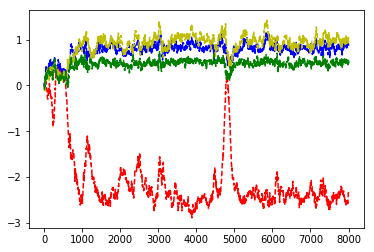

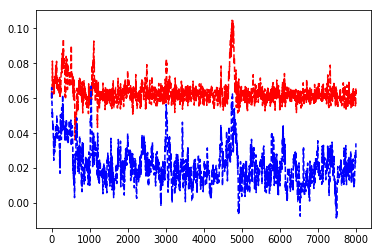

In [15]:
print('acceptance rate',chain.shape, np.unique(chain,axis=0).shape,np.unique(chain,axis=0).shape[0]*100/chain.shape[0])

chain2 = pd.DataFrame(chain, columns=['w0','w1','w2','w3','mu0','mu1'])
chain2['iteration'] = chain2.index
chain2.head()
plt.plot(chain2.iteration,chain2.w0,'r--',
         chain2.iteration,chain2.w1,'b--',
         chain2.iteration,chain2.w2,'y--',
         chain2.iteration,chain2.w3,'g--')
plt.show()
plt.plot(chain2.iteration,chain2.mu0,'r--',
         chain2.iteration,chain2.mu1,'b--')
plt.show()


In [16]:
print('last iteration T=1 elements',Tnew.sum())

Tmatrix = Tmatrix[int(Tmatrix.shape[0]*0.25):Tmatrix.shape[0]]
tprob = Tmatrix.sum(axis=0)/Tmatrix.shape[0]
#tfinal = np.random.binomial(1,tprob,len(tprob))
tfinal = tprob
#tfinal[tprob==1] = 1
#tfinal[tprob<1] = 0
tfinal = np.random.binomial(1,tprob,len(tprob))

gd = data[tfinal==1]
gp = data[tfinal==0]
print('driver genes size - final',gd['gscore'].shape[0])
print('passenger genes size - final',gp['gscore'].shape[0])

last iteration T=1 elements 356
driver genes size - final 312
passenger genes size - final 1157


In [17]:
maximum = list(set(data.gene.tolist()).intersection(evaluation))

gene = gd.gene.tolist()
driver = list(set(gene).intersection(maximum))
print('Proportion of Driver from other lists (Recall): ', len(driver)*100/len(maximum),'%(',len(driver),'/',len(maximum),')')
print('Proportion of Driver Genes on Data: ',len(gene)*100/data.shape[0],'%(',len(gene),')')
print('Proportion of Driver Genes on other lists (Precision):',len(driver)*100/len(gene),'%')
driver

Proportion of Driver from other lists (Recall):  66.66666666666667 %( 22 / 33 )
Proportion of Driver Genes on Data:  21.238938053097346 %( 312 )
Proportion of Driver Genes on other lists (Precision): 7.051282051282051 %


['AHNAK',
 'PTEN',
 'FOXA1',
 'ERCC2',
 'KLK2',
 'NKX3-1',
 'SMARCA1',
 'TP53',
 'BRAF',
 'SPOP',
 'SALL4',
 'BCOR',
 'CDKN1B',
 'CTNNB1',
 'TMPRSS2',
 'PCDH18',
 'BCLAF1',
 'KEAP1',
 'HSPA8',
 'HSP90AB1',
 'SLC45A3',
 'TBX3']

In [18]:
pd.options.display.max_rows = 4000
gene = gd.gene.tolist()
gene

['NDUFB9',
 'CTPS2',
 'C3orf58',
 'NLGN1',
 'SLA',
 'SNX27',
 'FOXA1',
 'PLXNC1',
 'HLTF',
 'FKBP9',
 'PLOD2',
 'GAL3ST4',
 'MRPL38',
 'C8orf33',
 'LMTK2',
 'ZFX',
 'ZFP64',
 'CYP3A43',
 'GGA3',
 'NT5C',
 'FPGS',
 'PTRH1',
 'VCPIP1',
 'PPP1R9A',
 'PON2',
 'ARHGAP6',
 'LSM14B',
 'PDK4',
 'LETM1',
 'DLX6',
 'RSRC1',
 'SYPL1',
 'DNAJC5B',
 'ELMO2',
 'PTGIS',
 'NFE2L3',
 'NFYB',
 'SPON2',
 'SLC20A2',
 'GPSM1',
 'SLU7',
 'ATP2A2',
 'LONP2',
 'SALL4',
 'TNFSF8',
 'RUSC1',
 'ATP2B1',
 'MCCC1',
 'CSTF1',
 'GDPD1',
 'SKA2',
 'ZNF789',
 'ARPC1A',
 'ZKSCAN5',
 'PTCD1',
 'FBXO21',
 'UBLCP1',
 'GTPBP10',
 'MRPL15',
 'HSPA9',
 'ETF1',
 'ISCU',
 'PMEPA1',
 'RPL28',
 'CA8',
 'MDM4',
 'MKRN1',
 'HSPA5',
 'PPP6C',
 'FAM181B',
 'NIPBL',
 'SPOP',
 'TBX3',
 'WDR34',
 'SET',
 'BRAF',
 'PSMC5',
 'SLC45A3',
 'RPL12',
 'BIRC5',
 'NUMA1',
 'EZH2',
 'RBM19',
 'BCL6',
 'PRKAR1A',
 'UBC',
 'APLP2',
 'SNX13',
 'PSMD12',
 'HSP90AA1',
 'RPS2',
 'HSPA8',
 'HOXB13',
 'SLC47A2',
 'TAF1D',
 'HNF1B',
 'MYOT',
 'ACTL7B',
 

In [19]:
top100 = data
top100['prob'] = tprob
top100 = top100.sort_values("prob", axis=0, ascending=False)
genes100 = top100['gene'].head(100)
list(genes100)

['CSRNP1',
 'C10orf99',
 'ZFP36L2',
 'ELOVL6',
 'RPL10A',
 'NACA',
 'ZIC5',
 'EFNA5',
 'MRPS17',
 'ACLY',
 'PRTFDC1',
 'FTL',
 'TMBIM6',
 'STAG2',
 'SH2D1A',
 'PBX4',
 'PTCD3',
 'CLCNKB',
 'NOP58',
 'VHL',
 'RPS11',
 'GIGYF2',
 'SMARCA1',
 'EMG1',
 'PHB2',
 'RREB1',
 'MAP2K7',
 'TIMM44',
 'AADACL4',
 'GAS2L2',
 'RPL18',
 'CDK4',
 'RPL36',
 'KDM1A',
 'KLHL32',
 'RPS12',
 'ARID1A',
 'FEM1A',
 'MORN4',
 'RPS18',
 'RPL11',
 'GZMH',
 'FBN1',
 'RPS27A',
 'ANKRD11',
 'MYH9',
 'FTH1',
 'AHNAK',
 'RNF181',
 'AAMP',
 'ZNF485',
 'MYL9',
 'IFI16',
 'USP7',
 'KIN',
 'MED14',
 'BZW1',
 'TAPT1',
 'UBN1',
 'HNRNPL',
 'ZNF827',
 'GABPA',
 'MAPRE1',
 'MFGE8',
 'ATP6V1C2',
 'TAF1D',
 'HOXB13',
 'SPOP',
 'COPA',
 'TMPRSS11D',
 'RAG1',
 'NFIB',
 'TAF1L',
 'PSAP',
 'H2AFV',
 'PPIB',
 'KLK4',
 'KLK2',
 'RPL31',
 'TMPRSS2',
 'HIC1',
 'ETV3',
 'GAPDH',
 'CYP2C8',
 'HSP90AB1',
 'FARP1',
 'SMG7',
 'B2M',
 'EIF6',
 'PIKFYVE',
 'NOL7',
 'HIST1H4B',
 'COL11A1',
 'RYBP',
 'HDLBP',
 'NAA38',
 'EPB41L3',
 'CTNNB1',
 '

In [20]:
driver = list(set(genes100).intersection(maximum))
print('Proportion of Driver from other lists (Recall): ', len(driver)*100/len(maximum),'%(',len(driver),'/',len(maximum),')')
print('Proportion of Driver Genes on Data: ',len(genes100)*100/data.shape[0],'%(',len(genes100),')')
print('Proportion of Driver Genes on other lists (Precision):',len(driver)*100/len(genes100),'%')
driver

Proportion of Driver from other lists (Recall):  21.21212121212121 %( 7 / 33 )
Proportion of Driver Genes on Data:  6.807351940095303 %( 100 )
Proportion of Driver Genes on other lists (Precision): 7.0 %


['AHNAK', 'SPOP', 'TMPRSS2', 'KLK2', 'SMARCA1', 'HSP90AB1', 'CTNNB1']